## Install Packages

In [3]:
!nvidia-smi

Tue Jun 25 20:12:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:0C:00.0 Off |                  N/A |
|  0%   42C    P8              17W / 350W |      1MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import 

In [1]:
import sys
from pathlib import Path
from time import sleep
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchinfo import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from torchmetrics import ConfusionMatrix
from torch.optim.lr_scheduler import ExponentialLR
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import time
import copy
from torchvision.transforms import v2
from PIL import Image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://g

In [2]:
import engine
import train
import data_setup
import model_builder
import config
from utilities import visual
from utilities.helper import save_model, get_num_correct, set_seed, create_target_dir, create_dir

In [3]:
# Setup

In [4]:
from pathlib import Path
#DATA_DIR = Path('Datasets/Clothes/')
#DATA_DIR = Path('Datasets/Data_Logo2K/')
#DATA_DIR = Path('Datasets/Dataset(1and2)/')
DATA_DIR = Path('Datasets/ClothesModified/')

[INFO]: Dataset loaded successfully.
[INFO]: Transforms are Done ..


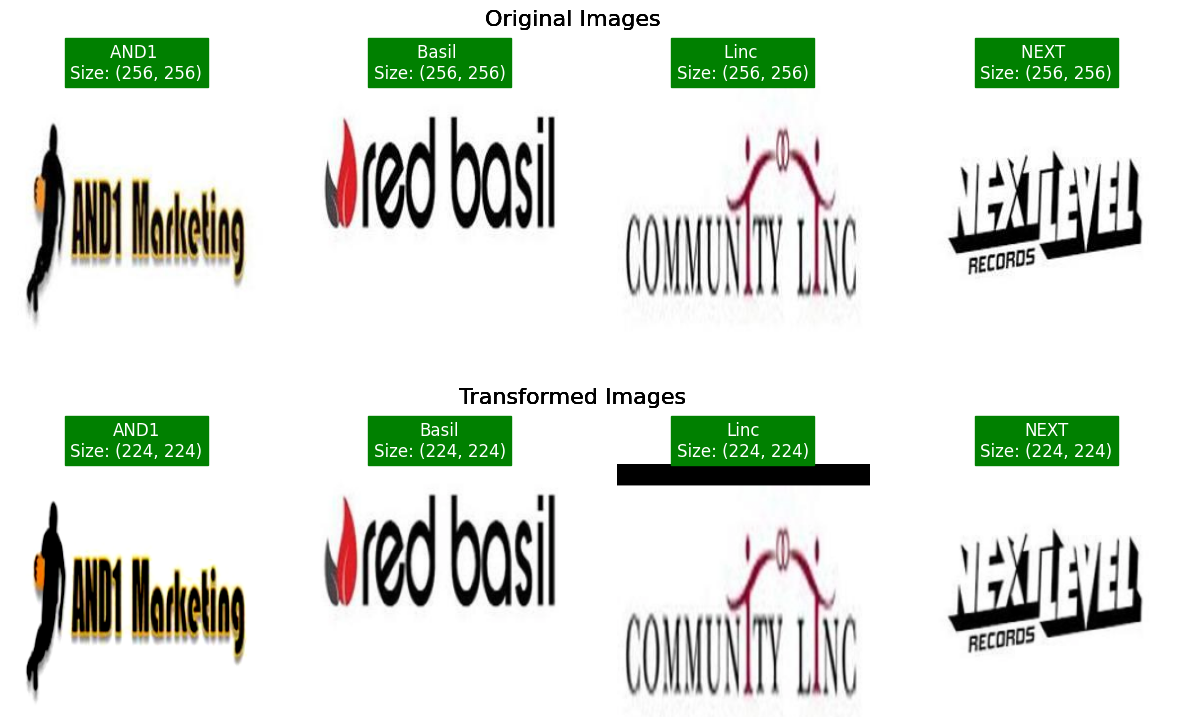

In [5]:
train_dataset, valid_dataset, class_names = data_setup.get_datasets(DATA_DIR)
transforms_train, transforms_valid = data_setup.get_transforms()
target_dir= 'models/img'
visual.plot_img_before_after_transformation(train_dataset, transforms_train, class_names, target_dir)

In [7]:
brand_names = ['None','Adidas', 'Nike', 'H&M']
classes = {}
for brand in brand_names:
    classes.update({class_names.index(brand): brand})

In [9]:
#classes[292]

In [10]:
images = []
for img, label in train_dataset:
    if label in classes.keys():
        images.append((img, classes[label]))
        del classes[label]
    if len(images)==4:
        break

In [11]:
images

[(<PIL.Image.Image image mode=RGB size=256x256>, 'Adidas'),
 (<PIL.Image.Image image mode=RGB size=213x54>, 'None'),
 (<PIL.Image.Image image mode=RGB size=48x39>, 'H&M'),
 (<PIL.Image.Image image mode=RGB size=256x256>, 'Nike')]

In [12]:
def plot_img_before_after_transformation(images, transforms, class_names, target_dir):
    fig = plt.figure(figsize=(15, 9))
    rows, cols = 2, 4
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    for i, (img, brand) in enumerate(images):
        # Plot original image
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(f"{brand} \nSize: {img.size}", color='white', backgroundcolor='green')
        ax.axis("off")

        # Apply transformation and plot transformed image
        transformed_image = transforms(img).permute(1, 2, 0)
        transformed_image = std * transformed_image + mean  # Denormalize
        transformed_image = np.clip(transformed_image.numpy(), 0, 1)

        ax = fig.add_subplot(rows, cols, i + 5)
        ax.imshow(transformed_image)
        h, w, c = transformed_image.shape
        ax.set_title(f"{brand}\nSize: {(h, w)}", color='white', backgroundcolor='green')
        ax.axis("off")
    fig.text(0.5, 0.92, 'Original Images', ha='center', va='center', fontsize=16, color='black')
    fig.text(0.5, 0.50, 'Transformed Images', ha='center', va='center', fontsize=16, color='black')
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    # Save and show the plot
    plt.savefig(os.path.join(target_dir, 'img_before_and_after_transformation.png'))
    plt.show()

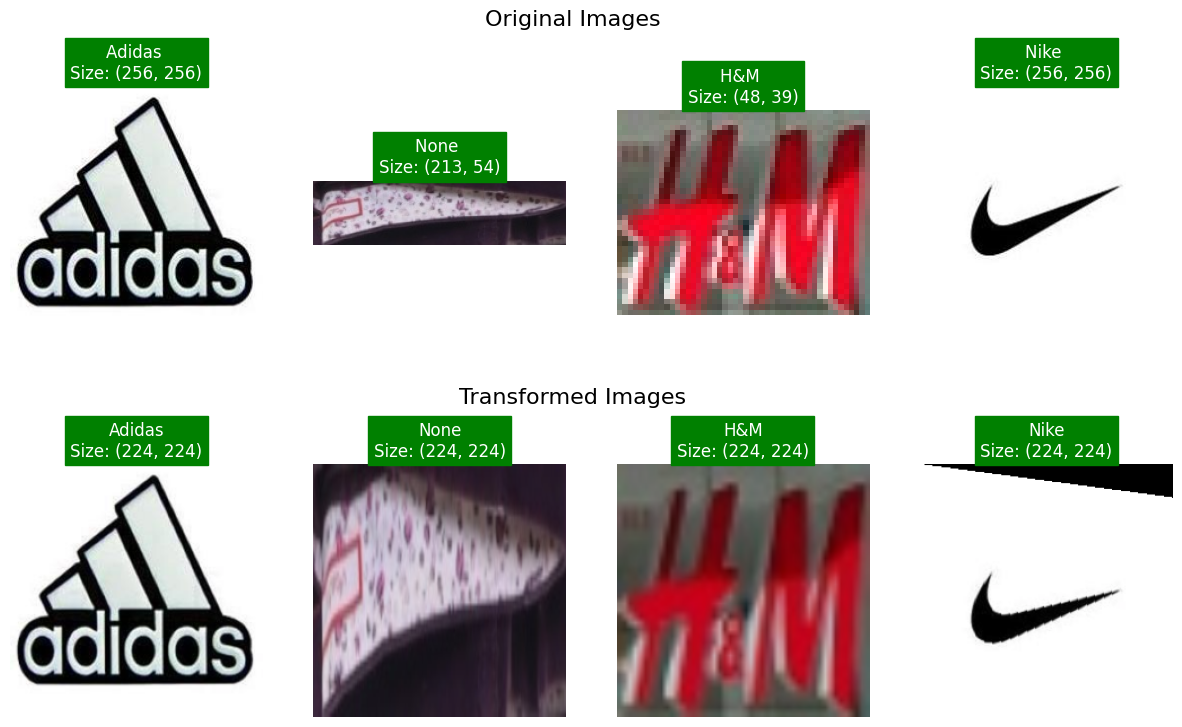

In [13]:
plot_img_before_after_transformation(images,transforms_train, class_names, target_dir )
target_dir= 'models/img'

## Unzip the data 

!unzip Clothes.zip 

In [5]:
from pathlib import Path
#DATA_DIR = Path('Datasets/Clothes/')
#DATA_DIR = Path('Datasets/Data_Logo2K/')
#DATA_DIR = Path('Datasets/Dataset(1and2)/')
DATA_DIR = Path('Datasets/ClothesModified/')

In [5]:
set_seed(42)

[INFO]: Seed set to: 42 for Python's built-in random module, NumPy and PyTorch.
[INFO]: PyTorch CUDA seeds set to: 42
[INFO]: PyTorch cuDNN deterministic setting set to True for reproducibility.
[INFO]: PyTorch cuDNN benchmark setting set to False for reproducibility.


# Visualize an image

In [6]:
import random
from PIL import Image

# set seed
#random.seed(42)
# Get all image paths 
image_path_list = list(DATA_DIR.glob('*/*.jpg'))
 
# Get random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name 
image_class = random_image_path.parent.stem

# Open Image
img = Image.open(random_image_path)

Random image path: Datasets/Dataset(1and2)/Sterling/28.jpg
Image class: Sterling
Image height: 256
Image width: 256
Image color_channels: 3


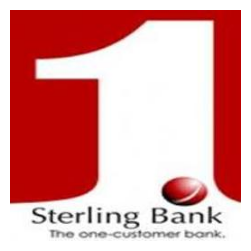

In [7]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
print(f"Image color_channels: {img_as_array.shape[2]}")
# Turn the image into an array

# Plot the image with matplotlib
plt.figure(figsize=(5, 3))
plt.imshow(img_as_array)
plt.axis(False);

In [8]:
import torch
print("Number of CUDA devices available:", torch.cuda.device_count())

num_workers = os.cpu_count()
print(num_workers)

Number of CUDA devices available: 1
24


## Data augmentaion and normalizaion

In [26]:
transforms_train, transforms_valid = data_setup.get_transforms()

Deleting: Datasets/Data_Logo2K/.ipynb_checkpoints


In [37]:
from collections import Counter

def is_valid_file(x):
    return x.endswith('.jpg') or x.endswith('.jpeg') or x.endswith('.png')
# Load the dataset without the DataLoader
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transforms_train, is_valid_file=is_valid_file)

# Count the instances of each class directly from the dataset targets
class_counts['None'] = Counter([dataset.classes[label] for _, label in dataset.samples])
del class_counts['None']
# Convert the Counter to a dictionary if needed
class_counts = dict(class_counts)

# Convert the counts to a pandas DataFrame for easier plotting
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Instances'])

In [38]:
x = range(len(class_counts_df))
xx = class_counts_df['Class']
y = class_counts_df['Instances']

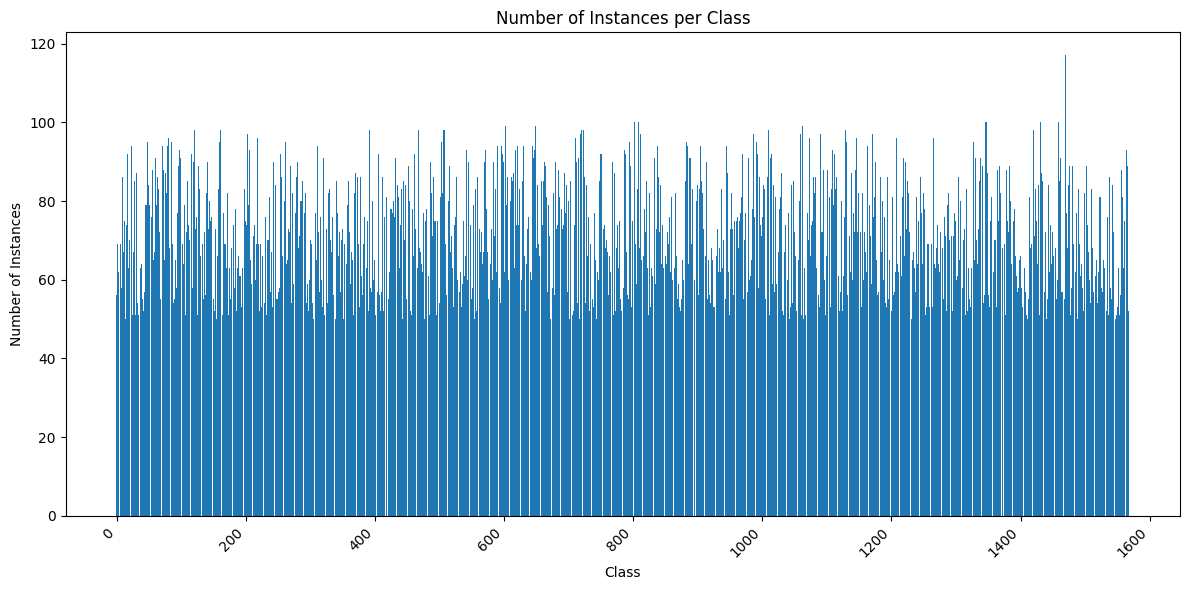

In [39]:
# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x,y, width=0.9)
plt.title('Number of Instances per Class')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.tight_layout() 
plt.savefig("data_distribution.png")
plt.show()

In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


## LOAD DATA

In [43]:
from sklearn.model_selection import KFold

train_dataset, valid_dataset, class_names = data_setup.get_datasets(data_dir=DATA_DIR, split_size=0.8)

1341


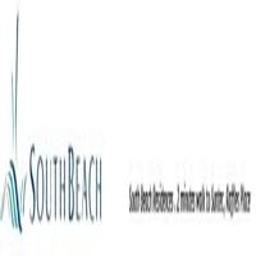

In [44]:
img ,  label = train_dataset[1860]
print(label)
img

In [45]:
class_names[207]

'Beeline'

In [46]:
len(class_names)

1570

In [47]:
print(len(train_dataset))
print(len(valid_dataset))

90072
22519


In [48]:
batch_size = 24
train_dataloader , valid_dataloader = data_setup.get_dataloaders(train_dataset, valid_dataset, batch_size, 4)



print('Train dataset size:', len(train_dataset))
print('Valid dataset size:', len(valid_dataset))
#print('Class names:', class_names)

num_classes = len(class_names)

print('Class numbers:', num_classes)
print()
print('Train dataloader size (number of batches):', len(train_dataloader))
print('Valid dataloader size (number of batches):', len(valid_dataloader))
print('Train dataset size:', len(train_dataloader.dataset))
print('Valid dataset size::', len(valid_dataloader.dataset))

Train dataset size: 90072
Valid dataset size: 22519
Class numbers: 1570

Train dataloader size (number of batches): 3753
Valid dataloader size (number of batches): 939
Train dataset size: 90072
Valid dataset size:: 22519


#  Visualize data after transformation

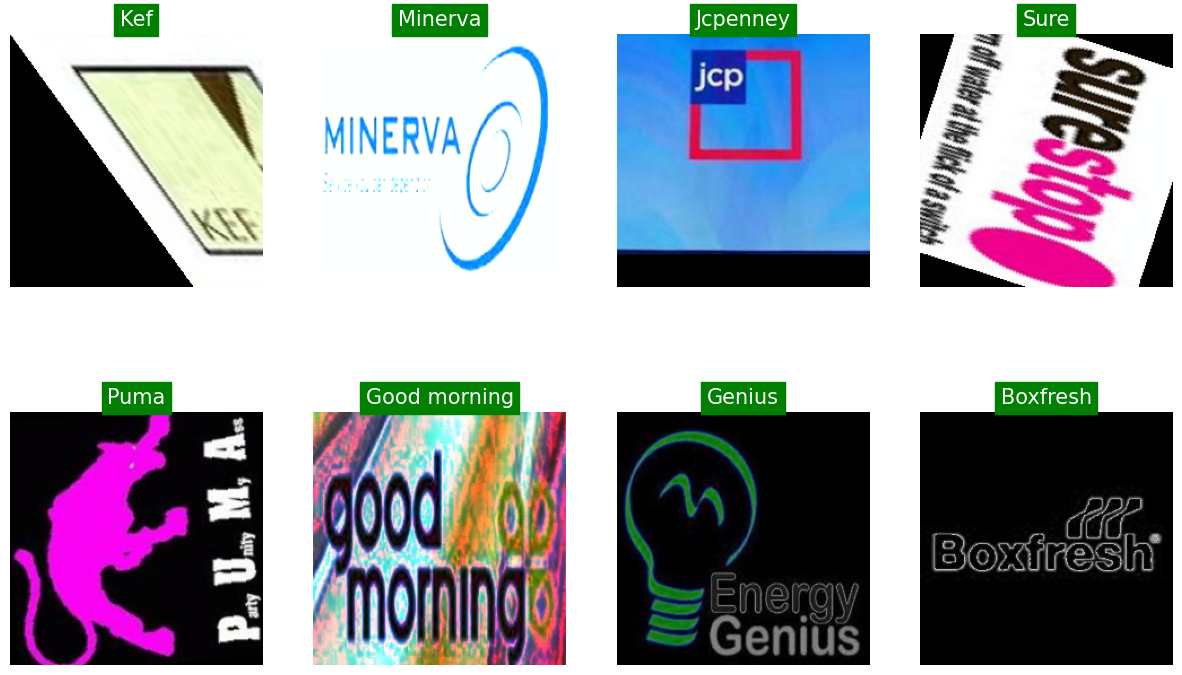

In [49]:
fig = plt.figure(figsize=(15,9))
rows, cols = 2, 4

# Load a batch of train images
iterator = iter(train_dataloader)
inputs, classes = next(iterator)
def imshow(input_img, title, ax):
    input_img = input_img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input_img = std * input_img + mean
    input_img = np.clip(input_img, 0, 1)
    ax.imshow(input_img)
    ax.set_title(title, fontsize=15, color='white', backgroundcolor='green')
    ax.axis('off')  # Hide axes

# Loop through the first 8 images in the batch
for i in range(1, 9):
    ax = fig.add_subplot(rows, cols, i)
    # Display each image in its subplot
    imshow(inputs[i - 1], class_names[classes[i - 1]], ax)
plt.savefig('models/img_after_transformation.png')
plt.show()

## Load pre-trained ResNet-18 model 

# Models to train
'Models': ['Resnet50', 'Resnet101', 'EfficientNetB7', 'Vgg16']

'Models': ['Resnet18', 'EfficientNetB0']

Optimizer ='SGD'

# this model with new transormation 4/2024-06-20_22:43/Resnet50/
2) number 1 was good but stopped earlier#, i wanted to train it more, so warmup 80
Data_Path:"Datasets/Clothes/"
Save_To:"models/2024-06-20_22:43/Resnet50"
Split_Size:0.8
Fine_Tune:false
Pretrained:true
Num_Epochs:300
Batch_size:32
Name:"Adam"
lr:0.001
weight_decay:0.001
momentum:0.9
Loss_Function:"CrossEntropyLoss"
label_smoothing:0.1
Name:"CustomLRSchedulerModified"
step_size:10
gamma:0.1
Warmup_Epochs:80
Stop_LR:10
Base_LR:0.001
Final_LR:0.000001
Patience:20
min_delta:0
verbose:true


Classifier_layer: Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2048, out_features=1024, bias=True)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=1024, out_features=287, bias=True)
)

# this model with new transormation 4/2024-06-20_12:31/Resnet50/
1)
Data_Path:"Datasets/Clothes/"
Save_To:"models/2024-06-20_12:31/Resnet50"
Split_Size:0.8
0:"Resnet50"
1:"EfficientNetB7"
2:"Vgg16"
Fine_Tune:false
Pretrained:true
Num_Epochs:300
Batch_size:32
Name:"Adam"
lr:0.001
weight_decay:0.001
momentum:0.9
Loss_Function:"CrossEntropyLoss"
label_smoothing:0.1
Name:"CustomLRSchedulerModified"
step_size:10
gamma:0.1
Warmup_Epochs:150
Stop_LR:10
Base_LR:0.001
Final_LR:0.000001
Patience:20
min_delta:0
verbose:true2
    

Classifier_layer: Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2048, out_features=1024, bias=True)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=1024, out_features=287, bias=True)
)

## Train the model on custom data 

In [19]:
CONFIG = {
    'Data_Path': 'Datasets/ClothesModified/',  #Clothes #Data_Logo2K #Dataset(1and2)
    'Save_To': 'models',
    'Cross_Validation': False,
    'k_folds': 5,
    'Split_Size': 0.8, 
    'Models': ['Resnet50', 'EfficientNetB7', 'Vgg16', 'Resnet101' ], #, 'Resnet101', 'EfficientNetB7'
    'Fine_Tune': False,
    'Pretrained': True,
    'Num_Epochs': 300, 
    'Batch_size': 32, 
    'Optimizer': {
       'Name': 'Adam',
        'lr': 0.001,
         'weight_decay':0.001,
        'momentum': 0.9
    },
    'Loss_Function': 'CrossEntropyLoss',
    'label_smoothing': 0.1,
    'Scheduler': {
       'Name': 'CustomLRSchedulerModified', 
        #'Name': 'StepLR', CustomLRScheduler, ReduceLROnPlateau, CosineAnnealingLR, #CustomLRSchedulerModified
        'step_size': 10, 
        'gamma': 0.1, 
        'Warmup_Epochs': 80, 
        'Stop_LR': 150, 
        'Base_LR': 1e-3, 
        'Final_LR': 1e-5
    },
    'EarlyStopping': {
        'Patience': 20, 
        'min_delta': 0, 
        'verbose': True
    }
}

In [20]:
config.set_config(config=CONFIG)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = model.to(device)

Strating to train Resnet50...
[INFO]: Dataset loaded successfully.
[INFO]: Transforms are Done ..
[INFO]: Number of Training Images: 16971
[INFO]: Number of Validation Images: 4243
[INFO]: Number of Classes: 297

[INFO]: Transforms are Done ..


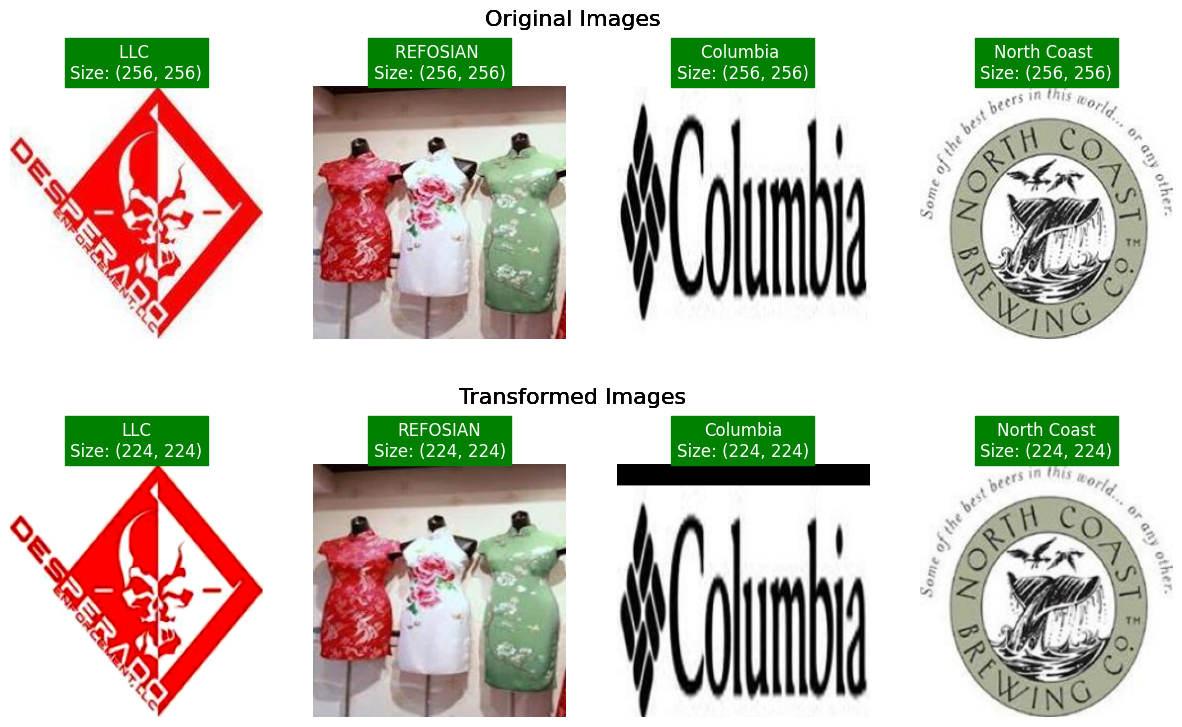

[INFO]: Seed set to: 42 for Python's built-in random module, NumPy and PyTorch.
[INFO]: PyTorch CUDA seeds set to: 42
[INFO]: PyTorch cuDNN deterministic setting set to True for reproducibility.
[INFO]: PyTorch cuDNN benchmark setting set to False for reproducibility.

Model: Resnet50
[INFO]: Number of infeatures:2048
[INFO]: Freezing hidden layers...
[INFO]: Setting Loss Function: CrossEntropyLoss..
[INFO]: Setting Optimizer: Adam..
[INFO]: Setting Scheduler: CustomLRSchedulerModified..

Configuration Settings: {
    "Data_Path": "Datasets/ClothesModified/",
    "Save_To": "models/2024-07-04_9:3/Resnet50",
    "Cross_Validation": false,
    "k_folds": 5,
    "Split_Size": 0.8,
    "Models": [
        "Resnet50",
        "EfficientNetB7",
        "Vgg16",
        "Resnet101"
    ],
    "Fine_Tune": false,
    "Pretrained": true,
    "Num_Epochs": 300,
    "Batch_size": 32,
    "Optimizer": {
        "Name": "Adam",
        "lr": 0.001,
        "weight_decay": 0.001,
        "momentum":

  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 6.1051 | Acc: 1.0017% | Weighted F1: 0.5471
[INFO] Validation Loss: 29.5895 | Acc: 1.3198% | Weighted F1: 0.1859
[INFO] Validation loss decreased (inf --> 29.589515).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 2 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.9362 | Acc: 1.8266% | Weighted F1: 0.9181
[INFO] Validation Loss: 5.3992 | Acc: 3.7002% | Weighted F1: 1.1726
[INFO] Validation loss decreased (29.589515 --> 5.399242).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 3 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6737 | Acc: 2.7635% | Weighted F1: 1.7672
[INFO] Validation Loss: 5.3216 | Acc: 4.9022% | Weighted F1: 1.9694
[INFO] Validation loss decreased (5.399242 --> 5.321566).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 4 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.3662 | Acc: 4.8612% | Weighted F1: 3.1642
[INFO] Validation Loss: 5.1039 | Acc: 8.3903% | Weighted F1: 4.7918
[INFO] Validation loss decreased (5.321566 --> 5.103933).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 5 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.1323 | Acc: 7.9076% | Weighted F1: 5.0980
[INFO] Validation Loss: 4.9676 | Acc: 9.5687% | Weighted F1: 6.3384
[INFO] Validation loss decreased (5.103933 --> 4.967605).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 6 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.9665 | Acc: 9.8344% | Weighted F1: 6.6606
[INFO] Validation Loss: 4.7869 | Acc: 12.9154% | Weighted F1: 8.9610
[INFO] Validation loss decreased (4.967605 --> 4.786915).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 7 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.8684 | Acc: 11.3488% | Weighted F1: 7.9596
[INFO] Validation Loss: 4.7132 | Acc: 13.9995% | Weighted F1: 9.7228
[INFO] Validation loss decreased (4.786915 --> 4.713244).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 8 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.7784 | Acc: 12.8454% | Weighted F1: 9.2771
[INFO] Validation Loss: 4.6667 | Acc: 15.0837% | Weighted F1: 11.6821
[INFO] Validation loss decreased (4.713244 --> 4.666669).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 9 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.7058 | Acc: 13.9179% | Weighted F1: 10.2572
[INFO] Validation Loss: 4.5050 | Acc: 17.5819% | Weighted F1: 13.4698
[INFO] Validation loss decreased (4.666669 --> 4.504972).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 10 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.6440 | Acc: 15.1435% | Weighted F1: 11.5390
[INFO] Validation Loss: 4.5269 | Acc: 17.0398% | Weighted F1: 13.3787
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 11 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.5756 | Acc: 15.9979% | Weighted F1: 12.4358
[INFO] Validation Loss: 4.4332 | Acc: 18.3125% | Weighted F1: 14.2664
[INFO] Validation loss decreased (4.504972 --> 4.433205).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 12 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.5142 | Acc: 17.2353% | Weighted F1: 13.6740
[INFO] Validation Loss: 4.3156 | Acc: 20.9522% | Weighted F1: 16.5675
[INFO] Validation loss decreased (4.433205 --> 4.315637).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 13 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.4443 | Acc: 18.2429% | Weighted F1: 14.6847
[INFO] Validation Loss: 4.2545 | Acc: 22.7433% | Weighted F1: 18.8812
[INFO] Validation loss decreased (4.315637 --> 4.254466).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 14 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.3724 | Acc: 19.4803% | Weighted F1: 16.0468
[INFO] Validation Loss: 4.1758 | Acc: 23.3090% | Weighted F1: 19.0660
[INFO] Validation loss decreased (4.254466 --> 4.175840).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 15 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.3082 | Acc: 20.6116% | Weighted F1: 17.2717
[INFO] Validation Loss: 4.0978 | Acc: 25.0295% | Weighted F1: 21.8234
[INFO] Validation loss decreased (4.175840 --> 4.097751).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 16 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.2485 | Acc: 21.7076% | Weighted F1: 18.7216
[INFO] Validation Loss: 3.9701 | Acc: 27.0563% | Weighted F1: 23.5645
[INFO] Validation loss decreased (4.097751 --> 3.970134).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 17 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.1569 | Acc: 23.4812% | Weighted F1: 20.6977
[INFO] Validation Loss: 3.9514 | Acc: 27.4334% | Weighted F1: 23.8004
[INFO] Validation loss decreased (3.970134 --> 3.951450).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 18 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.0949 | Acc: 25.0899% | Weighted F1: 22.2509
[INFO] Validation Loss: 3.8849 | Acc: 29.2010% | Weighted F1: 26.1201
[INFO] Validation loss decreased (3.951450 --> 3.884871).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 19 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.0397 | Acc: 25.8382% | Weighted F1: 23.6011
[INFO] Validation Loss: 3.7599 | Acc: 32.2413% | Weighted F1: 29.1458
[INFO] Validation loss decreased (3.884871 --> 3.759851).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 20 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.9792 | Acc: 27.2877% | Weighted F1: 24.9687
[INFO] Validation Loss: 3.7849 | Acc: 30.9922% | Weighted F1: 28.9373
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 21 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.9246 | Acc: 28.5546% | Weighted F1: 26.4644
[INFO] Validation Loss: 3.6526 | Acc: 34.5510% | Weighted F1: 32.2291
[INFO] Validation loss decreased (3.759851 --> 3.652603).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 22 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.8841 | Acc: 29.3265% | Weighted F1: 27.3479
[INFO] Validation Loss: 3.5826 | Acc: 36.2008% | Weighted F1: 33.9057
[INFO] Validation loss decreased (3.652603 --> 3.582561).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 23 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.8268 | Acc: 30.7878% | Weighted F1: 28.8402
[INFO] Validation Loss: 3.5107 | Acc: 38.3691% | Weighted F1: 36.0814
[INFO] Validation loss decreased (3.582561 --> 3.510711).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 24 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.7681 | Acc: 31.5833% | Weighted F1: 29.8231
[INFO] Validation Loss: 3.4446 | Acc: 39.7832% | Weighted F1: 38.4146
[INFO] Validation loss decreased (3.510711 --> 3.444585).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 25 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.7325 | Acc: 32.6557% | Weighted F1: 30.9358
[INFO] Validation Loss: 3.3976 | Acc: 40.9852% | Weighted F1: 39.1436
[INFO] Validation loss decreased (3.444585 --> 3.397570).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 26 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.6927 | Acc: 33.8931% | Weighted F1: 32.3376
[INFO] Validation Loss: 3.4023 | Acc: 40.6552% | Weighted F1: 39.1212
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 27 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.6569 | Acc: 34.3999% | Weighted F1: 32.8510
[INFO] Validation Loss: 3.3538 | Acc: 42.4464% | Weighted F1: 40.9387
[INFO] Validation loss decreased (3.397570 --> 3.353765).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 28 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.6062 | Acc: 36.0792% | Weighted F1: 34.5825
[INFO] Validation Loss: 3.3132 | Acc: 43.2241% | Weighted F1: 41.4717
[INFO] Validation loss decreased (3.353765 --> 3.313191).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 29 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.5909 | Acc: 36.0203% | Weighted F1: 34.6466
[INFO] Validation Loss: 3.3039 | Acc: 43.4362% | Weighted F1: 42.6140
[INFO] Validation loss decreased (3.313191 --> 3.303875).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 30 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.5487 | Acc: 37.2164% | Weighted F1: 35.9536
[INFO] Validation Loss: 3.2689 | Acc: 44.9682% | Weighted F1: 44.3637
[INFO] Validation loss decreased (3.303875 --> 3.268869).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 31 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.5261 | Acc: 37.8351% | Weighted F1: 36.6506
[INFO] Validation Loss: 3.2475 | Acc: 44.7796% | Weighted F1: 43.6765
[INFO] Validation loss decreased (3.268869 --> 3.247479).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 32 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.4912 | Acc: 38.5540% | Weighted F1: 37.4671
[INFO] Validation Loss: 3.1967 | Acc: 45.4395% | Weighted F1: 44.3835
[INFO] Validation loss decreased (3.247479 --> 3.196652).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 33 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.4795 | Acc: 38.8722% | Weighted F1: 37.6747
[INFO] Validation Loss: 3.2610 | Acc: 45.8166% | Weighted F1: 44.3442
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 34 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.4545 | Acc: 39.3318% | Weighted F1: 38.2008
[INFO] Validation Loss: 3.2213 | Acc: 46.6415% | Weighted F1: 45.5651
[INFO] EarlyStopping counter: 2 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 35 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.4498 | Acc: 39.4909% | Weighted F1: 38.5910
[INFO] Validation Loss: 3.3135 | Acc: 44.1197% | Weighted F1: 43.3302
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 36 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.4271 | Acc: 39.7384% | Weighted F1: 38.8610
[INFO] Validation Loss: 3.2013 | Acc: 45.8638% | Weighted F1: 45.2116
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 37 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3986 | Acc: 40.7283% | Weighted F1: 39.7991
[INFO] Validation Loss: 3.1317 | Acc: 47.7492% | Weighted F1: 47.3070
[INFO] Validation loss decreased (3.196652 --> 3.131721).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 38 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3674 | Acc: 41.3234% | Weighted F1: 40.5594
[INFO] Validation Loss: 3.1270 | Acc: 48.8805% | Weighted F1: 48.5208
[INFO] Validation loss decreased (3.131721 --> 3.127023).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 39 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3550 | Acc: 41.5297% | Weighted F1: 40.6900
[INFO] Validation Loss: 3.1206 | Acc: 47.7257% | Weighted F1: 47.6329
[INFO] Validation loss decreased (3.127023 --> 3.120566).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 40 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3449 | Acc: 41.9539% | Weighted F1: 41.1338
[INFO] Validation Loss: 3.0623 | Acc: 49.0926% | Weighted F1: 48.6068
[INFO] Validation loss decreased (3.120566 --> 3.062348).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 41 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3076 | Acc: 43.1560% | Weighted F1: 42.4034
[INFO] Validation Loss: 3.1416 | Acc: 47.1600% | Weighted F1: 46.8560
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 42 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3028 | Acc: 43.3681% | Weighted F1: 42.7085
[INFO] Validation Loss: 3.0633 | Acc: 50.1061% | Weighted F1: 49.9779
[INFO] EarlyStopping counter: 2 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 43 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2898 | Acc: 43.3681% | Weighted F1: 42.7128
[INFO] Validation Loss: 3.0949 | Acc: 48.9041% | Weighted F1: 49.1570
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 44 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2710 | Acc: 43.7570% | Weighted F1: 43.0484
[INFO] Validation Loss: 3.0019 | Acc: 51.1431% | Weighted F1: 50.9256
[INFO] Validation loss decreased (3.062348 --> 3.001918).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 45 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2909 | Acc: 43.5390% | Weighted F1: 42.8673
[INFO] Validation Loss: 3.0074 | Acc: 51.1666% | Weighted F1: 50.9392
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 46 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2481 | Acc: 44.4228% | Weighted F1: 43.7901
[INFO] Validation Loss: 2.9787 | Acc: 52.0858% | Weighted F1: 51.6465
[INFO] Validation loss decreased (3.001918 --> 2.978701).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 47 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2462 | Acc: 44.0693% | Weighted F1: 43.4785
[INFO] Validation Loss: 2.9455 | Acc: 52.4393% | Weighted F1: 51.6283
[INFO] Validation loss decreased (2.978701 --> 2.945456).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 48 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2234 | Acc: 45.0474% | Weighted F1: 44.5192
[INFO] Validation Loss: 2.9949 | Acc: 51.5909% | Weighted F1: 51.3062
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 49 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2169 | Acc: 45.4835% | Weighted F1: 44.7910
[INFO] Validation Loss: 3.0137 | Acc: 50.9781% | Weighted F1: 50.5025
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 50 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2024 | Acc: 45.3892% | Weighted F1: 44.8929
[INFO] Validation Loss: 2.9452 | Acc: 52.2743% | Weighted F1: 52.3041
[INFO] Validation loss decreased (2.945456 --> 2.945220).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 51 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1870 | Acc: 45.4187% | Weighted F1: 44.8730
[INFO] Validation Loss: 2.9434 | Acc: 53.2878% | Weighted F1: 53.1923
[INFO] Validation loss decreased (2.945220 --> 2.943414).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 52 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1758 | Acc: 46.0668% | Weighted F1: 45.4827
[INFO] Validation Loss: 2.9021 | Acc: 53.4999% | Weighted F1: 52.9176
[INFO] Validation loss decreased (2.943414 --> 2.902137).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 53 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1809 | Acc: 46.0609% | Weighted F1: 45.5158
[INFO] Validation Loss: 2.9044 | Acc: 53.0049% | Weighted F1: 52.7702
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 54 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1713 | Acc: 45.9077% | Weighted F1: 45.4316
[INFO] Validation Loss: 2.9066 | Acc: 53.9241% | Weighted F1: 54.3225
[INFO] EarlyStopping counter: 2 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 55 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1577 | Acc: 46.5382% | Weighted F1: 46.1045
[INFO] Validation Loss: 2.9475 | Acc: 52.0151% | Weighted F1: 51.6192
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 56 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1643 | Acc: 46.5677% | Weighted F1: 46.0799
[INFO] Validation Loss: 2.9246 | Acc: 53.0992% | Weighted F1: 52.9987
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 57 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1603 | Acc: 46.6207% | Weighted F1: 46.1816
[INFO] Validation Loss: 2.9319 | Acc: 53.0521% | Weighted F1: 52.8447
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 58 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1318 | Acc: 47.5046% | Weighted F1: 46.9838
[INFO] Validation Loss: 2.9029 | Acc: 53.9241% | Weighted F1: 54.6896
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 59 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1314 | Acc: 47.6047% | Weighted F1: 47.1311
[INFO] Validation Loss: 2.9111 | Acc: 53.2171% | Weighted F1: 53.1101
[INFO] EarlyStopping counter: 7 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 60 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1266 | Acc: 47.3985% | Weighted F1: 46.9976
[INFO] Validation Loss: 2.8908 | Acc: 53.4292% | Weighted F1: 53.1182
[INFO] Validation loss decreased (2.902137 --> 2.890831).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 61 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1460 | Acc: 47.2453% | Weighted F1: 46.8256
[INFO] Validation Loss: 2.8906 | Acc: 54.8197% | Weighted F1: 54.5785
[INFO] Validation loss decreased (2.890831 --> 2.890611).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 62 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1099 | Acc: 47.7049% | Weighted F1: 47.3104
[INFO] Validation Loss: 2.8899 | Acc: 54.1362% | Weighted F1: 53.7368
[INFO] Validation loss decreased (2.890611 --> 2.889860).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 63 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1126 | Acc: 47.9406% | Weighted F1: 47.6143
[INFO] Validation Loss: 2.8343 | Acc: 56.0453% | Weighted F1: 55.9169
[INFO] Validation loss decreased (2.889860 --> 2.834317).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 64 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1188 | Acc: 47.5753% | Weighted F1: 47.1835
[INFO] Validation Loss: 2.8537 | Acc: 54.9140% | Weighted F1: 54.5319
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 65 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1086 | Acc: 48.1645% | Weighted F1: 47.6607
[INFO] Validation Loss: 2.8945 | Acc: 54.5605% | Weighted F1: 54.7153
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 66 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0933 | Acc: 48.3177% | Weighted F1: 47.9961
[INFO] Validation Loss: 2.8511 | Acc: 54.7254% | Weighted F1: 54.5500
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 67 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1095 | Acc: 47.5517% | Weighted F1: 47.1369
[INFO] Validation Loss: 2.8449 | Acc: 55.3146% | Weighted F1: 55.3170
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 68 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0856 | Acc: 48.9423% | Weighted F1: 48.5977
[INFO] Validation Loss: 2.8646 | Acc: 55.3618% | Weighted F1: 55.6143
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 69 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0783 | Acc: 48.4297% | Weighted F1: 48.1251
[INFO] Validation Loss: 2.8203 | Acc: 56.1631% | Weighted F1: 55.7125
[INFO] Validation loss decreased (2.834317 --> 2.820305).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 70 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0797 | Acc: 48.2824% | Weighted F1: 47.9466
[INFO] Validation Loss: 2.8519 | Acc: 54.9140% | Weighted F1: 55.1215
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 71 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0776 | Acc: 49.0012% | Weighted F1: 48.5707
[INFO] Validation Loss: 2.7622 | Acc: 57.7893% | Weighted F1: 57.4741
[INFO] Validation loss decreased (2.820305 --> 2.762228).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 72 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0590 | Acc: 49.3018% | Weighted F1: 48.9698
[INFO] Validation Loss: 2.8280 | Acc: 55.2675% | Weighted F1: 55.5042
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 73 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0638 | Acc: 49.1898% | Weighted F1: 48.9314
[INFO] Validation Loss: 2.8460 | Acc: 55.1732% | Weighted F1: 55.5235
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 74 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0489 | Acc: 49.5139% | Weighted F1: 49.1932
[INFO] Validation Loss: 2.8456 | Acc: 55.6682% | Weighted F1: 55.8164
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 75 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0593 | Acc: 49.6494% | Weighted F1: 49.4328
[INFO] Validation Loss: 2.7581 | Acc: 57.5065% | Weighted F1: 57.4040
[INFO] Validation loss decreased (2.762228 --> 2.758078).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 76 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0391 | Acc: 49.6789% | Weighted F1: 49.4968
[INFO] Validation Loss: 2.7956 | Acc: 57.4358% | Weighted F1: 58.0573
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 77 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0486 | Acc: 49.2605% | Weighted F1: 49.1063
[INFO] Validation Loss: 2.9803 | Acc: 53.3820% | Weighted F1: 55.0786
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 78 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0572 | Acc: 49.3076% | Weighted F1: 48.9897
[INFO] Validation Loss: 2.8242 | Acc: 56.9408% | Weighted F1: 57.3784
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 79 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0337 | Acc: 49.8262% | Weighted F1: 49.5427
[INFO] Validation Loss: 2.7832 | Acc: 57.1294% | Weighted F1: 57.1574
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 80 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0214 | Acc: 50.5745% | Weighted F1: 50.2834
[INFO] Validation Loss: 2.8051 | Acc: 56.4695% | Weighted F1: 56.1413
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 81 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009955
[INFO] LR: 0.0009955
[INFO] Training Loss: 3.0255 | Acc: 50.1031% | Weighted F1: 49.8302
[INFO] Validation Loss: 2.8470 | Acc: 55.2911% | Weighted F1: 55.9002
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 82 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009910000000000001
[INFO] LR: 0.0009910000000000001
[INFO] Training Loss: 3.0164 | Acc: 50.2151% | Weighted F1: 49.9433
[INFO] Validation Loss: 2.7762 | Acc: 56.6109% | Weighted F1: 56.7940
[INFO] EarlyStopping counter: 7 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 83 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009865
[INFO] LR: 0.0009865
[INFO] Training Loss: 3.0303 | Acc: 50.2740% | Weighted F1: 49.9833
[INFO] Validation Loss: 2.7715 | Acc: 58.0250% | Weighted F1: 58.1664
[INFO] EarlyStopping counter: 8 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 84 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000982
[INFO] LR: 0.000982
[INFO] Training Loss: 3.0115 | Acc: 50.5156% | Weighted F1: 50.3485
[INFO] Validation Loss: 2.7873 | Acc: 56.7052% | Weighted F1: 57.0862
[INFO] EarlyStopping counter: 9 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 85 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009775
[INFO] LR: 0.0009775
[INFO] Training Loss: 2.9906 | Acc: 50.7218% | Weighted F1: 50.4659
[INFO] Validation Loss: 2.7044 | Acc: 59.6512% | Weighted F1: 59.6579
[INFO] Validation loss decreased (2.758078 --> 2.704378).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 86 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000973
[INFO] LR: 0.000973
[INFO] Training Loss: 2.9914 | Acc: 50.8397% | Weighted F1: 50.6888
[INFO] Validation Loss: 2.7669 | Acc: 57.0587% | Weighted F1: 57.6024
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 87 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009685000000000001
[INFO] LR: 0.0009685000000000001
[INFO] Training Loss: 2.9898 | Acc: 50.7866% | Weighted F1: 50.5813
[INFO] Validation Loss: 2.6978 | Acc: 58.8970% | Weighted F1: 59.0460
[INFO] Validation loss decreased (2.704378 --> 2.697764).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 88 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000964
[INFO] LR: 0.000964
[INFO] Training Loss: 2.9512 | Acc: 51.7530% | Weighted F1: 51.5147
[INFO] Validation Loss: 2.7781 | Acc: 57.1530% | Weighted F1: 57.0089
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 89 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009595000000000001
[INFO] LR: 0.0009595000000000001
[INFO] Training Loss: 2.9656 | Acc: 51.5939% | Weighted F1: 51.3751
[INFO] Validation Loss: 2.7529 | Acc: 58.7556% | Weighted F1: 58.4250
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 90 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000955
[INFO] LR: 0.000955
[INFO] Training Loss: 2.9700 | Acc: 52.0005% | Weighted F1: 51.7853
[INFO] Validation Loss: 2.7341 | Acc: 58.6142% | Weighted F1: 58.6330
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 91 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009505000000000001
[INFO] LR: 0.0009505000000000001
[INFO] Training Loss: 2.9624 | Acc: 51.8826% | Weighted F1: 51.7035
[INFO] Validation Loss: 2.7354 | Acc: 57.8600% | Weighted F1: 58.0157
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 92 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000946
[INFO] LR: 0.000946
[INFO] Training Loss: 2.9528 | Acc: 51.9474% | Weighted F1: 51.7317
[INFO] Validation Loss: 2.9570 | Acc: 51.1902% | Weighted F1: 52.1750
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 93 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009415000000000001
[INFO] LR: 0.0009415000000000001
[INFO] Training Loss: 2.9655 | Acc: 51.7117% | Weighted F1: 51.5959
[INFO] Validation Loss: 2.7206 | Acc: 58.8499% | Weighted F1: 59.2350
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 94 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000937
[INFO] LR: 0.000937
[INFO] Training Loss: 2.9506 | Acc: 52.1301% | Weighted F1: 51.8949
[INFO] Validation Loss: 2.7110 | Acc: 58.7320% | Weighted F1: 59.0831
[INFO] EarlyStopping counter: 7 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 95 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009325000000000001
[INFO] LR: 0.0009325000000000001
[INFO] Training Loss: 2.9501 | Acc: 52.1831% | Weighted F1: 52.0565
[INFO] Validation Loss: 2.7357 | Acc: 58.9206% | Weighted F1: 59.2999
[INFO] EarlyStopping counter: 8 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 96 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000928
[INFO] LR: 0.000928
[INFO] Training Loss: 2.9407 | Acc: 52.3717% | Weighted F1: 52.2394
[INFO] Validation Loss: 2.6564 | Acc: 60.4761% | Weighted F1: 60.4286
[INFO] Validation loss decreased (2.697764 --> 2.656358).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 97 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009235000000000001
[INFO] LR: 0.0009235000000000001
[INFO] Training Loss: 2.9355 | Acc: 52.5897% | Weighted F1: 52.4760
[INFO] Validation Loss: 2.7410 | Acc: 57.2472% | Weighted F1: 57.9770
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 98 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000919
[INFO] LR: 0.000919
[INFO] Training Loss: 2.9203 | Acc: 53.1554% | Weighted F1: 53.0025
[INFO] Validation Loss: 2.6914 | Acc: 59.6748% | Weighted F1: 60.1028
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 99 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009145000000000001
[INFO] LR: 0.0009145000000000001
[INFO] Training Loss: 2.9141 | Acc: 53.2084% | Weighted F1: 52.9996
[INFO] Validation Loss: 2.7062 | Acc: 58.8263% | Weighted F1: 59.3488
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 100 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00091
[INFO] LR: 0.00091
[INFO] Training Loss: 2.9177 | Acc: 52.9491% | Weighted F1: 52.7807
[INFO] Validation Loss: 2.7594 | Acc: 57.9543% | Weighted F1: 58.0821
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 101 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009055000000000001
[INFO] LR: 0.0009055000000000001
[INFO] Training Loss: 2.9095 | Acc: 52.8961% | Weighted F1: 52.7863
[INFO] Validation Loss: 2.6980 | Acc: 59.2505% | Weighted F1: 59.3243
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 102 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000901
[INFO] LR: 0.000901
[INFO] Training Loss: 2.9060 | Acc: 53.1848% | Weighted F1: 53.1463
[INFO] Validation Loss: 2.7262 | Acc: 58.4256% | Weighted F1: 58.8916
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 103 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008965
[INFO] LR: 0.0008965
[INFO] Training Loss: 2.8818 | Acc: 54.0451% | Weighted F1: 53.9286
[INFO] Validation Loss: 2.6615 | Acc: 59.8633% | Weighted F1: 59.6052
[INFO] EarlyStopping counter: 7 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 104 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000892
[INFO] LR: 0.000892
[INFO] Training Loss: 2.8909 | Acc: 53.9744% | Weighted F1: 53.8593
[INFO] Validation Loss: 2.6678 | Acc: 59.6748% | Weighted F1: 59.7209
[INFO] EarlyStopping counter: 8 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 105 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008875
[INFO] LR: 0.0008875
[INFO] Training Loss: 2.8722 | Acc: 53.8507% | Weighted F1: 53.6323
[INFO] Validation Loss: 2.6658 | Acc: 59.9811% | Weighted F1: 59.3677
[INFO] EarlyStopping counter: 9 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 106 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000883
[INFO] LR: 0.000883
[INFO] Training Loss: 2.8509 | Acc: 54.4989% | Weighted F1: 54.3261
[INFO] Validation Loss: 2.7179 | Acc: 59.0384% | Weighted F1: 59.2203
[INFO] EarlyStopping counter: 10 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 107 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008785
[INFO] LR: 0.0008785
[INFO] Training Loss: 2.8842 | Acc: 54.2573% | Weighted F1: 54.0380
[INFO] Validation Loss: 2.6339 | Acc: 61.8195% | Weighted F1: 61.4157
[INFO] Validation loss decreased (2.656358 --> 2.633944).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 108 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000874
[INFO] LR: 0.000874
[INFO] Training Loss: 2.8641 | Acc: 54.3339% | Weighted F1: 54.2466
[INFO] Validation Loss: 2.6682 | Acc: 60.4761% | Weighted F1: 60.3862
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 109 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008695
[INFO] LR: 0.0008695
[INFO] Training Loss: 2.8502 | Acc: 54.3869% | Weighted F1: 54.3500
[INFO] Validation Loss: 2.6636 | Acc: 60.2875% | Weighted F1: 59.9170
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 110 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000865
[INFO] LR: 0.000865
[INFO] Training Loss: 2.8541 | Acc: 54.4576% | Weighted F1: 54.3084
[INFO] Validation Loss: 2.6522 | Acc: 60.5939% | Weighted F1: 60.6591
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 111 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008605
[INFO] LR: 0.0008605
[INFO] Training Loss: 2.8490 | Acc: 54.7463% | Weighted F1: 54.6677
[INFO] Validation Loss: 2.6387 | Acc: 61.0653% | Weighted F1: 61.3688
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 112 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000856
[INFO] LR: 0.000856
[INFO] Training Loss: 2.8363 | Acc: 55.1883% | Weighted F1: 55.1506
[INFO] Validation Loss: 2.6702 | Acc: 59.6748% | Weighted F1: 60.0074
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 113 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008515
[INFO] LR: 0.0008515
[INFO] Training Loss: 2.8631 | Acc: 54.5696% | Weighted F1: 54.5242
[INFO] Validation Loss: 2.6159 | Acc: 61.1831% | Weighted F1: 61.6654
[INFO] Validation loss decreased (2.633944 --> 2.615853).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 114 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000847
[INFO] LR: 0.000847
[INFO] Training Loss: 2.8357 | Acc: 55.1293% | Weighted F1: 55.0522
[INFO] Validation Loss: 2.6266 | Acc: 60.8060% | Weighted F1: 61.0623
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 115 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008425
[INFO] LR: 0.0008425
[INFO] Training Loss: 2.8035 | Acc: 55.8011% | Weighted F1: 55.6459
[INFO] Validation Loss: 2.5929 | Acc: 61.3481% | Weighted F1: 61.4098
[INFO] Validation loss decreased (2.615853 --> 2.592922).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 116 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000838
[INFO] LR: 0.000838
[INFO] Training Loss: 2.8242 | Acc: 55.3709% | Weighted F1: 55.3057
[INFO] Validation Loss: 2.6353 | Acc: 60.3582% | Weighted F1: 60.5754
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 117 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008335
[INFO] LR: 0.0008335
[INFO] Training Loss: 2.7985 | Acc: 55.8718% | Weighted F1: 55.7983
[INFO] Validation Loss: 2.6888 | Acc: 59.6983% | Weighted F1: 59.4917
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 118 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000829
[INFO] LR: 0.000829
[INFO] Training Loss: 2.8241 | Acc: 55.5831% | Weighted F1: 55.4571
[INFO] Validation Loss: 2.6274 | Acc: 61.0653% | Weighted F1: 61.3472
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 119 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008245
[INFO] LR: 0.0008245
[INFO] Training Loss: 2.8023 | Acc: 55.5241% | Weighted F1: 55.5788
[INFO] Validation Loss: 2.6298 | Acc: 60.9239% | Weighted F1: 60.8354
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 120 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00082
[INFO] LR: 0.00082
[INFO] Training Loss: 2.8053 | Acc: 56.0839% | Weighted F1: 56.0300
[INFO] Validation Loss: 2.6049 | Acc: 61.5602% | Weighted F1: 61.7331
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 121 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008155
[INFO] LR: 0.0008155
[INFO] Training Loss: 2.7838 | Acc: 56.2842% | Weighted F1: 56.1622
[INFO] Validation Loss: 2.6238 | Acc: 61.7016% | Weighted F1: 61.6321
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 122 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008110000000000001
[INFO] LR: 0.0008110000000000001
[INFO] Training Loss: 2.7840 | Acc: 56.5141% | Weighted F1: 56.4733
[INFO] Validation Loss: 2.5939 | Acc: 61.2067% | Weighted F1: 61.4029
[INFO] EarlyStopping counter: 7 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 123 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008065
[INFO] LR: 0.0008065
[INFO] Training Loss: 2.7807 | Acc: 56.0898% | Weighted F1: 56.0411
[INFO] Validation Loss: 2.5708 | Acc: 62.4087% | Weighted F1: 62.5341
[INFO] Validation loss decreased (2.592922 --> 2.570752).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 124 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000802
[INFO] LR: 0.000802
[INFO] Training Loss: 2.7765 | Acc: 56.5258% | Weighted F1: 56.5035
[INFO] Validation Loss: 2.5983 | Acc: 61.7252% | Weighted F1: 61.9362
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 125 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007975
[INFO] LR: 0.0007975
[INFO] Training Loss: 2.7646 | Acc: 56.8381% | Weighted F1: 56.7682
[INFO] Validation Loss: 2.6302 | Acc: 60.4761% | Weighted F1: 60.8575
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 126 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007930000000000001
[INFO] LR: 0.0007930000000000001
[INFO] Training Loss: 2.7807 | Acc: 56.5671% | Weighted F1: 56.5477
[INFO] Validation Loss: 2.5762 | Acc: 62.9507% | Weighted F1: 62.9132
[INFO] EarlyStopping counter: 3 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 127 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007885
[INFO] LR: 0.0007885
[INFO] Training Loss: 2.7710 | Acc: 56.4610% | Weighted F1: 56.4785
[INFO] Validation Loss: 2.5884 | Acc: 61.7959% | Weighted F1: 61.8977
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 128 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000784
[INFO] LR: 0.000784
[INFO] Training Loss: 2.7529 | Acc: 56.7321% | Weighted F1: 56.6898
[INFO] Validation Loss: 2.6054 | Acc: 60.9003% | Weighted F1: 60.8923
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 129 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007795
[INFO] LR: 0.0007795
[INFO] Training Loss: 2.7438 | Acc: 57.5865% | Weighted F1: 57.4842
[INFO] Validation Loss: 2.5651 | Acc: 61.9609% | Weighted F1: 62.0787
[INFO] Validation loss decreased (2.570752 --> 2.565113).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 130 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000775
[INFO] LR: 0.000775
[INFO] Training Loss: 2.7635 | Acc: 56.4669% | Weighted F1: 56.4993
[INFO] Validation Loss: 2.6039 | Acc: 61.9137% | Weighted F1: 61.8599
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 131 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007705
[INFO] LR: 0.0007705
[INFO] Training Loss: 2.7322 | Acc: 57.8988% | Weighted F1: 57.9608
[INFO] Validation Loss: 2.5464 | Acc: 62.7858% | Weighted F1: 63.1912
[INFO] Validation loss decreased (2.565113 --> 2.546364).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 132 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000766
[INFO] LR: 0.000766
[INFO] Training Loss: 2.7327 | Acc: 57.7102% | Weighted F1: 57.5961
[INFO] Validation Loss: 2.5990 | Acc: 61.8666% | Weighted F1: 61.9063
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 133 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007615
[INFO] LR: 0.0007615
[INFO] Training Loss: 2.7302 | Acc: 57.4451% | Weighted F1: 57.4214
[INFO] Validation Loss: 2.5467 | Acc: 62.5265% | Weighted F1: 62.6512
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 134 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007570000000000001
[INFO] LR: 0.0007570000000000001
[INFO] Training Loss: 2.7234 | Acc: 58.1993% | Weighted F1: 58.1156
[INFO] Validation Loss: 2.5402 | Acc: 63.3750% | Weighted F1: 63.2247
[INFO] Validation loss decreased (2.546364 --> 2.540245).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 135 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007525
[INFO] LR: 0.0007525
[INFO] Training Loss: 2.7285 | Acc: 57.6336% | Weighted F1: 57.5897
[INFO] Validation Loss: 2.5580 | Acc: 62.5501% | Weighted F1: 63.1953
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 136 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000748
[INFO] LR: 0.000748
[INFO] Training Loss: 2.7164 | Acc: 58.1580% | Weighted F1: 58.1312
[INFO] Validation Loss: 2.5740 | Acc: 62.1730% | Weighted F1: 62.3719
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 137 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007435
[INFO] LR: 0.0007435
[INFO] Training Loss: 2.7080 | Acc: 58.2877% | Weighted F1: 58.2041
[INFO] Validation Loss: 2.5653 | Acc: 62.1966% | Weighted F1: 62.3424
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 138 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007390000000000001
[INFO] LR: 0.0007390000000000001
[INFO] Training Loss: 2.7079 | Acc: 58.4114% | Weighted F1: 58.4597
[INFO] Validation Loss: 2.5338 | Acc: 63.3985% | Weighted F1: 63.5535
[INFO] Validation loss decreased (2.540245 --> 2.533833).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 139 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007345
[INFO] LR: 0.0007345
[INFO] Training Loss: 2.7057 | Acc: 58.2641% | Weighted F1: 58.2285
[INFO] Validation Loss: 2.5698 | Acc: 62.9036% | Weighted F1: 63.2510
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 140 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00073
[INFO] LR: 0.00073
[INFO] Training Loss: 2.6963 | Acc: 58.4232% | Weighted F1: 58.4048
[INFO] Validation Loss: 2.5360 | Acc: 63.2100% | Weighted F1: 63.2138
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 141 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007255
[INFO] LR: 0.0007255
[INFO] Training Loss: 2.7107 | Acc: 58.2995% | Weighted F1: 58.3092
[INFO] Validation Loss: 2.5439 | Acc: 62.9036% | Weighted F1: 62.8268
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 142 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007210000000000001
[INFO] LR: 0.0007210000000000001
[INFO] Training Loss: 2.6932 | Acc: 58.8474% | Weighted F1: 58.7762
[INFO] Validation Loss: 2.5307 | Acc: 63.4928% | Weighted F1: 63.7525
[INFO] Validation loss decreased (2.533833 --> 2.530701).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 143 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007165
[INFO] LR: 0.0007165
[INFO] Training Loss: 2.6828 | Acc: 58.6942% | Weighted F1: 58.6859
[INFO] Validation Loss: 2.5634 | Acc: 62.2908% | Weighted F1: 62.9897
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 144 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000712
[INFO] LR: 0.000712
[INFO] Training Loss: 2.6907 | Acc: 58.8416% | Weighted F1: 58.8420
[INFO] Validation Loss: 2.4997 | Acc: 63.7756% | Weighted F1: 63.8824
[INFO] Validation loss decreased (2.530701 --> 2.499679).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 145 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007075
[INFO] LR: 0.0007075
[INFO] Training Loss: 2.6697 | Acc: 59.5781% | Weighted F1: 59.6252
[INFO] Validation Loss: 2.5465 | Acc: 62.5972% | Weighted F1: 62.8058
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 146 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007030000000000001
[INFO] LR: 0.0007030000000000001
[INFO] Training Loss: 2.6825 | Acc: 59.0655% | Weighted F1: 59.0778
[INFO] Validation Loss: 2.5313 | Acc: 63.3985% | Weighted F1: 63.4384
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 147 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006985
[INFO] LR: 0.0006985
[INFO] Training Loss: 2.6520 | Acc: 59.5604% | Weighted F1: 59.5557
[INFO] Validation Loss: 2.5539 | Acc: 63.3985% | Weighted F1: 64.0281
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 148 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000694
[INFO] LR: 0.000694
[INFO] Training Loss: 2.6613 | Acc: 59.3012% | Weighted F1: 59.3593
[INFO] Validation Loss: 2.5243 | Acc: 62.6208% | Weighted F1: 63.0921
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 149 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006895
[INFO] LR: 0.0006895
[INFO] Training Loss: 2.6618 | Acc: 59.4131% | Weighted F1: 59.5490
[INFO] Validation Loss: 2.5174 | Acc: 63.9877% | Weighted F1: 64.3442
[INFO] EarlyStopping counter: 5 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 150 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006850000000000001
[INFO] LR: 0.0006850000000000001
[INFO] Training Loss: 2.6358 | Acc: 60.1615% | Weighted F1: 60.1770
[INFO] Validation Loss: 2.4967 | Acc: 64.1527% | Weighted F1: 64.0064
[INFO] Validation loss decreased (2.499679 --> 2.496731).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 151 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006805
[INFO] LR: 0.0006805
[INFO] Training Loss: 2.6432 | Acc: 60.1143% | Weighted F1: 60.1284
[INFO] Validation Loss: 2.4835 | Acc: 64.9305% | Weighted F1: 65.0164
[INFO] Validation loss decreased (2.496731 --> 2.483478).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 152 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006760000000000001
[INFO] LR: 0.0006760000000000001
[INFO] Training Loss: 2.6241 | Acc: 60.5327% | Weighted F1: 60.4476
[INFO] Validation Loss: 2.4753 | Acc: 64.7655% | Weighted F1: 64.9503
[INFO] Validation loss decreased (2.483478 --> 2.475345).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 153 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006715
[INFO] LR: 0.0006715
[INFO] Training Loss: 2.6359 | Acc: 60.6328% | Weighted F1: 60.5819
[INFO] Validation Loss: 2.4965 | Acc: 64.0584% | Weighted F1: 64.7805
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 154 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006670000000000001
[INFO] LR: 0.0006670000000000001
[INFO] Training Loss: 2.6190 | Acc: 60.5032% | Weighted F1: 60.5369
[INFO] Validation Loss: 2.4999 | Acc: 64.3648% | Weighted F1: 64.4084
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 155 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006625000000000001
[INFO] LR: 0.0006625000000000001
[INFO] Training Loss: 2.6054 | Acc: 60.9746% | Weighted F1: 61.0919
[INFO] Validation Loss: 2.4850 | Acc: 64.7419% | Weighted F1: 64.7819
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 156 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000658
[INFO] LR: 0.000658
[INFO] Training Loss: 2.6297 | Acc: 60.4207% | Weighted F1: 60.5162
[INFO] Validation Loss: 2.5044 | Acc: 64.6948% | Weighted F1: 64.5854
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 157 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006535
[INFO] LR: 0.0006535
[INFO] Training Loss: 2.6134 | Acc: 60.6977% | Weighted F1: 60.6711
[INFO] Validation Loss: 2.5213 | Acc: 62.7151% | Weighted F1: 63.0537
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 158 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006490000000000001
[INFO] LR: 0.0006490000000000001
[INFO] Training Loss: 2.5925 | Acc: 60.7978% | Weighted F1: 60.8360
[INFO] Validation Loss: 2.5017 | Acc: 64.6948% | Weighted F1: 64.7016
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 159 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006445
[INFO] LR: 0.0006445
[INFO] Training Loss: 2.6024 | Acc: 61.1396% | Weighted F1: 61.0934
[INFO] Validation Loss: 2.5211 | Acc: 63.4457% | Weighted F1: 63.4890
[INFO] EarlyStopping counter: 7 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 160 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00064
[INFO] LR: 0.00064
[INFO] Training Loss: 2.5916 | Acc: 61.1691% | Weighted F1: 61.0902
[INFO] Validation Loss: 2.4799 | Acc: 64.6241% | Weighted F1: 64.8732
[INFO] EarlyStopping counter: 8 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 161 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006355
[INFO] LR: 0.0006355
[INFO] Training Loss: 2.6030 | Acc: 61.0748% | Weighted F1: 61.2022
[INFO] Validation Loss: 2.5394 | Acc: 63.5164% | Weighted F1: 63.8992
[INFO] EarlyStopping counter: 9 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 162 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000631
[INFO] LR: 0.000631
[INFO] Training Loss: 2.5860 | Acc: 61.5108% | Weighted F1: 61.5066
[INFO] Validation Loss: 2.4856 | Acc: 64.2941% | Weighted F1: 64.4862
[INFO] EarlyStopping counter: 10 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 163 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006265000000000001
[INFO] LR: 0.0006265000000000001
[INFO] Training Loss: 2.5839 | Acc: 61.3871% | Weighted F1: 61.4474
[INFO] Validation Loss: 2.4903 | Acc: 64.4120% | Weighted F1: 64.7220
[INFO] EarlyStopping counter: 11 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 164 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000622
[INFO] LR: 0.000622
[INFO] Training Loss: 2.5804 | Acc: 61.9586% | Weighted F1: 61.8734
[INFO] Validation Loss: 2.4952 | Acc: 65.0955% | Weighted F1: 65.2784
[INFO] EarlyStopping counter: 12 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 165 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006175
[INFO] LR: 0.0006175
[INFO] Training Loss: 2.5666 | Acc: 61.7465% | Weighted F1: 61.7420
[INFO] Validation Loss: 2.4692 | Acc: 64.9069% | Weighted F1: 65.1196
[INFO] Validation loss decreased (2.475345 --> 2.469221).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 166 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000613
[INFO] LR: 0.000613
[INFO] Training Loss: 2.5738 | Acc: 61.8938% | Weighted F1: 61.9377
[INFO] Validation Loss: 2.4652 | Acc: 65.1190% | Weighted F1: 65.2262
[INFO] Validation loss decreased (2.469221 --> 2.465237).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 167 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006085000000000001
[INFO] LR: 0.0006085000000000001
[INFO] Training Loss: 2.5576 | Acc: 62.2415% | Weighted F1: 62.2772
[INFO] Validation Loss: 2.4825 | Acc: 63.8699% | Weighted F1: 64.1272
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 168 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006039999999999999
[INFO] LR: 0.0006039999999999999
[INFO] Training Loss: 2.5470 | Acc: 62.3829% | Weighted F1: 62.3921
[INFO] Validation Loss: 2.4547 | Acc: 65.0012% | Weighted F1: 64.8904
[INFO] Validation loss decreased (2.465237 --> 2.454674).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 169 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005995
[INFO] LR: 0.0005995
[INFO] Training Loss: 2.5684 | Acc: 62.2415% | Weighted F1: 62.3120
[INFO] Validation Loss: 2.4487 | Acc: 65.3076% | Weighted F1: 64.9719
[INFO] Validation loss decreased (2.454674 --> 2.448669).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 170 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000595
[INFO] LR: 0.000595
[INFO] Training Loss: 2.5561 | Acc: 62.5066% | Weighted F1: 62.5156
[INFO] Validation Loss: 2.4792 | Acc: 64.6477% | Weighted F1: 64.6126
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 171 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005905
[INFO] LR: 0.0005905
[INFO] Training Loss: 2.5335 | Acc: 63.0016% | Weighted F1: 63.0457
[INFO] Validation Loss: 2.4570 | Acc: 65.0955% | Weighted F1: 65.0903
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 172 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000586
[INFO] LR: 0.000586
[INFO] Training Loss: 2.5281 | Acc: 63.0252% | Weighted F1: 63.0915
[INFO] Validation Loss: 2.4779 | Acc: 64.8126% | Weighted F1: 65.1094
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 173 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005815
[INFO] LR: 0.0005815
[INFO] Training Loss: 2.5282 | Acc: 62.9839% | Weighted F1: 63.1107
[INFO] Validation Loss: 2.4422 | Acc: 65.4254% | Weighted F1: 65.3891
[INFO] Validation loss decreased (2.448669 --> 2.442166).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 174 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000577
[INFO] LR: 0.000577
[INFO] Training Loss: 2.5252 | Acc: 63.1725% | Weighted F1: 63.2916
[INFO] Validation Loss: 2.4683 | Acc: 64.6477% | Weighted F1: 64.7303
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 175 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005725000000000001
[INFO] LR: 0.0005725000000000001
[INFO] Training Loss: 2.5257 | Acc: 63.0841% | Weighted F1: 63.1681
[INFO] Validation Loss: 2.4225 | Acc: 65.9203% | Weighted F1: 65.9478
[INFO] Validation loss decreased (2.442166 --> 2.422461).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 176 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000568
[INFO] LR: 0.000568
[INFO] Training Loss: 2.5059 | Acc: 63.5378% | Weighted F1: 63.6440
[INFO] Validation Loss: 2.4343 | Acc: 65.5432% | Weighted F1: 65.4735
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 177 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005635
[INFO] LR: 0.0005635
[INFO] Training Loss: 2.5239 | Acc: 63.0075% | Weighted F1: 63.0806
[INFO] Validation Loss: 2.4462 | Acc: 65.4254% | Weighted F1: 65.4421
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 178 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000559
[INFO] LR: 0.000559
[INFO] Training Loss: 2.4931 | Acc: 63.7853% | Weighted F1: 63.8439
[INFO] Validation Loss: 2.4198 | Acc: 65.9203% | Weighted F1: 65.9622
[INFO] Validation loss decreased (2.422461 --> 2.419797).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 179 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005545000000000001
[INFO] LR: 0.0005545000000000001
[INFO] Training Loss: 2.4951 | Acc: 63.6262% | Weighted F1: 63.6291
[INFO] Validation Loss: 2.4551 | Acc: 65.5904% | Weighted F1: 65.7236
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 180 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005499999999999999
[INFO] LR: 0.0005499999999999999
[INFO] Training Loss: 2.4971 | Acc: 63.7971% | Weighted F1: 63.8595
[INFO] Validation Loss: 2.4116 | Acc: 66.0382% | Weighted F1: 65.9943
[INFO] Validation loss decreased (2.419797 --> 2.411606).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 181 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005455
[INFO] LR: 0.0005455
[INFO] Training Loss: 2.4882 | Acc: 64.4806% | Weighted F1: 64.5767
[INFO] Validation Loss: 2.4236 | Acc: 66.3210% | Weighted F1: 66.4410
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 182 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000541
[INFO] LR: 0.000541
[INFO] Training Loss: 2.4716 | Acc: 64.3745% | Weighted F1: 64.4146
[INFO] Validation Loss: 2.4372 | Acc: 65.8732% | Weighted F1: 65.6977
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 183 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005365
[INFO] LR: 0.0005365
[INFO] Training Loss: 2.4904 | Acc: 64.1035% | Weighted F1: 64.2368
[INFO] Validation Loss: 2.5211 | Acc: 63.6107% | Weighted F1: 63.4710
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 184 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000532
[INFO] LR: 0.000532
[INFO] Training Loss: 2.4821 | Acc: 64.3097% | Weighted F1: 64.3330
[INFO] Validation Loss: 2.4113 | Acc: 66.4388% | Weighted F1: 66.5098
[INFO] Validation loss decreased (2.411606 --> 2.411260).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 185 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005275
[INFO] LR: 0.0005275
[INFO] Training Loss: 2.4627 | Acc: 64.7752% | Weighted F1: 64.8179
[INFO] Validation Loss: 2.4183 | Acc: 66.2739% | Weighted F1: 66.5268
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 186 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000523
[INFO] LR: 0.000523
[INFO] Training Loss: 2.4425 | Acc: 65.0639% | Weighted F1: 65.1225
[INFO] Validation Loss: 2.4128 | Acc: 66.2267% | Weighted F1: 66.3119
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 187 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005185000000000001
[INFO] LR: 0.0005185000000000001
[INFO] Training Loss: 2.4650 | Acc: 64.4334% | Weighted F1: 64.5051
[INFO] Validation Loss: 2.3799 | Acc: 67.0045% | Weighted F1: 67.0462
[INFO] Validation loss decreased (2.411260 --> 2.379870).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 188 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000514
[INFO] LR: 0.000514
[INFO] Training Loss: 2.4631 | Acc: 64.4983% | Weighted F1: 64.6135
[INFO] Validation Loss: 2.3819 | Acc: 66.8631% | Weighted F1: 66.6587
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 189 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005095
[INFO] LR: 0.0005095
[INFO] Training Loss: 2.4632 | Acc: 64.9048% | Weighted F1: 64.9757
[INFO] Validation Loss: 2.4318 | Acc: 66.0146% | Weighted F1: 66.0165
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 190 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000505
[INFO] LR: 0.000505
[INFO] Training Loss: 2.4622 | Acc: 64.9814% | Weighted F1: 65.0670
[INFO] Validation Loss: 2.4235 | Acc: 66.0382% | Weighted F1: 65.9378
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 191 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005005
[INFO] LR: 0.0005005
[INFO] Training Loss: 2.4353 | Acc: 65.1346% | Weighted F1: 65.1130
[INFO] Validation Loss: 2.3998 | Acc: 66.8395% | Weighted F1: 66.8148
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 192 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000496
[INFO] LR: 0.000496
[INFO] Training Loss: 2.4204 | Acc: 65.8358% | Weighted F1: 65.9239
[INFO] Validation Loss: 2.4078 | Acc: 66.2739% | Weighted F1: 66.1476
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 193 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0004915000000000001
[INFO] LR: 0.0004915000000000001
[INFO] Training Loss: 2.4084 | Acc: 66.0539% | Weighted F1: 66.1687
[INFO] Validation Loss: 2.3850 | Acc: 67.4994% | Weighted F1: 67.6411
[INFO] EarlyStopping counter: 6 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 194 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000487
[INFO] LR: 0.000487
[INFO] Training Loss: 2.4072 | Acc: 66.3544% | Weighted F1: 66.4681
[INFO] Validation Loss: 2.3738 | Acc: 67.6408% | Weighted F1: 67.4081
[INFO] Validation loss decreased (2.379870 --> 2.373770).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 195 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0004825000000000001
[INFO] LR: 0.0004825000000000001
[INFO] Training Loss: 2.4001 | Acc: 66.2660% | Weighted F1: 66.3374
[INFO] Validation Loss: 2.4011 | Acc: 66.5095% | Weighted F1: 66.3389
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 196 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000478
[INFO] LR: 0.000478
[INFO] Training Loss: 2.4000 | Acc: 66.2778% | Weighted F1: 66.3710
[INFO] Validation Loss: 2.3897 | Acc: 67.4051% | Weighted F1: 67.2954
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 197 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00047349999999999996
[INFO] LR: 0.00047349999999999996
[INFO] Training Loss: 2.3998 | Acc: 66.3013% | Weighted F1: 66.3874
[INFO] Validation Loss: 2.3975 | Acc: 67.0988% | Weighted F1: 66.9193
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 198 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000469
[INFO] LR: 0.000469
[INFO] Training Loss: 2.3827 | Acc: 67.2795% | Weighted F1: 67.3450
[INFO] Validation Loss: 2.3709 | Acc: 68.1122% | Weighted F1: 67.9575
[INFO] Validation loss decreased (2.373770 --> 2.370892).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 199 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00046450000000000007
[INFO] LR: 0.00046450000000000007
[INFO] Training Loss: 2.4119 | Acc: 66.3485% | Weighted F1: 66.3981
[INFO] Validation Loss: 2.3872 | Acc: 66.8159% | Weighted F1: 66.9792
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 200 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00046
[INFO] LR: 0.00046
[INFO] Training Loss: 2.3788 | Acc: 67.2088% | Weighted F1: 67.3965
[INFO] Validation Loss: 2.3710 | Acc: 67.8058% | Weighted F1: 67.5729
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 201 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00045550000000000007
[INFO] LR: 0.00045550000000000007
[INFO] Training Loss: 2.3793 | Acc: 66.9613% | Weighted F1: 67.0200
[INFO] Validation Loss: 2.3954 | Acc: 66.4153% | Weighted F1: 66.5222
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 202 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000451
[INFO] LR: 0.000451
[INFO] Training Loss: 2.3857 | Acc: 66.9966% | Weighted F1: 67.0748
[INFO] Validation Loss: 2.3770 | Acc: 66.7452% | Weighted F1: 66.5128
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 203 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00044649999999999996
[INFO] LR: 0.00044649999999999996
[INFO] Training Loss: 2.3738 | Acc: 67.3148% | Weighted F1: 67.4160
[INFO] Validation Loss: 2.3509 | Acc: 67.3816% | Weighted F1: 67.3504
[INFO] Validation loss decreased (2.370892 --> 2.350878).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 204 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000442
[INFO] LR: 0.000442
[INFO] Training Loss: 2.3555 | Acc: 67.7037% | Weighted F1: 67.7748
[INFO] Validation Loss: 2.3839 | Acc: 67.6408% | Weighted F1: 67.5020
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 205 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00043750000000000006
[INFO] LR: 0.00043750000000000006
[INFO] Training Loss: 2.3504 | Acc: 67.6743% | Weighted F1: 67.7319
[INFO] Validation Loss: 2.3590 | Acc: 67.4051% | Weighted F1: 67.6709
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 206 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000433
[INFO] LR: 0.000433
[INFO] Training Loss: 2.3602 | Acc: 67.6153% | Weighted F1: 67.7080
[INFO] Validation Loss: 2.3892 | Acc: 67.3580% | Weighted F1: 67.5895
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 207 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00042849999999999995
[INFO] LR: 0.00042849999999999995
[INFO] Training Loss: 2.3460 | Acc: 67.8923% | Weighted F1: 68.0014
[INFO] Validation Loss: 2.3526 | Acc: 68.1593% | Weighted F1: 68.0928
[INFO] EarlyStopping counter: 4 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 208 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000424
[INFO] LR: 0.000424
[INFO] Training Loss: 2.3475 | Acc: 68.0278% | Weighted F1: 68.1333
[INFO] Validation Loss: 2.3651 | Acc: 67.3580% | Weighted F1: 67.4621
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 209 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00041950000000000006
[INFO] LR: 0.00041950000000000006
[INFO] Training Loss: 2.3274 | Acc: 68.4756% | Weighted F1: 68.5208
[INFO] Validation Loss: 2.3616 | Acc: 67.1459% | Weighted F1: 66.9323
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 210 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000415
[INFO] LR: 0.000415
[INFO] Training Loss: 2.3305 | Acc: 68.1103% | Weighted F1: 68.1948
[INFO] Validation Loss: 2.3561 | Acc: 68.2065% | Weighted F1: 68.3625
[INFO] EarlyStopping counter: 7 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 211 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00041050000000000006
[INFO] LR: 0.00041050000000000006
[INFO] Training Loss: 2.3244 | Acc: 68.5994% | Weighted F1: 68.6912
[INFO] Validation Loss: 2.3668 | Acc: 67.5937% | Weighted F1: 67.5980
[INFO] EarlyStopping counter: 8 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 212 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0004060000000000001
[INFO] LR: 0.0004060000000000001
[INFO] Training Loss: 2.3117 | Acc: 69.0472% | Weighted F1: 69.1160
[INFO] Validation Loss: 2.3700 | Acc: 67.8058% | Weighted F1: 67.7319
[INFO] EarlyStopping counter: 9 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 213 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00040149999999999995
[INFO] LR: 0.00040149999999999995
[INFO] Training Loss: 2.3344 | Acc: 68.5110% | Weighted F1: 68.6099
[INFO] Validation Loss: 2.3520 | Acc: 68.7721% | Weighted F1: 68.4703
[INFO] EarlyStopping counter: 10 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 214 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000397
[INFO] LR: 0.000397
[INFO] Training Loss: 2.3339 | Acc: 68.4933% | Weighted F1: 68.5212
[INFO] Validation Loss: 2.3428 | Acc: 67.6644% | Weighted F1: 67.5015
[INFO] Validation loss decreased (2.350878 --> 2.342831).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 215 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00039250000000000005
[INFO] LR: 0.00039250000000000005
[INFO] Training Loss: 2.3069 | Acc: 69.2475% | Weighted F1: 69.3379
[INFO] Validation Loss: 2.3592 | Acc: 67.3580% | Weighted F1: 67.3143
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 216 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000388
[INFO] LR: 0.000388
[INFO] Training Loss: 2.2961 | Acc: 68.8056% | Weighted F1: 68.8634
[INFO] Validation Loss: 2.3362 | Acc: 68.5835% | Weighted F1: 68.3114
[INFO] Validation loss decreased (2.342831 --> 2.336226).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 217 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00038350000000000005
[INFO] LR: 0.00038350000000000005
[INFO] Training Loss: 2.2947 | Acc: 69.5127% | Weighted F1: 69.6087
[INFO] Validation Loss: 2.3425 | Acc: 68.5364% | Weighted F1: 68.3591
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 218 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0003790000000000001
[INFO] LR: 0.0003790000000000001
[INFO] Training Loss: 2.2991 | Acc: 69.1474% | Weighted F1: 69.2445
[INFO] Validation Loss: 2.3683 | Acc: 67.2637% | Weighted F1: 67.1437
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 219 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00037449999999999994
[INFO] LR: 0.00037449999999999994
[INFO] Training Loss: 2.3021 | Acc: 68.8940% | Weighted F1: 68.9086
[INFO] Validation Loss: 2.3217 | Acc: 68.8664% | Weighted F1: 68.6879
[INFO] Validation loss decreased (2.336226 --> 2.321720).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 220 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00037
[INFO] LR: 0.00037
[INFO] Training Loss: 2.2849 | Acc: 69.7366% | Weighted F1: 69.7690
[INFO] Validation Loss: 2.3293 | Acc: 67.9001% | Weighted F1: 67.9024
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 221 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00036550000000000005
[INFO] LR: 0.00036550000000000005
[INFO] Training Loss: 2.2630 | Acc: 70.1314% | Weighted F1: 70.1967
[INFO] Validation Loss: 2.3045 | Acc: 68.0886% | Weighted F1: 68.0126
[INFO] Validation loss decreased (2.321720 --> 2.304503).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 222 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000361
[INFO] LR: 0.000361
[INFO] Training Loss: 2.2551 | Acc: 70.2257% | Weighted F1: 70.2603
[INFO] Validation Loss: 2.3277 | Acc: 68.7957% | Weighted F1: 68.9000
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 223 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00035650000000000005
[INFO] LR: 0.00035650000000000005
[INFO] Training Loss: 2.2638 | Acc: 69.7955% | Weighted F1: 69.9166
[INFO] Validation Loss: 2.3366 | Acc: 67.9943% | Weighted F1: 67.9548
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 224 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0003520000000000001
[INFO] LR: 0.0003520000000000001
[INFO] Training Loss: 2.2575 | Acc: 70.1668% | Weighted F1: 70.2418
[INFO] Validation Loss: 2.3453 | Acc: 67.5937% | Weighted F1: 67.3730
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 225 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00034749999999999994
[INFO] LR: 0.00034749999999999994
[INFO] Training Loss: 2.2628 | Acc: 70.0489% | Weighted F1: 70.1208
[INFO] Validation Loss: 2.3234 | Acc: 68.5835% | Weighted F1: 68.4719
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 226 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000343
[INFO] LR: 0.000343
[INFO] Training Loss: 2.2536 | Acc: 69.9546% | Weighted F1: 70.0575
[INFO] Validation Loss: 2.2894 | Acc: 69.2199% | Weighted F1: 69.0348
[INFO] Validation loss decreased (2.304503 --> 2.289356).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 227 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00033850000000000004
[INFO] LR: 0.00033850000000000004
[INFO] Training Loss: 2.2465 | Acc: 70.6087% | Weighted F1: 70.7038
[INFO] Validation Loss: 2.3067 | Acc: 69.3142% | Weighted F1: 69.2116
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 228 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000334
[INFO] LR: 0.000334
[INFO] Training Loss: 2.2469 | Acc: 70.8444% | Weighted F1: 70.9333
[INFO] Validation Loss: 2.3170 | Acc: 68.6307% | Weighted F1: 68.4721
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 229 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00032950000000000004
[INFO] LR: 0.00032950000000000004
[INFO] Training Loss: 2.2147 | Acc: 71.5161% | Weighted F1: 71.5795
[INFO] Validation Loss: 2.3092 | Acc: 68.8664% | Weighted F1: 69.0043
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 230 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0003250000000000001
[INFO] LR: 0.0003250000000000001
[INFO] Training Loss: 2.2215 | Acc: 71.3511% | Weighted F1: 71.4872
[INFO] Validation Loss: 2.2875 | Acc: 69.4320% | Weighted F1: 69.5467
[INFO] Validation loss decreased (2.289356 --> 2.287529).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 231 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00032049999999999993
[INFO] LR: 0.00032049999999999993
[INFO] Training Loss: 2.2182 | Acc: 71.4749% | Weighted F1: 71.5550
[INFO] Validation Loss: 2.2981 | Acc: 69.4791% | Weighted F1: 69.7125
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 232 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000316
[INFO] LR: 0.000316
[INFO] Training Loss: 2.2250 | Acc: 71.2156% | Weighted F1: 71.3133
[INFO] Validation Loss: 2.3087 | Acc: 69.3142% | Weighted F1: 69.2232
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 233 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00031150000000000004
[INFO] LR: 0.00031150000000000004
[INFO] Training Loss: 2.1986 | Acc: 71.9522% | Weighted F1: 72.0098
[INFO] Validation Loss: 2.3118 | Acc: 69.6206% | Weighted F1: 69.6312
[INFO] EarlyStopping counter: 3 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 234 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000307
[INFO] LR: 0.000307
[INFO] Training Loss: 2.2108 | Acc: 71.7400% | Weighted F1: 71.8692
[INFO] Validation Loss: 2.3139 | Acc: 68.8899% | Weighted F1: 68.9793
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 235 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00030250000000000003
[INFO] LR: 0.00030250000000000003
[INFO] Training Loss: 2.1901 | Acc: 72.1407% | Weighted F1: 72.2446
[INFO] Validation Loss: 2.3165 | Acc: 68.7485% | Weighted F1: 68.7844
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 236 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002980000000000001
[INFO] LR: 0.0002980000000000001
[INFO] Training Loss: 2.2000 | Acc: 71.8873% | Weighted F1: 71.9203
[INFO] Validation Loss: 2.3021 | Acc: 68.9371% | Weighted F1: 68.8804
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 237 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002934999999999999
[INFO] LR: 0.0002934999999999999
[INFO] Training Loss: 2.1922 | Acc: 72.0877% | Weighted F1: 72.2257
[INFO] Validation Loss: 2.2894 | Acc: 69.0549% | Weighted F1: 68.8837
[INFO] EarlyStopping counter: 7 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 238 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000289
[INFO] LR: 0.000289
[INFO] Training Loss: 2.1876 | Acc: 72.3411% | Weighted F1: 72.4050
[INFO] Validation Loss: 2.2995 | Acc: 69.3142% | Weighted F1: 69.3560
[INFO] EarlyStopping counter: 8 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 239 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00028450000000000003
[INFO] LR: 0.00028450000000000003
[INFO] Training Loss: 2.1733 | Acc: 72.8183% | Weighted F1: 72.9621
[INFO] Validation Loss: 2.2848 | Acc: 69.5734% | Weighted F1: 69.6524
[INFO] Validation loss decreased (2.287529 --> 2.284842).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 240 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002800000000000001
[INFO] LR: 0.0002800000000000001
[INFO] Training Loss: 2.1801 | Acc: 72.7830% | Weighted F1: 72.8910
[INFO] Validation Loss: 2.3014 | Acc: 69.4084% | Weighted F1: 69.3914
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 241 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00027550000000000003
[INFO] LR: 0.00027550000000000003
[INFO] Training Loss: 2.1580 | Acc: 73.1719% | Weighted F1: 73.2398
[INFO] Validation Loss: 2.2969 | Acc: 69.1963% | Weighted F1: 69.3929
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 242 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002710000000000001
[INFO] LR: 0.0002710000000000001
[INFO] Training Loss: 2.1483 | Acc: 73.8142% | Weighted F1: 73.8786
[INFO] Validation Loss: 2.2838 | Acc: 69.2906% | Weighted F1: 69.0666
[INFO] Validation loss decreased (2.284842 --> 2.283792).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 243 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00026650000000000014
[INFO] LR: 0.00026650000000000014
[INFO] Training Loss: 2.1373 | Acc: 73.4253% | Weighted F1: 73.5695
[INFO] Validation Loss: 2.2793 | Acc: 69.4084% | Weighted F1: 69.3576
[INFO] Validation loss decreased (2.283792 --> 2.279344).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 244 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00026199999999999997
[INFO] LR: 0.00026199999999999997
[INFO] Training Loss: 2.1333 | Acc: 73.7670% | Weighted F1: 73.8534
[INFO] Validation Loss: 2.2829 | Acc: 69.0313% | Weighted F1: 68.8773
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 245 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002575
[INFO] LR: 0.0002575
[INFO] Training Loss: 2.1609 | Acc: 73.0776% | Weighted F1: 73.1478
[INFO] Validation Loss: 2.2801 | Acc: 69.4791% | Weighted F1: 69.6031
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 246 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002530000000000001
[INFO] LR: 0.0002530000000000001
[INFO] Training Loss: 2.1447 | Acc: 73.6374% | Weighted F1: 73.7257
[INFO] Validation Loss: 2.2652 | Acc: 69.5027% | Weighted F1: 69.4168
[INFO] Validation loss decreased (2.279344 --> 2.265227).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 247 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002485
[INFO] LR: 0.0002485
[INFO] Training Loss: 2.1226 | Acc: 74.4505% | Weighted F1: 74.5551
[INFO] Validation Loss: 2.2928 | Acc: 69.4556% | Weighted F1: 69.5466
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 248 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00024400000000000008
[INFO] LR: 0.00024400000000000008
[INFO] Training Loss: 2.1170 | Acc: 74.2266% | Weighted F1: 74.2787
[INFO] Validation Loss: 2.2676 | Acc: 70.1626% | Weighted F1: 70.1039
[INFO] EarlyStopping counter: 2 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 249 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00023950000000000013
[INFO] LR: 0.00023950000000000013
[INFO] Training Loss: 2.1231 | Acc: 74.1029% | Weighted F1: 74.1695
[INFO] Validation Loss: 2.2494 | Acc: 70.1155% | Weighted F1: 70.1662
[INFO] Validation loss decreased (2.265227 --> 2.249398).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 250 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00023499999999999997
[INFO] LR: 0.00023499999999999997
[INFO] Training Loss: 2.1278 | Acc: 74.0027% | Weighted F1: 74.0753
[INFO] Validation Loss: 2.2578 | Acc: 70.2805% | Weighted F1: 70.1378
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 251 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00023050000000000002
[INFO] LR: 0.00023050000000000002
[INFO] Training Loss: 2.1099 | Acc: 74.2266% | Weighted F1: 74.3189
[INFO] Validation Loss: 2.2687 | Acc: 70.0212% | Weighted F1: 70.2165
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 252 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00022600000000000007
[INFO] LR: 0.00022600000000000007
[INFO] Training Loss: 2.1232 | Acc: 74.3150% | Weighted F1: 74.3897
[INFO] Validation Loss: 2.2635 | Acc: 69.9505% | Weighted F1: 69.8538
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 253 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00022150000000000002
[INFO] LR: 0.00022150000000000002
[INFO] Training Loss: 2.1089 | Acc: 74.5743% | Weighted F1: 74.6926
[INFO] Validation Loss: 2.2563 | Acc: 70.6104% | Weighted F1: 70.5383
[INFO] EarlyStopping counter: 4 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 254 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00021700000000000007
[INFO] LR: 0.00021700000000000007
[INFO] Training Loss: 2.0872 | Acc: 75.4522% | Weighted F1: 75.5274
[INFO] Validation Loss: 2.2664 | Acc: 69.8562% | Weighted F1: 69.8003
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 255 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00021250000000000012
[INFO] LR: 0.00021250000000000012
[INFO] Training Loss: 2.0733 | Acc: 75.7056% | Weighted F1: 75.7830
[INFO] Validation Loss: 2.2475 | Acc: 69.9269% | Weighted F1: 69.8544
[INFO] Validation loss decreased (2.249398 --> 2.247531).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 256 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00020799999999999996
[INFO] LR: 0.00020799999999999996
[INFO] Training Loss: 2.1009 | Acc: 74.7039% | Weighted F1: 74.8467
[INFO] Validation Loss: 2.2431 | Acc: 70.3040% | Weighted F1: 70.1651
[INFO] Validation loss decreased (2.247531 --> 2.243098).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 257 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002035
[INFO] LR: 0.0002035
[INFO] Training Loss: 2.0844 | Acc: 75.4817% | Weighted F1: 75.5082
[INFO] Validation Loss: 2.2339 | Acc: 70.2569% | Weighted F1: 70.1618
[INFO] Validation loss decreased (2.243098 --> 2.233878).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 258 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00019900000000000007
[INFO] LR: 0.00019900000000000007
[INFO] Training Loss: 2.0848 | Acc: 75.4110% | Weighted F1: 75.4846
[INFO] Validation Loss: 2.2551 | Acc: 69.8798% | Weighted F1: 69.6722
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 259 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001945
[INFO] LR: 0.0001945
[INFO] Training Loss: 2.0765 | Acc: 75.6349% | Weighted F1: 75.7128
[INFO] Validation Loss: 2.2428 | Acc: 70.1391% | Weighted F1: 70.0423
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 260 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00019000000000000006
[INFO] LR: 0.00019000000000000006
[INFO] Training Loss: 2.0503 | Acc: 76.2831% | Weighted F1: 76.3028
[INFO] Validation Loss: 2.2313 | Acc: 70.5868% | Weighted F1: 70.5995
[INFO] Validation loss decreased (2.233878 --> 2.231311).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 261 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00018550000000000012
[INFO] LR: 0.00018550000000000012
[INFO] Training Loss: 2.0652 | Acc: 75.9767% | Weighted F1: 76.0503
[INFO] Validation Loss: 2.2641 | Acc: 69.4556% | Weighted F1: 69.4704
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 262 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00018099999999999995
[INFO] LR: 0.00018099999999999995
[INFO] Training Loss: 2.0578 | Acc: 76.1888% | Weighted F1: 76.2432
[INFO] Validation Loss: 2.2444 | Acc: 69.5734% | Weighted F1: 69.5225
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 263 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001765
[INFO] LR: 0.0001765
[INFO] Training Loss: 2.0424 | Acc: 76.5247% | Weighted F1: 76.6046
[INFO] Validation Loss: 2.2554 | Acc: 69.9034% | Weighted F1: 69.8903
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 264 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00017200000000000006
[INFO] LR: 0.00017200000000000006
[INFO] Training Loss: 2.0578 | Acc: 76.0651% | Weighted F1: 76.0927
[INFO] Validation Loss: 2.2380 | Acc: 70.1862% | Weighted F1: 70.0397
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 265 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001675
[INFO] LR: 0.0001675
[INFO] Training Loss: 2.0432 | Acc: 76.3891% | Weighted F1: 76.4236
[INFO] Validation Loss: 2.2314 | Acc: 70.3747% | Weighted F1: 70.3321
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 266 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00016300000000000006
[INFO] LR: 0.00016300000000000006
[INFO] Training Loss: 2.0172 | Acc: 77.2553% | Weighted F1: 77.3448
[INFO] Validation Loss: 2.2298 | Acc: 70.5397% | Weighted F1: 70.4333
[INFO] Validation loss decreased (2.231311 --> 2.229772).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 267 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001585000000000001
[INFO] LR: 0.0001585000000000001
[INFO] Training Loss: 2.0134 | Acc: 77.4910% | Weighted F1: 77.5731
[INFO] Validation Loss: 2.2285 | Acc: 70.4690% | Weighted F1: 70.3732
[INFO] Validation loss decreased (2.229772 --> 2.228538).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 268 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00015399999999999995
[INFO] LR: 0.00015399999999999995
[INFO] Training Loss: 2.0221 | Acc: 77.1434% | Weighted F1: 77.2316
[INFO] Validation Loss: 2.2263 | Acc: 70.7047% | Weighted F1: 70.4493
[INFO] Validation loss decreased (2.228538 --> 2.226318).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 269 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001495
[INFO] LR: 0.0001495
[INFO] Training Loss: 2.0205 | Acc: 77.1551% | Weighted F1: 77.2730
[INFO] Validation Loss: 2.2223 | Acc: 70.4219% | Weighted F1: 70.3318
[INFO] Validation loss decreased (2.226318 --> 2.222268).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 270 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00014500000000000006
[INFO] LR: 0.00014500000000000006
[INFO] Training Loss: 2.0177 | Acc: 77.0078% | Weighted F1: 77.0933
[INFO] Validation Loss: 2.2182 | Acc: 70.8225% | Weighted F1: 70.5945
[INFO] Validation loss decreased (2.222268 --> 2.218150).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 271 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001405
[INFO] LR: 0.0001405
[INFO] Training Loss: 2.0202 | Acc: 77.3025% | Weighted F1: 77.3821
[INFO] Validation Loss: 2.2226 | Acc: 70.0212% | Weighted F1: 69.9163
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 272 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00013600000000000005
[INFO] LR: 0.00013600000000000005
[INFO] Training Loss: 2.0015 | Acc: 77.8151% | Weighted F1: 77.8926
[INFO] Validation Loss: 2.2145 | Acc: 70.5161% | Weighted F1: 70.4477
[INFO] Validation loss decreased (2.218150 --> 2.214512).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 273 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001315000000000001
[INFO] LR: 0.0001315000000000001
[INFO] Training Loss: 1.9962 | Acc: 77.5853% | Weighted F1: 77.6919
[INFO] Validation Loss: 2.2182 | Acc: 70.3983% | Weighted F1: 70.3740
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 274 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00012699999999999994
[INFO] LR: 0.00012699999999999994
[INFO] Training Loss: 1.9830 | Acc: 77.8505% | Weighted F1: 77.9380
[INFO] Validation Loss: 2.2180 | Acc: 70.4454% | Weighted F1: 70.2541
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 275 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001225
[INFO] LR: 0.0001225
[INFO] Training Loss: 1.9699 | Acc: 78.2688% | Weighted F1: 78.3744
[INFO] Validation Loss: 2.2052 | Acc: 70.7518% | Weighted F1: 70.5924
[INFO] Validation loss decreased (2.214512 --> 2.205233).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 276 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00011800000000000005
[INFO] LR: 0.00011800000000000005
[INFO] Training Loss: 1.9690 | Acc: 78.3926% | Weighted F1: 78.4594
[INFO] Validation Loss: 2.2086 | Acc: 70.8697% | Weighted F1: 70.7947
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 277 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001135
[INFO] LR: 0.0001135
[INFO] Training Loss: 1.9813 | Acc: 78.1745% | Weighted F1: 78.2658
[INFO] Validation Loss: 2.2063 | Acc: 70.8461% | Weighted F1: 70.6548
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 278 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00010900000000000005
[INFO] LR: 0.00010900000000000005
[INFO] Training Loss: 1.9606 | Acc: 78.5988% | Weighted F1: 78.6636
[INFO] Validation Loss: 2.1948 | Acc: 70.9875% | Weighted F1: 70.7761
[INFO] Validation loss decreased (2.205233 --> 2.194772).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 279 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001045000000000001
[INFO] LR: 0.0001045000000000001
[INFO] Training Loss: 1.9508 | Acc: 78.6695% | Weighted F1: 78.7500
[INFO] Validation Loss: 2.2014 | Acc: 70.5161% | Weighted F1: 70.6059
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 280 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 9.999999999999994e-05
[INFO] LR: 9.999999999999994e-05
[INFO] Training Loss: 1.9698 | Acc: 78.5399% | Weighted F1: 78.5821
[INFO] Validation Loss: 2.1958 | Acc: 71.3882% | Weighted F1: 71.1650
[INFO] EarlyStopping counter: 2 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 281 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 9.549999999999999e-05
[INFO] LR: 9.549999999999999e-05
[INFO] Training Loss: 1.9505 | Acc: 79.0879% | Weighted F1: 79.1416
[INFO] Validation Loss: 2.1958 | Acc: 71.2939% | Weighted F1: 71.1634
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 282 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 9.100000000000004e-05
[INFO] LR: 9.100000000000004e-05
[INFO] Training Loss: 1.9541 | Acc: 79.0054% | Weighted F1: 79.0687
[INFO] Validation Loss: 2.1944 | Acc: 71.2468% | Weighted F1: 71.0917
[INFO] Validation loss decreased (2.194772 --> 2.194415).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 283 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 8.649999999999999e-05
[INFO] LR: 8.649999999999999e-05
[INFO] Training Loss: 1.9456 | Acc: 79.4237% | Weighted F1: 79.4593
[INFO] Validation Loss: 2.1867 | Acc: 71.1525% | Weighted F1: 71.0800
[INFO] Validation loss decreased (2.194415 --> 2.186662).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 284 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 8.200000000000004e-05
[INFO] LR: 8.200000000000004e-05
[INFO] Training Loss: 1.9351 | Acc: 79.2411% | Weighted F1: 79.3290
[INFO] Validation Loss: 2.1943 | Acc: 70.5633% | Weighted F1: 70.3832
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 285 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 7.75000000000001e-05
[INFO] LR: 7.75000000000001e-05
[INFO] Training Loss: 1.9273 | Acc: 79.7773% | Weighted F1: 79.8314
[INFO] Validation Loss: 2.1946 | Acc: 70.6340% | Weighted F1: 70.4565
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 286 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 7.299999999999993e-05
[INFO] LR: 7.299999999999993e-05
[INFO] Training Loss: 1.9060 | Acc: 80.3429% | Weighted F1: 80.3997
[INFO] Validation Loss: 2.1900 | Acc: 71.1289% | Weighted F1: 71.0711
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 287 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 6.849999999999998e-05
[INFO] LR: 6.849999999999998e-05
[INFO] Training Loss: 1.9213 | Acc: 79.9835% | Weighted F1: 80.0400
[INFO] Validation Loss: 2.1870 | Acc: 71.4589% | Weighted F1: 71.2717
[INFO] EarlyStopping counter: 4 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 288 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 6.400000000000004e-05
[INFO] LR: 6.400000000000004e-05
[INFO] Training Loss: 1.9087 | Acc: 80.1367% | Weighted F1: 80.2180
[INFO] Validation Loss: 2.1896 | Acc: 71.1761% | Weighted F1: 70.9296
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 289 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 5.949999999999998e-05
[INFO] LR: 5.949999999999998e-05
[INFO] Training Loss: 1.9077 | Acc: 80.2958% | Weighted F1: 80.3325
[INFO] Validation Loss: 2.1829 | Acc: 71.1525% | Weighted F1: 71.0310
[INFO] Validation loss decreased (2.186662 --> 2.182879).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 290 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 5.5000000000000036e-05
[INFO] LR: 5.5000000000000036e-05
[INFO] Training Loss: 1.8907 | Acc: 80.7790% | Weighted F1: 80.8417
[INFO] Validation Loss: 2.1842 | Acc: 71.4117% | Weighted F1: 71.3249
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 291 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 5.050000000000009e-05
[INFO] LR: 5.050000000000009e-05
[INFO] Training Loss: 1.8997 | Acc: 80.5197% | Weighted F1: 80.5959
[INFO] Validation Loss: 2.1820 | Acc: 71.0111% | Weighted F1: 70.8972
[INFO] Validation loss decreased (2.182879 --> 2.181999).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 292 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 4.5999999999999925e-05
[INFO] LR: 4.5999999999999925e-05
[INFO] Training Loss: 1.8913 | Acc: 80.7967% | Weighted F1: 80.8408
[INFO] Validation Loss: 2.1764 | Acc: 71.2232% | Weighted F1: 71.1847
[INFO] Validation loss decreased (2.181999 --> 2.176412).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 293 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 4.149999999999998e-05
[INFO] LR: 4.149999999999998e-05
[INFO] Training Loss: 1.8797 | Acc: 80.7201% | Weighted F1: 80.7417
[INFO] Validation Loss: 2.1757 | Acc: 71.6003% | Weighted F1: 71.4612
[INFO] Validation loss decreased (2.176412 --> 2.175681).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 294 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 3.700000000000003e-05
[INFO] LR: 3.700000000000003e-05
[INFO] Training Loss: 1.8835 | Acc: 80.8791% | Weighted F1: 80.9507
[INFO] Validation Loss: 2.1761 | Acc: 71.6003% | Weighted F1: 71.3738
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 295 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 3.249999999999998e-05
[INFO] LR: 3.249999999999998e-05
[INFO] Training Loss: 1.8652 | Acc: 81.3977% | Weighted F1: 81.4612
[INFO] Validation Loss: 2.1660 | Acc: 71.7888% | Weighted F1: 71.6811
[INFO] Validation loss decreased (2.175681 --> 2.166025).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 296 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 2.800000000000003e-05
[INFO] LR: 2.800000000000003e-05
[INFO] Training Loss: 1.8862 | Acc: 80.8438% | Weighted F1: 80.9215
[INFO] Validation Loss: 2.1711 | Acc: 71.3882% | Weighted F1: 71.3605
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 297 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 2.3500000000000083e-05
[INFO] LR: 2.3500000000000083e-05
[INFO] Training Loss: 1.8642 | Acc: 81.3682% | Weighted F1: 81.4240
[INFO] Validation Loss: 2.1742 | Acc: 71.4117% | Weighted F1: 71.3282
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 298 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 1.899999999999992e-05
[INFO] LR: 1.899999999999992e-05
[INFO] Training Loss: 1.8802 | Acc: 81.0972% | Weighted F1: 81.1338
[INFO] Validation Loss: 2.1650 | Acc: 71.2232% | Weighted F1: 71.2406
[INFO] Validation loss decreased (2.166025 --> 2.164954).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 299 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 1.4499999999999973e-05
[INFO] LR: 1.4499999999999973e-05
[INFO] Training Loss: 1.8437 | Acc: 81.8573% | Weighted F1: 81.9179
[INFO] Validation Loss: 2.1637 | Acc: 71.6474% | Weighted F1: 71.5117
[INFO] Validation loss decreased (2.164954 --> 2.163705).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 300 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 1.0000000000000026e-05
[INFO] LR: 1.0000000000000026e-05
[INFO] Training Loss: 1.8539 | Acc: 81.6334% | Weighted F1: 81.6882
[INFO] Validation Loss: 2.1583 | Acc: 71.6710% | Weighted F1: 71.5231
[INFO] Validation loss decreased (2.163705 --> 2.158313).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO] Saving model to: models/2024-07-04_9:3/Resnet50/last_model.pth
TRAINING COMPLETE IN 194m 17s
Best Validation Acc: 71.788829%



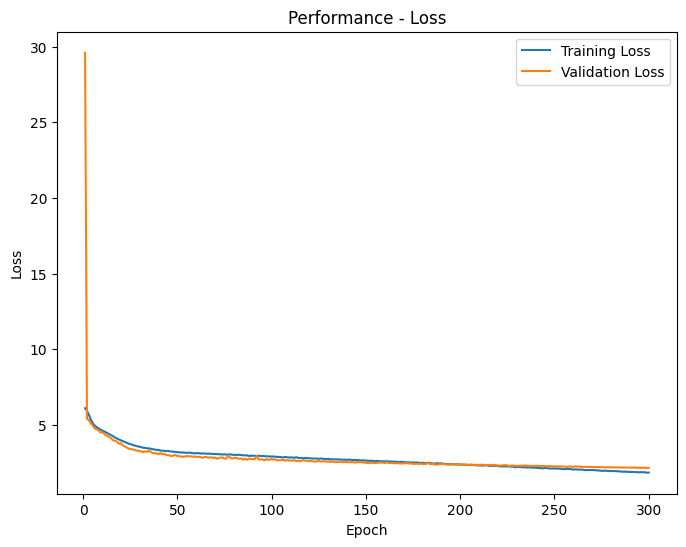

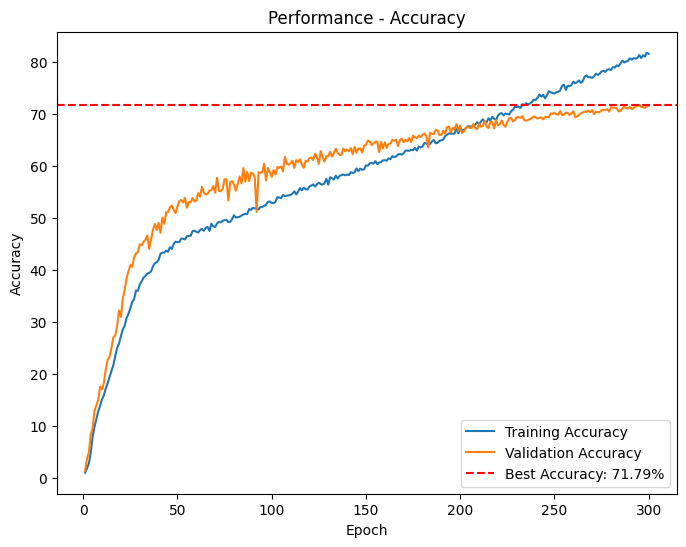

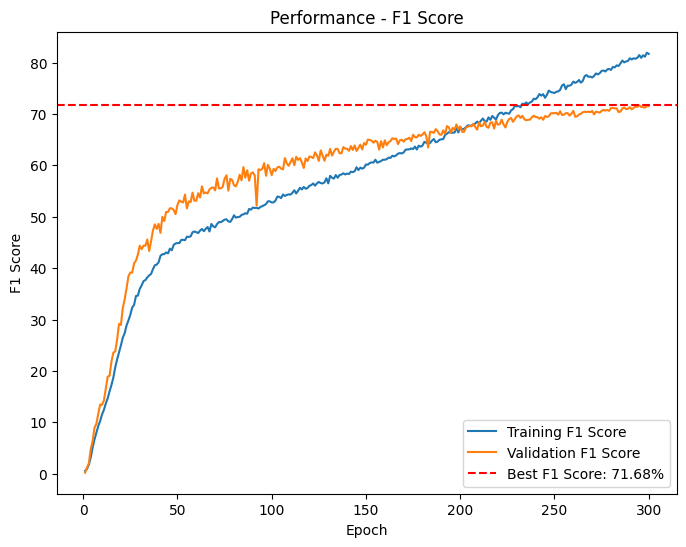

--------------------------------------------------------------------------------

Evaluation...

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] Validation Loss: 2.1583 | Acc: 71.6710% | Weighted F1: 71.5231
Accuracy on Validation set using accuracy_score from sklearn: 71.6709875088381%


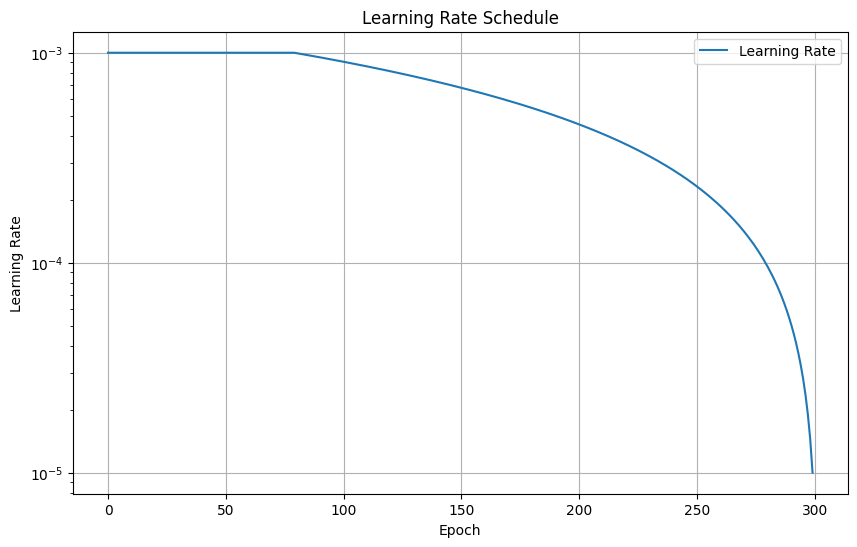

--------------------------------------------------------------------------------
Strating to train EfficientNetB7...
[INFO]: Dataset loaded successfully.
[INFO]: Transforms are Done ..
[INFO]: Number of Training Images: 16971
[INFO]: Number of Validation Images: 4243
[INFO]: Number of Classes: 297

[INFO]: Transforms are Done ..


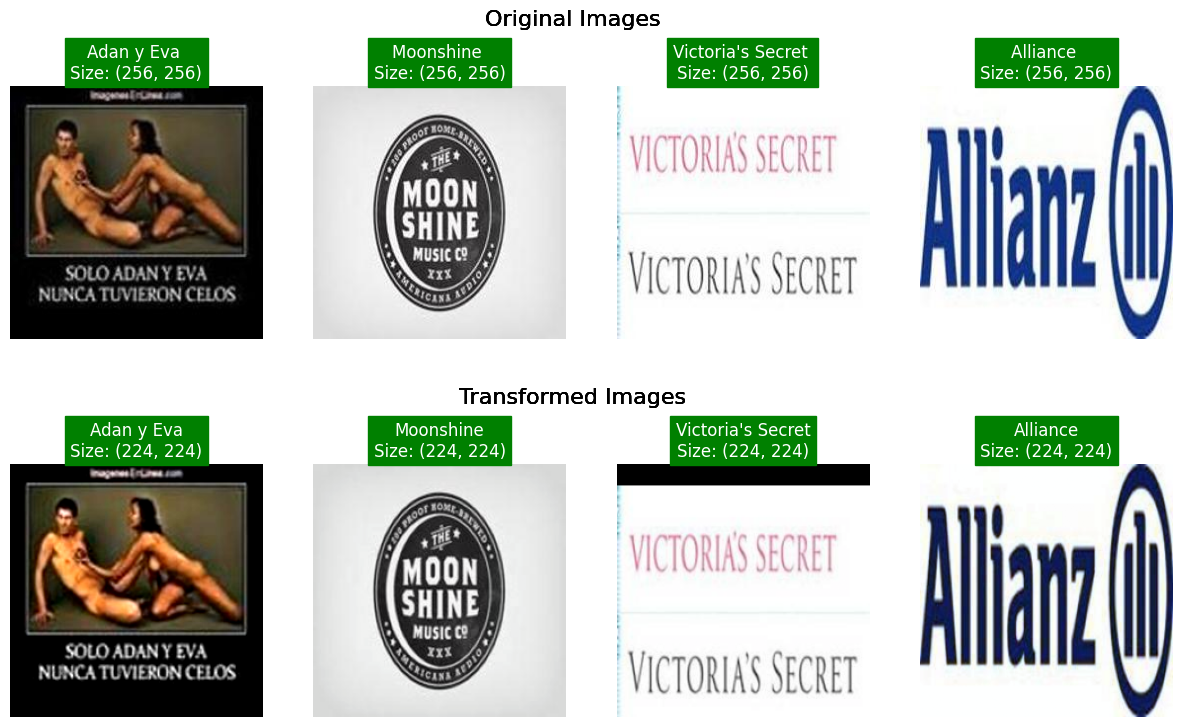

[INFO]: Seed set to: 42 for Python's built-in random module, NumPy and PyTorch.
[INFO]: PyTorch CUDA seeds set to: 42
[INFO]: PyTorch cuDNN deterministic setting set to True for reproducibility.
[INFO]: PyTorch cuDNN benchmark setting set to False for reproducibility.

Model: EfficientNetB7
[INFO]: Number of in_features: 2560
[INFO]: Freezing hidden layers...
[INFO]: Setting Loss Function: CrossEntropyLoss..
[INFO]: Setting Optimizer: Adam..
[INFO]: Setting Scheduler: CustomLRSchedulerModified..

Configuration Settings: {
    "Data_Path": "Datasets/ClothesModified/",
    "Save_To": "models/2024-07-04_9:3/EfficientNetB7",
    "Cross_Validation": false,
    "k_folds": 5,
    "Split_Size": 0.8,
    "Models": [
        "Resnet50",
        "EfficientNetB7",
        "Vgg16",
        "Resnet101"
    ],
    "Fine_Tune": false,
    "Pretrained": true,
    "Num_Epochs": 300,
    "Batch_size": 32,
    "Optimizer": {
        "Name": "Adam",
        "lr": 0.001,
        "weight_decay": 0.001,
     

  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.0634 | Acc: 13.6939% | Weighted F1: 11.2812
[INFO] Validation Loss: 4.3327 | Acc: 24.5581% | Weighted F1: 21.2339
[INFO] Validation loss decreased (inf --> 4.332706).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 2 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.3656 | Acc: 23.6521% | Weighted F1: 21.4978
[INFO] Validation Loss: 4.0743 | Acc: 28.3290% | Weighted F1: 26.7158
[INFO] Validation loss decreased (4.332706 --> 4.074256).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 3 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.0883 | Acc: 27.1286% | Weighted F1: 25.0878
[INFO] Validation Loss: 3.9025 | Acc: 32.3827% | Weighted F1: 29.8011
[INFO] Validation loss decreased (4.074256 --> 3.902490).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 4 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.9477 | Acc: 29.3619% | Weighted F1: 27.2576
[INFO] Validation Loss: 3.8382 | Acc: 32.9484% | Weighted F1: 31.2399
[INFO] Validation loss decreased (3.902490 --> 3.838168).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 5 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.8388 | Acc: 31.3712% | Weighted F1: 29.3780
[INFO] Validation Loss: 3.7342 | Acc: 35.1167% | Weighted F1: 33.0911
[INFO] Validation loss decreased (3.838168 --> 3.734185).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 6 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.7779 | Acc: 32.9326% | Weighted F1: 30.8710
[INFO] Validation Loss: 3.6943 | Acc: 35.8473% | Weighted F1: 33.4287
[INFO] Validation loss decreased (3.734185 --> 3.694281).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 7 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.7296 | Acc: 33.5278% | Weighted F1: 31.4651
[INFO] Validation Loss: 3.6771 | Acc: 36.2951% | Weighted F1: 34.1209
[INFO] Validation loss decreased (3.694281 --> 3.677136).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 8 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.6704 | Acc: 34.8948% | Weighted F1: 32.7439
[INFO] Validation Loss: 3.6614 | Acc: 37.0493% | Weighted F1: 34.8814
[INFO] Validation loss decreased (3.677136 --> 3.661396).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 9 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.6164 | Acc: 35.8494% | Weighted F1: 33.7711
[INFO] Validation Loss: 3.6171 | Acc: 37.8034% | Weighted F1: 35.4499
[INFO] Validation loss decreased (3.661396 --> 3.617083).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 10 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.5656 | Acc: 37.0397% | Weighted F1: 35.1372
[INFO] Validation Loss: 3.6188 | Acc: 38.4162% | Weighted F1: 36.3605
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 11 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.5118 | Acc: 38.3065% | Weighted F1: 36.4647
[INFO] Validation Loss: 3.6199 | Acc: 38.1098% | Weighted F1: 36.7328
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 12 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.4759 | Acc: 38.6660% | Weighted F1: 37.0672
[INFO] Validation Loss: 3.5630 | Acc: 39.7832% | Weighted F1: 38.6262
[INFO] Validation loss decreased (3.617083 --> 3.562976).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 13 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.4526 | Acc: 39.3730% | Weighted F1: 37.8818
[INFO] Validation Loss: 3.5733 | Acc: 39.6653% | Weighted F1: 37.3841
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 14 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3803 | Acc: 40.7637% | Weighted F1: 39.1531
[INFO] Validation Loss: 3.5396 | Acc: 40.4667% | Weighted F1: 39.5223
[INFO] Validation loss decreased (3.562976 --> 3.539622).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 15 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3572 | Acc: 41.1467% | Weighted F1: 39.7855
[INFO] Validation Loss: 3.5924 | Acc: 39.4296% | Weighted F1: 39.5587
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 16 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3376 | Acc: 42.1425% | Weighted F1: 40.9081
[INFO] Validation Loss: 3.5336 | Acc: 41.0323% | Weighted F1: 39.6505
[INFO] Validation loss decreased (3.539622 --> 3.533578).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 17 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3036 | Acc: 42.2898% | Weighted F1: 41.0240
[INFO] Validation Loss: 3.5491 | Acc: 41.0559% | Weighted F1: 39.4538
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 18 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2701 | Acc: 43.8041% | Weighted F1: 42.5914
[INFO] Validation Loss: 3.5052 | Acc: 42.0222% | Weighted F1: 41.0941
[INFO] Validation loss decreased (3.533578 --> 3.505186).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 19 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2563 | Acc: 43.6509% | Weighted F1: 42.4781
[INFO] Validation Loss: 3.4990 | Acc: 41.7158% | Weighted F1: 40.5995
[INFO] Validation loss decreased (3.505186 --> 3.499048).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 20 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2294 | Acc: 44.2520% | Weighted F1: 43.1637
[INFO] Validation Loss: 3.4944 | Acc: 41.4329% | Weighted F1: 40.3976
[INFO] Validation loss decreased (3.499048 --> 3.494438).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 21 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2127 | Acc: 44.4287% | Weighted F1: 43.3348
[INFO] Validation Loss: 3.4621 | Acc: 42.9177% | Weighted F1: 41.9057
[INFO] Validation loss decreased (3.494438 --> 3.462117).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 22 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1825 | Acc: 45.4304% | Weighted F1: 44.4746
[INFO] Validation Loss: 3.4495 | Acc: 43.6012% | Weighted F1: 42.2937
[INFO] Validation loss decreased (3.462117 --> 3.449499).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 23 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1603 | Acc: 45.7899% | Weighted F1: 44.8043
[INFO] Validation Loss: 3.4788 | Acc: 42.2578% | Weighted F1: 41.8828
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 24 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1484 | Acc: 45.9784% | Weighted F1: 45.0753
[INFO] Validation Loss: 3.4595 | Acc: 43.9312% | Weighted F1: 42.3824
[INFO] EarlyStopping counter: 2 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 25 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1304 | Acc: 46.2731% | Weighted F1: 45.3708
[INFO] Validation Loss: 3.4494 | Acc: 43.5070% | Weighted F1: 42.2252
[INFO] Validation loss decreased (3.449499 --> 3.449396).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 26 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1325 | Acc: 46.6089% | Weighted F1: 45.7783
[INFO] Validation Loss: 3.4949 | Acc: 43.0827% | Weighted F1: 42.2457
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 27 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1132 | Acc: 46.6443% | Weighted F1: 45.8589
[INFO] Validation Loss: 3.4366 | Acc: 43.3655% | Weighted F1: 42.3404
[INFO] Validation loss decreased (3.449396 --> 3.436576).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 28 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1109 | Acc: 46.8976% | Weighted F1: 45.9956
[INFO] Validation Loss: 3.4763 | Acc: 43.7426% | Weighted F1: 42.4054
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 29 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0934 | Acc: 47.3278% | Weighted F1: 46.4755
[INFO] Validation Loss: 3.4612 | Acc: 44.3790% | Weighted F1: 43.9219
[INFO] EarlyStopping counter: 2 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 30 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0765 | Acc: 47.7638% | Weighted F1: 47.1119
[INFO] Validation Loss: 3.4198 | Acc: 43.7898% | Weighted F1: 43.0551
[INFO] Validation loss decreased (3.436576 --> 3.419838).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 31 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0705 | Acc: 47.9406% | Weighted F1: 47.2061
[INFO] Validation Loss: 3.4570 | Acc: 43.5541% | Weighted F1: 42.0620
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 32 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0575 | Acc: 48.0643% | Weighted F1: 47.3328
[INFO] Validation Loss: 3.4792 | Acc: 43.4362% | Weighted F1: 42.5631
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 33 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0441 | Acc: 48.4768% | Weighted F1: 47.7514
[INFO] Validation Loss: 3.4968 | Acc: 43.7898% | Weighted F1: 43.3389
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 34 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0305 | Acc: 48.6182% | Weighted F1: 47.9548
[INFO] Validation Loss: 3.4807 | Acc: 44.4025% | Weighted F1: 43.0175
[INFO] EarlyStopping counter: 4 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 35 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0380 | Acc: 48.5475% | Weighted F1: 47.8542
[INFO] Validation Loss: 3.4973 | Acc: 43.7426% | Weighted F1: 42.3282
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 36 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0143 | Acc: 49.6317% | Weighted F1: 48.8686
[INFO] Validation Loss: 3.5961 | Acc: 41.9279% | Weighted F1: 41.3705
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 37 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0152 | Acc: 49.4255% | Weighted F1: 48.7066
[INFO] Validation Loss: 3.4801 | Acc: 43.6955% | Weighted F1: 42.8822
[INFO] EarlyStopping counter: 7 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 38 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0196 | Acc: 49.1309% | Weighted F1: 48.4912
[INFO] Validation Loss: 3.4458 | Acc: 44.1433% | Weighted F1: 43.2357
[INFO] EarlyStopping counter: 8 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 39 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0132 | Acc: 49.1132% | Weighted F1: 48.4326
[INFO] Validation Loss: 3.4559 | Acc: 44.3554% | Weighted F1: 43.3642
[INFO] EarlyStopping counter: 9 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 40 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 2.9930 | Acc: 49.5905% | Weighted F1: 48.9568
[INFO] Validation Loss: 3.5005 | Acc: 44.4025% | Weighted F1: 43.8207
[INFO] EarlyStopping counter: 10 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 41 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 2.9921 | Acc: 49.9735% | Weighted F1: 49.2767
[INFO] Validation Loss: 3.5467 | Acc: 42.6114% | Weighted F1: 42.1457
[INFO] EarlyStopping counter: 11 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 42 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 2.9784 | Acc: 49.8262% | Weighted F1: 49.1702
[INFO] Validation Loss: 3.5215 | Acc: 43.5541% | Weighted F1: 42.6056
[INFO] EarlyStopping counter: 12 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 43 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 2.9864 | Acc: 49.6317% | Weighted F1: 49.0154
[INFO] Validation Loss: 3.4871 | Acc: 43.3891% | Weighted F1: 43.2216
[INFO] EarlyStopping counter: 13 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 44 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 2.9747 | Acc: 50.1267% | Weighted F1: 49.5119
[INFO] Validation Loss: 3.4446 | Acc: 44.0490% | Weighted F1: 43.6845
[INFO] EarlyStopping counter: 14 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 45 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 2.9612 | Acc: 50.3152% | Weighted F1: 49.7710
[INFO] Validation Loss: 3.4446 | Acc: 44.7561% | Weighted F1: 44.1091
[INFO] EarlyStopping counter: 15 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 46 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 2.9512 | Acc: 50.6629% | Weighted F1: 50.0501
[INFO] Validation Loss: 3.4834 | Acc: 43.5777% | Weighted F1: 42.7126
[INFO] EarlyStopping counter: 16 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 47 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 2.9536 | Acc: 50.6806% | Weighted F1: 50.1187
[INFO] Validation Loss: 3.4618 | Acc: 44.1197% | Weighted F1: 43.9871
[INFO] EarlyStopping counter: 17 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 48 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 2.9517 | Acc: 50.6982% | Weighted F1: 50.0687
[INFO] Validation Loss: 3.5145 | Acc: 44.3083% | Weighted F1: 43.1290
[INFO] EarlyStopping counter: 18 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 49 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 2.9321 | Acc: 50.8809% | Weighted F1: 50.3314
[INFO] Validation Loss: 3.4363 | Acc: 45.2274% | Weighted F1: 44.6158
[INFO] EarlyStopping counter: 19 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 50 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 2.9416 | Acc: 50.8338% | Weighted F1: 50.3288
[INFO] Validation Loss: 3.4928 | Acc: 44.3554% | Weighted F1: 43.2773
[INFO] EarlyStopping counter: 20 out of 20
Early stopping....
--------------------------------------------------------------------------------
[INFO] Saving model to: models/2024-07-04_9:3/EfficientNetB7/last_model.pth
TRAINING COMPLETE IN 57m 12s
Best Validation Acc: 45.227433%



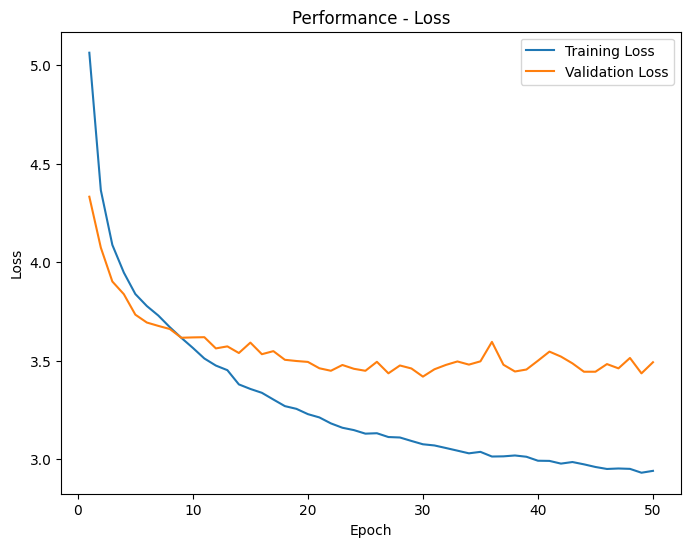

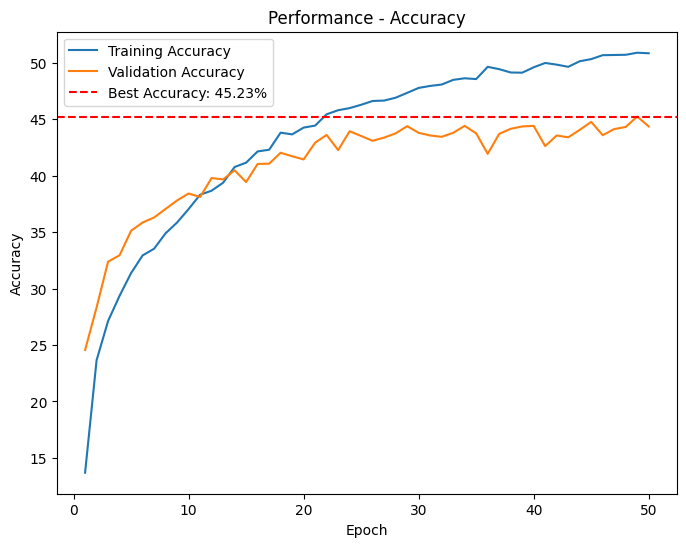

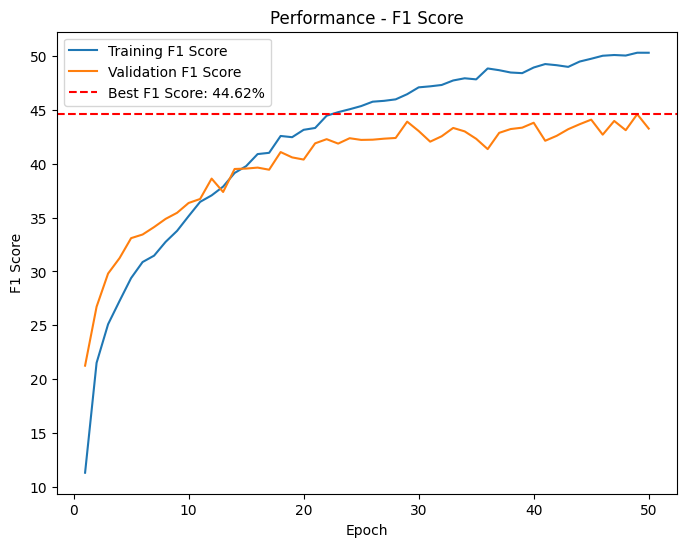

--------------------------------------------------------------------------------

Evaluation...

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] Validation Loss: 3.4928 | Acc: 44.3554% | Weighted F1: 43.2773
Accuracy on Validation set using accuracy_score from sklearn: 44.35540890879095%


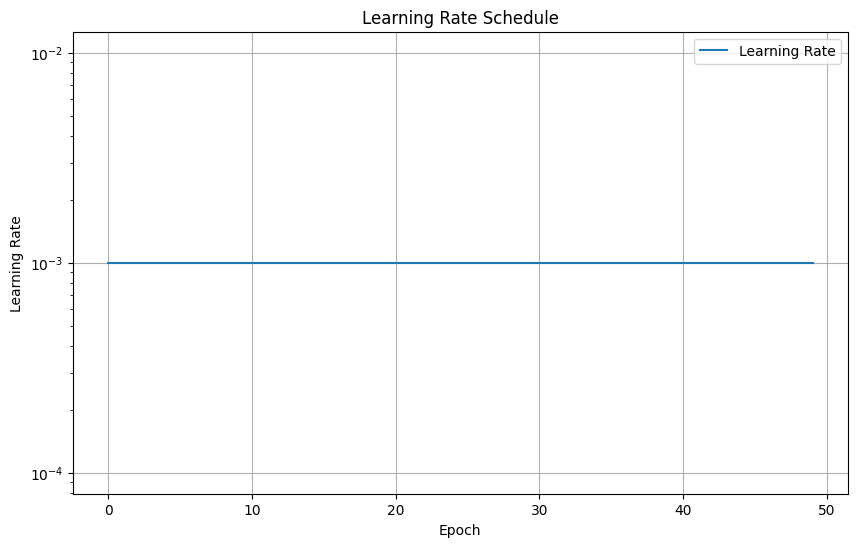

--------------------------------------------------------------------------------
Strating to train Vgg16...
[INFO]: Dataset loaded successfully.
[INFO]: Transforms are Done ..
[INFO]: Number of Training Images: 16971
[INFO]: Number of Validation Images: 4243
[INFO]: Number of Classes: 297

[INFO]: Transforms are Done ..


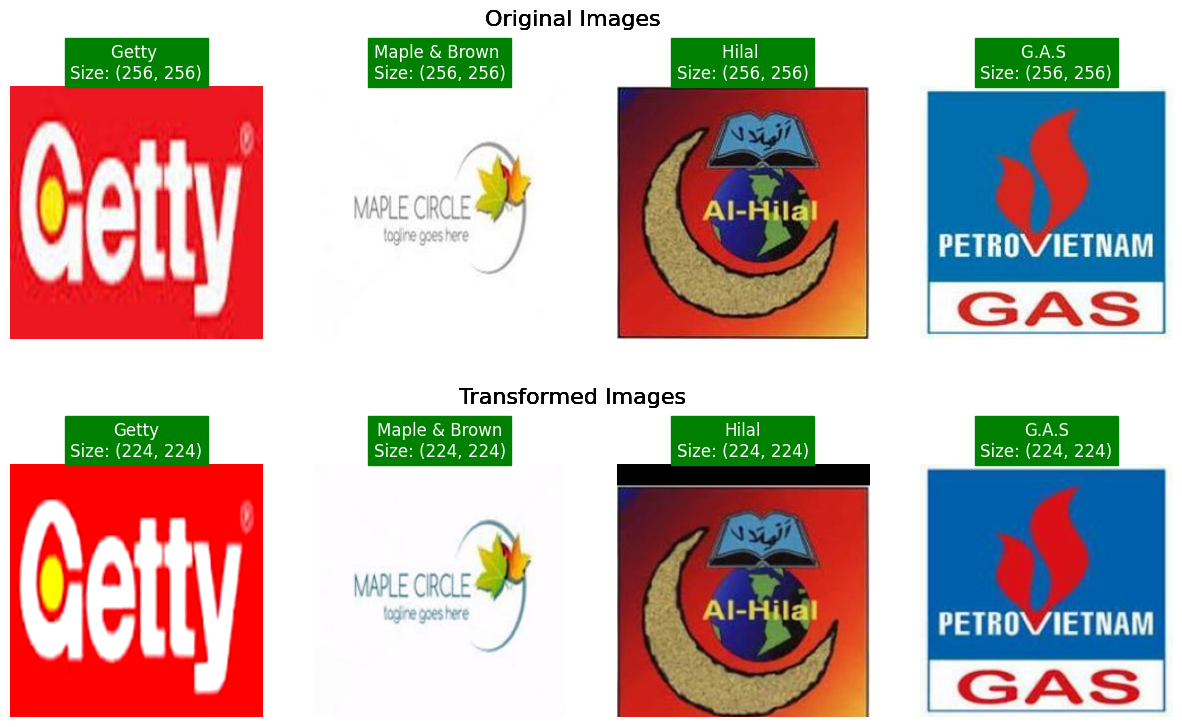

[INFO]: Seed set to: 42 for Python's built-in random module, NumPy and PyTorch.
[INFO]: PyTorch CUDA seeds set to: 42
[INFO]: PyTorch cuDNN deterministic setting set to True for reproducibility.
[INFO]: PyTorch cuDNN benchmark setting set to False for reproducibility.

Model: Vgg16
[INFO]: Number of in_features: 25088
[INFO]: Freezing hidden layers...
[INFO]: Setting Loss Function: CrossEntropyLoss..
[INFO]: Setting Optimizer: Adam..
[INFO]: Setting Scheduler: CustomLRSchedulerModified..

Configuration Settings: {
    "Data_Path": "Datasets/ClothesModified/",
    "Save_To": "models/2024-07-04_9:3/Vgg16",
    "Cross_Validation": false,
    "k_folds": 5,
    "Split_Size": 0.8,
    "Models": [
        "Resnet50",
        "EfficientNetB7",
        "Vgg16",
        "Resnet101"
    ],
    "Fine_Tune": false,
    "Pretrained": true,
    "Num_Epochs": 300,
    "Batch_size": 32,
    "Optimizer": {
        "Name": "Adam",
        "lr": 0.001,
        "weight_decay": 0.001,
        "momentum": 0.

  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.7065 | Acc: 0.6246% | Weighted F1: 0.0785
[INFO] Validation Loss: 5.6935 | Acc: 0.5185% | Weighted F1: 0.0429
[INFO] Validation loss decreased (inf --> 5.693454).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Vgg16/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Vgg16/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 2 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6865 | Acc: 0.7130% | Weighted F1: 0.0534
[INFO] Validation Loss: 5.6958 | Acc: 0.5185% | Weighted F1: 0.0054
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 3 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6833 | Acc: 0.7366% | Weighted F1: 0.0498
[INFO] Validation Loss: 5.6793 | Acc: 0.7542% | Weighted F1: 0.0641
[INFO] Validation loss decreased (5.693454 --> 5.679284).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Vgg16/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Vgg16/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 4 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6804 | Acc: 0.7542% | Weighted F1: 0.0114
[INFO] Validation Loss: 5.6836 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 5 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6798 | Acc: 0.7483% | Weighted F1: 0.0216
[INFO] Validation Loss: 5.6843 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 6 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6797 | Acc: 0.7483% | Weighted F1: 0.0113
[INFO] Validation Loss: 5.6843 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 7 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6855 | Acc: 0.7542% | Weighted F1: 0.0333
[INFO] Validation Loss: 5.6842 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 8 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6771 | Acc: 0.7542% | Weighted F1: 0.0113
[INFO] Validation Loss: 5.6845 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 9 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6831 | Acc: 0.7660% | Weighted F1: 0.0502
[INFO] Validation Loss: 5.6836 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 10 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6798 | Acc: 0.7424% | Weighted F1: 0.0217
[INFO] Validation Loss: 5.7569 | Acc: 0.3771% | Weighted F1: 0.0523
[INFO] EarlyStopping counter: 7 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 11 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6790 | Acc: 0.7483% | Weighted F1: 0.0352
[INFO] Validation Loss: 5.6843 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 8 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 12 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6774 | Acc: 0.7542% | Weighted F1: 0.0181
[INFO] Validation Loss: 5.6847 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 9 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 13 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6810 | Acc: 0.7542% | Weighted F1: 0.0330
[INFO] Validation Loss: 5.6849 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 10 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 14 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6770 | Acc: 0.7542% | Weighted F1: 0.0114
[INFO] Validation Loss: 5.6845 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 11 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 15 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6806 | Acc: 0.7778% | Weighted F1: 0.0474
[INFO] Validation Loss: 5.6842 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 12 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 16 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6760 | Acc: 0.7483% | Weighted F1: 0.0113
[INFO] Validation Loss: 5.6848 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 13 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 17 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6888 | Acc: 0.8014% | Weighted F1: 0.1047
[INFO] Validation Loss: 5.6843 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 14 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 18 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6756 | Acc: 0.7542% | Weighted F1: 0.0212
[INFO] Validation Loss: 5.6860 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 15 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 19 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6869 | Acc: 0.7248% | Weighted F1: 0.0211
[INFO] Validation Loss: 5.6848 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 16 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 20 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6761 | Acc: 0.7542% | Weighted F1: 0.0194
[INFO] Validation Loss: 5.6873 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 17 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 21 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6756 | Acc: 0.7542% | Weighted F1: 0.0113
[INFO] Validation Loss: 5.6846 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 18 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 22 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.7183 | Acc: 0.7130% | Weighted F1: 0.0216
[INFO] Validation Loss: 5.6880 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 19 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 23 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.6794 | Acc: 0.7601% | Weighted F1: 0.0573
[INFO] Validation Loss: 5.6863 | Acc: 0.5185% | Weighted F1: 0.0053
[INFO] EarlyStopping counter: 20 out of 20
Early stopping....
--------------------------------------------------------------------------------
[INFO] Saving model to: models/2024-07-04_9:3/Vgg16/last_model.pth
TRAINING COMPLETE IN 18m 28s
Best Validation Acc: 0.754183%



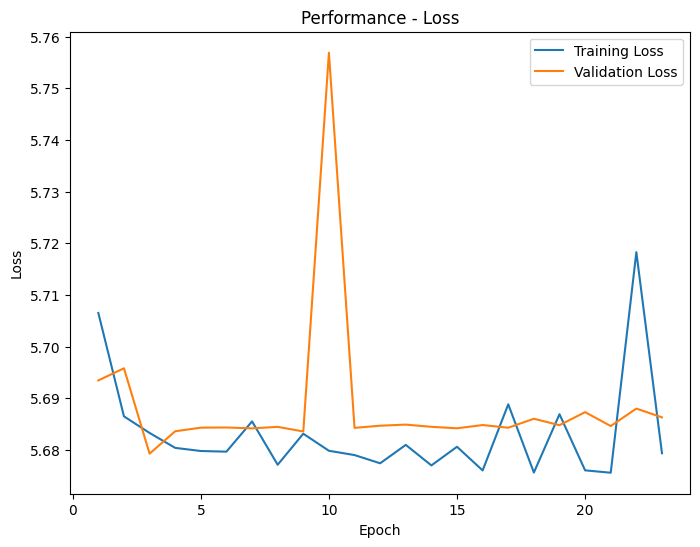

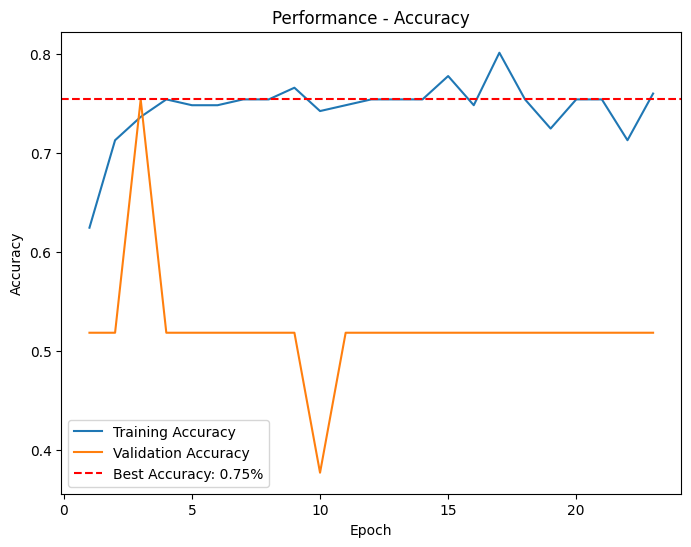

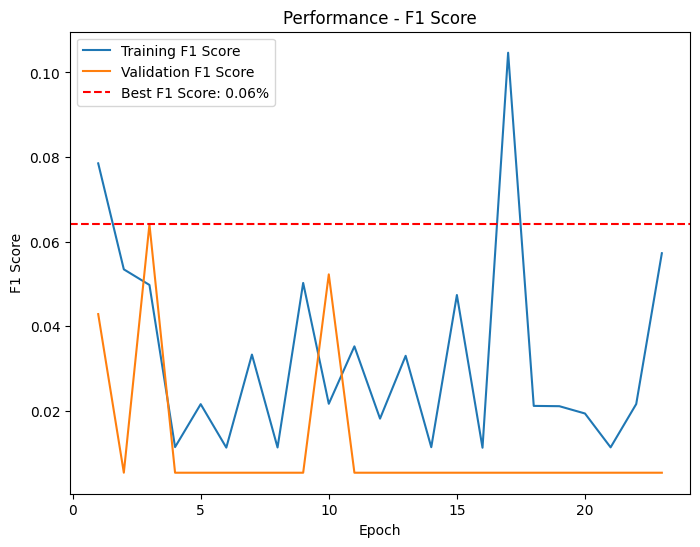

--------------------------------------------------------------------------------

Evaluation...

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] Validation Loss: 5.6863 | Acc: 0.5185% | Weighted F1: 0.0053
Accuracy on Validation set using accuracy_score from sklearn: 0.5185010605703512%


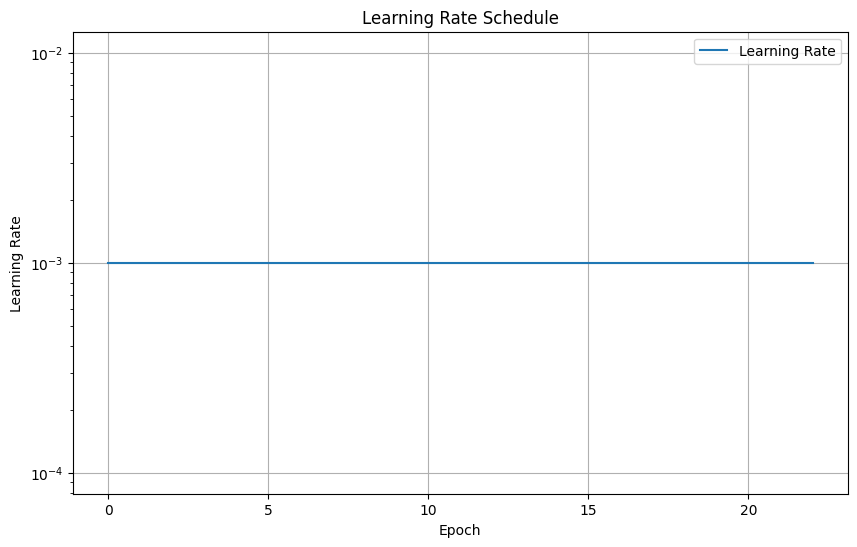

--------------------------------------------------------------------------------
Strating to train Resnet101...
[INFO]: Dataset loaded successfully.
[INFO]: Transforms are Done ..
[INFO]: Number of Training Images: 16971
[INFO]: Number of Validation Images: 4243
[INFO]: Number of Classes: 297

[INFO]: Transforms are Done ..


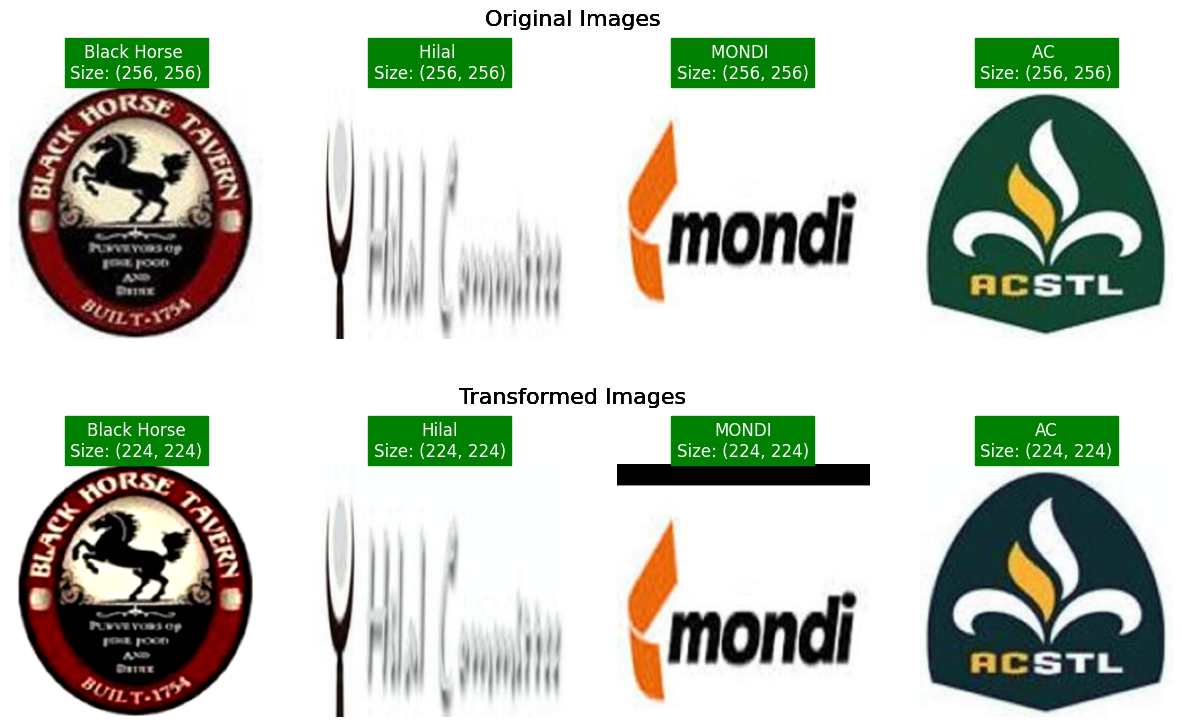

[INFO]: Seed set to: 42 for Python's built-in random module, NumPy and PyTorch.
[INFO]: PyTorch CUDA seeds set to: 42
[INFO]: PyTorch cuDNN deterministic setting set to True for reproducibility.
[INFO]: PyTorch cuDNN benchmark setting set to False for reproducibility.

Model: Resnet101
[INFO]: Number of infeatures:2048
[INFO]: Freezing hidden layers...
[INFO]: Setting Loss Function: CrossEntropyLoss..
[INFO]: Setting Optimizer: Adam..
[INFO]: Setting Scheduler: CustomLRSchedulerModified..

Configuration Settings: {
    "Data_Path": "Datasets/ClothesModified/",
    "Save_To": "models/2024-07-04_9:3/Resnet101",
    "Cross_Validation": false,
    "k_folds": 5,
    "Split_Size": 0.8,
    "Models": [
        "Resnet50",
        "EfficientNetB7",
        "Vgg16",
        "Resnet101"
    ],
    "Fine_Tune": false,
    "Pretrained": true,
    "Num_Epochs": 300,
    "Batch_size": 32,
    "Optimizer": {
        "Name": "Adam",
        "lr": 0.001,
        "weight_decay": 0.001,
        "momentum

  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 6.1466 | Acc: 0.8485% | Weighted F1: 0.4348
[INFO] Validation Loss: 5.7065 | Acc: 1.8855% | Weighted F1: 0.4864
[INFO] Validation loss decreased (inf --> 5.706523).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 2 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.9813 | Acc: 2.1920% | Weighted F1: 1.1289
[INFO] Validation Loss: 1710.8472 | Acc: 1.0841% | Weighted F1: 0.4364
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 3 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.7335 | Acc: 2.8755% | Weighted F1: 1.7440
[INFO] Validation Loss: 5.3050 | Acc: 5.4443% | Weighted F1: 2.3699
[INFO] Validation loss decreased (5.706523 --> 5.304975).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 4 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.4597 | Acc: 4.2249% | Weighted F1: 2.8240
[INFO] Validation Loss: 5.1159 | Acc: 7.4004% | Weighted F1: 4.2620
[INFO] Validation loss decreased (5.304975 --> 5.115907).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 5 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.2419 | Acc: 5.9395% | Weighted F1: 3.7890
[INFO] Validation Loss: 4.9962 | Acc: 10.1815% | Weighted F1: 6.4214
[INFO] Validation loss decreased (5.115907 --> 4.996203).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 6 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.1150 | Acc: 7.3773% | Weighted F1: 4.8037
[INFO] Validation Loss: 4.8684 | Acc: 11.2656% | Weighted F1: 7.7386
[INFO] Validation loss decreased (4.996203 --> 4.868408).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 7 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 5.0077 | Acc: 9.1863% | Weighted F1: 6.0347
[INFO] Validation Loss: 4.7460 | Acc: 14.1645% | Weighted F1: 8.8059
[INFO] Validation loss decreased (4.868408 --> 4.745955).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 8 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.9336 | Acc: 10.1349% | Weighted F1: 6.7332
[INFO] Validation Loss: 4.7422 | Acc: 14.5887% | Weighted F1: 10.2981
[INFO] Validation loss decreased (4.745955 --> 4.742215).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 9 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.8573 | Acc: 11.3723% | Weighted F1: 7.8626
[INFO] Validation Loss: 4.5887 | Acc: 16.6392% | Weighted F1: 11.7519
[INFO] Validation loss decreased (4.742215 --> 4.588726).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 10 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.8073 | Acc: 12.2267% | Weighted F1: 8.6902
[INFO] Validation Loss: 4.5334 | Acc: 17.0398% | Weighted F1: 12.2373
[INFO] Validation loss decreased (4.588726 --> 4.533384).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 11 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.7619 | Acc: 12.9397% | Weighted F1: 9.3030
[INFO] Validation Loss: 4.5423 | Acc: 17.1812% | Weighted F1: 11.8250
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 12 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.7204 | Acc: 13.5643% | Weighted F1: 9.9426
[INFO] Validation Loss: 4.5351 | Acc: 17.2991% | Weighted F1: 12.9451
[INFO] EarlyStopping counter: 2 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 13 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.6794 | Acc: 14.3303% | Weighted F1: 10.7555
[INFO] Validation Loss: 4.4256 | Acc: 18.8074% | Weighted F1: 14.7269
[INFO] Validation loss decreased (4.533384 --> 4.425574).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 14 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.6389 | Acc: 15.0433% | Weighted F1: 11.3665
[INFO] Validation Loss: 4.3953 | Acc: 19.5381% | Weighted F1: 15.0916
[INFO] Validation loss decreased (4.425574 --> 4.395270).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 15 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.5740 | Acc: 16.2395% | Weighted F1: 12.7419
[INFO] Validation Loss: 4.3680 | Acc: 19.4674% | Weighted F1: 15.5139
[INFO] Validation loss decreased (4.395270 --> 4.368015).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 16 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.5338 | Acc: 16.8582% | Weighted F1: 13.3485
[INFO] Validation Loss: 4.3494 | Acc: 21.7063% | Weighted F1: 17.3483
[INFO] Validation loss decreased (4.368015 --> 4.349365).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 17 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.4974 | Acc: 17.1587% | Weighted F1: 13.7453
[INFO] Validation Loss: 4.2621 | Acc: 22.0834% | Weighted F1: 18.6974
[INFO] Validation loss decreased (4.349365 --> 4.262059).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 18 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.4451 | Acc: 18.2547% | Weighted F1: 14.9658
[INFO] Validation Loss: 4.2112 | Acc: 23.7096% | Weighted F1: 19.4866
[INFO] Validation loss decreased (4.262059 --> 4.211168).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 19 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.3868 | Acc: 19.0973% | Weighted F1: 15.7348
[INFO] Validation Loss: 4.1235 | Acc: 24.9823% | Weighted F1: 21.0212
[INFO] Validation loss decreased (4.211168 --> 4.123548).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 20 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.3196 | Acc: 20.2758% | Weighted F1: 17.1821
[INFO] Validation Loss: 4.0761 | Acc: 25.8308% | Weighted F1: 22.0586
[INFO] Validation loss decreased (4.123548 --> 4.076078).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 21 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.2566 | Acc: 21.8549% | Weighted F1: 18.8466
[INFO] Validation Loss: 4.0155 | Acc: 26.3493% | Weighted F1: 22.5609
[INFO] Validation loss decreased (4.076078 --> 4.015506).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 22 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.1868 | Acc: 22.9450% | Weighted F1: 20.0915
[INFO] Validation Loss: 3.9197 | Acc: 29.1775% | Weighted F1: 26.5708
[INFO] Validation loss decreased (4.015506 --> 3.919657).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 23 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.1279 | Acc: 23.9762% | Weighted F1: 21.3918
[INFO] Validation Loss: 3.9051 | Acc: 28.2583% | Weighted F1: 24.4717
[INFO] Validation loss decreased (3.919657 --> 3.905052).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 24 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.0852 | Acc: 25.2843% | Weighted F1: 22.8692
[INFO] Validation Loss: 3.7468 | Acc: 32.6656% | Weighted F1: 29.9299
[INFO] Validation loss decreased (3.905052 --> 3.746809).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 25 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 4.0284 | Acc: 26.8929% | Weighted F1: 24.6996
[INFO] Validation Loss: 3.7021 | Acc: 34.1268% | Weighted F1: 31.3468
[INFO] Validation loss decreased (3.746809 --> 3.702095).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 26 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.9638 | Acc: 27.8946% | Weighted F1: 25.8598
[INFO] Validation Loss: 3.7096 | Acc: 33.0898% | Weighted F1: 30.3674
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 27 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.9181 | Acc: 28.7255% | Weighted F1: 26.7866
[INFO] Validation Loss: 3.7199 | Acc: 33.2783% | Weighted F1: 31.8886
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 28 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.8654 | Acc: 29.9747% | Weighted F1: 28.3169
[INFO] Validation Loss: 3.6102 | Acc: 35.1874% | Weighted F1: 33.2756
[INFO] Validation loss decreased (3.702095 --> 3.610163).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 29 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.8184 | Acc: 31.1473% | Weighted F1: 29.3964
[INFO] Validation Loss: 3.5688 | Acc: 37.1907% | Weighted F1: 35.8327
[INFO] Validation loss decreased (3.610163 --> 3.568849).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 30 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.7765 | Acc: 31.8543% | Weighted F1: 30.1999
[INFO] Validation Loss: 3.4968 | Acc: 38.6519% | Weighted F1: 36.5118
[INFO] Validation loss decreased (3.568849 --> 3.496750).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 31 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.7385 | Acc: 33.0034% | Weighted F1: 31.5403
[INFO] Validation Loss: 3.5164 | Acc: 38.1334% | Weighted F1: 36.8583
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 32 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.6983 | Acc: 34.2702% | Weighted F1: 32.8120
[INFO] Validation Loss: 3.4508 | Acc: 39.4296% | Weighted F1: 37.8194
[INFO] Validation loss decreased (3.496750 --> 3.450793).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 33 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.6623 | Acc: 34.7888% | Weighted F1: 33.4540
[INFO] Validation Loss: 3.4292 | Acc: 41.1030% | Weighted F1: 40.2785
[INFO] Validation loss decreased (3.450793 --> 3.429250).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 34 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.6364 | Acc: 35.1659% | Weighted F1: 33.9159
[INFO] Validation Loss: 3.4724 | Acc: 38.2512% | Weighted F1: 37.4443
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 35 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.6142 | Acc: 35.9260% | Weighted F1: 34.7716
[INFO] Validation Loss: 3.3712 | Acc: 41.8572% | Weighted F1: 40.8478
[INFO] Validation loss decreased (3.429250 --> 3.371206).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 36 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.5765 | Acc: 36.9689% | Weighted F1: 35.8167
[INFO] Validation Loss: 3.2778 | Acc: 43.8605% | Weighted F1: 43.8376
[INFO] Validation loss decreased (3.371206 --> 3.277797).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 37 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.5601 | Acc: 37.4403% | Weighted F1: 36.4196
[INFO] Validation Loss: 3.2322 | Acc: 44.5675% | Weighted F1: 44.1331
[INFO] Validation loss decreased (3.277797 --> 3.232161).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 38 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.5143 | Acc: 38.1474% | Weighted F1: 37.1263
[INFO] Validation Loss: 3.3292 | Acc: 43.7426% | Weighted F1: 44.1071
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 39 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.5146 | Acc: 38.2476% | Weighted F1: 37.3111
[INFO] Validation Loss: 3.2435 | Acc: 45.7931% | Weighted F1: 45.1818
[INFO] EarlyStopping counter: 2 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 40 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.4795 | Acc: 39.2552% | Weighted F1: 38.4179
[INFO] Validation Loss: 3.1852 | Acc: 46.7829% | Weighted F1: 45.7625
[INFO] Validation loss decreased (3.232161 --> 3.185250).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 41 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.4588 | Acc: 40.0801% | Weighted F1: 39.2098
[INFO] Validation Loss: 3.1684 | Acc: 47.3721% | Weighted F1: 47.4340
[INFO] Validation loss decreased (3.185250 --> 3.168429).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 42 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.4317 | Acc: 40.4514% | Weighted F1: 39.7368
[INFO] Validation Loss: 3.0995 | Acc: 47.9142% | Weighted F1: 47.2823
[INFO] Validation loss decreased (3.168429 --> 3.099466).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 43 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.4023 | Acc: 41.0052% | Weighted F1: 40.2554
[INFO] Validation Loss: 3.1359 | Acc: 47.9378% | Weighted F1: 47.2566
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 44 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3909 | Acc: 41.5886% | Weighted F1: 40.9669
[INFO] Validation Loss: 3.0300 | Acc: 51.0959% | Weighted F1: 50.3958
[INFO] Validation loss decreased (3.099466 --> 3.029951).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 45 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3707 | Acc: 41.8832% | Weighted F1: 41.2551
[INFO] Validation Loss: 3.0592 | Acc: 50.0825% | Weighted F1: 49.2823
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 46 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3649 | Acc: 42.0836% | Weighted F1: 41.4622
[INFO] Validation Loss: 3.1502 | Acc: 48.3384% | Weighted F1: 47.8814
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 47 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3351 | Acc: 42.9438% | Weighted F1: 42.3137
[INFO] Validation Loss: 2.9745 | Acc: 51.9679% | Weighted F1: 51.2657
[INFO] Validation loss decreased (3.029951 --> 2.974456).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 48 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3068 | Acc: 43.5154% | Weighted F1: 43.0180
[INFO] Validation Loss: 3.0494 | Acc: 50.4124% | Weighted F1: 49.8979
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 49 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.3164 | Acc: 42.9792% | Weighted F1: 42.5363
[INFO] Validation Loss: 2.9966 | Acc: 51.4730% | Weighted F1: 51.7911
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 50 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2895 | Acc: 43.8866% | Weighted F1: 43.2851
[INFO] Validation Loss: 3.0037 | Acc: 51.4259% | Weighted F1: 51.7062
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 51 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2850 | Acc: 43.9514% | Weighted F1: 43.5170
[INFO] Validation Loss: 2.9300 | Acc: 53.5942% | Weighted F1: 53.2177
[INFO] Validation loss decreased (2.974456 --> 2.929994).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 52 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2672 | Acc: 44.8353% | Weighted F1: 44.2720
[INFO] Validation Loss: 2.9292 | Acc: 53.5235% | Weighted F1: 52.9783
[INFO] Validation loss decreased (2.929994 --> 2.929249).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 53 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2433 | Acc: 45.0710% | Weighted F1: 44.5327
[INFO] Validation Loss: 3.0240 | Acc: 51.0724% | Weighted F1: 51.3374
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 54 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2448 | Acc: 44.9355% | Weighted F1: 44.4507
[INFO] Validation Loss: 3.0097 | Acc: 51.2373% | Weighted F1: 50.8515
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 55 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2167 | Acc: 45.6720% | Weighted F1: 45.2674
[INFO] Validation Loss: 2.9069 | Acc: 54.6547% | Weighted F1: 54.2615
[INFO] Validation loss decreased (2.929249 --> 2.906908).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 56 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2257 | Acc: 45.6544% | Weighted F1: 45.2491
[INFO] Validation Loss: 2.9705 | Acc: 52.2743% | Weighted F1: 52.0737
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 57 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2157 | Acc: 45.8429% | Weighted F1: 45.4788
[INFO] Validation Loss: 2.8610 | Acc: 55.4089% | Weighted F1: 54.8403
[INFO] Validation loss decreased (2.906908 --> 2.861037).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 58 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2078 | Acc: 46.3143% | Weighted F1: 46.0383
[INFO] Validation Loss: 2.9037 | Acc: 54.4662% | Weighted F1: 54.5564
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 59 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.2048 | Acc: 46.2082% | Weighted F1: 45.8486
[INFO] Validation Loss: 3.0602 | Acc: 50.7424% | Weighted F1: 51.0890
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 60 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1847 | Acc: 46.3497% | Weighted F1: 46.0056
[INFO] Validation Loss: 2.9329 | Acc: 53.5706% | Weighted F1: 53.3262
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 61 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1646 | Acc: 46.8800% | Weighted F1: 46.5157
[INFO] Validation Loss: 2.9139 | Acc: 53.4999% | Weighted F1: 54.0286
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 62 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1778 | Acc: 46.9153% | Weighted F1: 46.5663
[INFO] Validation Loss: 2.8689 | Acc: 54.3012% | Weighted F1: 53.7453
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 63 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1668 | Acc: 47.2099% | Weighted F1: 46.8679
[INFO] Validation Loss: 2.8370 | Acc: 56.3045% | Weighted F1: 56.1586
[INFO] Validation loss decreased (2.861037 --> 2.836965).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 64 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1568 | Acc: 47.1864% | Weighted F1: 46.8841
[INFO] Validation Loss: 2.8346 | Acc: 55.5975% | Weighted F1: 55.5788
[INFO] Validation loss decreased (2.836965 --> 2.834564).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 65 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1390 | Acc: 47.7403% | Weighted F1: 47.3979
[INFO] Validation Loss: 2.8463 | Acc: 55.2439% | Weighted F1: 54.7800
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 66 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1336 | Acc: 47.4280% | Weighted F1: 47.2463
[INFO] Validation Loss: 2.8914 | Acc: 54.6076% | Weighted F1: 54.8840
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 67 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1194 | Acc: 48.2588% | Weighted F1: 47.9294
[INFO] Validation Loss: 2.8597 | Acc: 55.0554% | Weighted F1: 54.8726
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 68 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1381 | Acc: 47.8758% | Weighted F1: 47.7023
[INFO] Validation Loss: 2.8166 | Acc: 55.6682% | Weighted F1: 55.1636
[INFO] Validation loss decreased (2.834564 --> 2.816604).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 69 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1172 | Acc: 48.1527% | Weighted F1: 47.8465
[INFO] Validation Loss: 2.8470 | Acc: 56.3045% | Weighted F1: 55.9015
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 70 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1257 | Acc: 48.0820% | Weighted F1: 47.8165
[INFO] Validation Loss: 2.9525 | Acc: 53.4056% | Weighted F1: 54.1465
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 71 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1063 | Acc: 48.5416% | Weighted F1: 48.3485
[INFO] Validation Loss: 2.8782 | Acc: 54.7961% | Weighted F1: 55.1471
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 72 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0780 | Acc: 48.9895% | Weighted F1: 48.8387
[INFO] Validation Loss: 2.8600 | Acc: 55.3382% | Weighted F1: 55.6031
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 73 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.1167 | Acc: 48.2706% | Weighted F1: 47.9974
[INFO] Validation Loss: 2.8014 | Acc: 57.2001% | Weighted F1: 57.2093
[INFO] Validation loss decreased (2.816604 --> 2.801383).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 74 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0863 | Acc: 48.5770% | Weighted F1: 48.4063
[INFO] Validation Loss: 2.8088 | Acc: 56.7052% | Weighted F1: 57.0011
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 75 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0974 | Acc: 48.9129% | Weighted F1: 48.7770
[INFO] Validation Loss: 2.7850 | Acc: 57.6715% | Weighted F1: 57.4914
[INFO] Validation loss decreased (2.801383 --> 2.785005).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 76 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0877 | Acc: 49.3371% | Weighted F1: 49.1803
[INFO] Validation Loss: 2.7712 | Acc: 57.2472% | Weighted F1: 57.1469
[INFO] Validation loss decreased (2.785005 --> 2.771186).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 77 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0841 | Acc: 48.9364% | Weighted F1: 48.8685
[INFO] Validation Loss: 2.7254 | Acc: 57.6243% | Weighted F1: 57.6425
[INFO] Validation loss decreased (2.771186 --> 2.725384).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 78 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0669 | Acc: 49.5905% | Weighted F1: 49.4198
[INFO] Validation Loss: 2.7777 | Acc: 56.4459% | Weighted F1: 56.2275
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 79 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0680 | Acc: 49.1839% | Weighted F1: 49.0804
[INFO] Validation Loss: 2.7572 | Acc: 57.2944% | Weighted F1: 57.4697
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 80 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.001
[INFO] LR: 0.001
[INFO] Training Loss: 3.0968 | Acc: 48.5240% | Weighted F1: 48.4147
[INFO] Validation Loss: 2.7827 | Acc: 57.5065% | Weighted F1: 57.9330
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 81 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009955
[INFO] LR: 0.0009955
[INFO] Training Loss: 3.0436 | Acc: 50.3977% | Weighted F1: 50.1943
[INFO] Validation Loss: 2.8231 | Acc: 56.4459% | Weighted F1: 56.5828
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 82 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009910000000000001
[INFO] LR: 0.0009910000000000001
[INFO] Training Loss: 3.0556 | Acc: 49.5787% | Weighted F1: 49.4087
[INFO] Validation Loss: 2.7731 | Acc: 57.6243% | Weighted F1: 56.9556
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 83 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009865
[INFO] LR: 0.0009865
[INFO] Training Loss: 3.0362 | Acc: 50.6393% | Weighted F1: 50.5487
[INFO] Validation Loss: 2.7308 | Acc: 58.0957% | Weighted F1: 58.3871
[INFO] EarlyStopping counter: 6 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 84 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000982
[INFO] LR: 0.000982
[INFO] Training Loss: 3.0310 | Acc: 50.2799% | Weighted F1: 50.1930
[INFO] Validation Loss: 2.7374 | Acc: 58.1428% | Weighted F1: 58.1323
[INFO] EarlyStopping counter: 7 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 85 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009775
[INFO] LR: 0.0009775
[INFO] Training Loss: 3.0507 | Acc: 49.8026% | Weighted F1: 49.6840
[INFO] Validation Loss: 2.7443 | Acc: 58.1428% | Weighted F1: 58.5132
[INFO] EarlyStopping counter: 8 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 86 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000973
[INFO] LR: 0.000973
[INFO] Training Loss: 3.0260 | Acc: 50.4626% | Weighted F1: 50.3501
[INFO] Validation Loss: 2.7351 | Acc: 58.4021% | Weighted F1: 58.2592
[INFO] EarlyStopping counter: 9 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 87 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009685000000000001
[INFO] LR: 0.0009685000000000001
[INFO] Training Loss: 3.0113 | Acc: 51.0164% | Weighted F1: 50.8729
[INFO] Validation Loss: 2.7386 | Acc: 58.3314% | Weighted F1: 58.9341
[INFO] EarlyStopping counter: 10 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 88 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000964
[INFO] LR: 0.000964
[INFO] Training Loss: 2.9929 | Acc: 51.3641% | Weighted F1: 51.3175
[INFO] Validation Loss: 2.7003 | Acc: 59.7455% | Weighted F1: 59.6875
[INFO] Validation loss decreased (2.725384 --> 2.700324).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 89 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009595000000000001
[INFO] LR: 0.0009595000000000001
[INFO] Training Loss: 3.0193 | Acc: 50.7690% | Weighted F1: 50.6783
[INFO] Validation Loss: 2.7651 | Acc: 57.5300% | Weighted F1: 57.5912
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 90 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000955
[INFO] LR: 0.000955
[INFO] Training Loss: 3.0044 | Acc: 51.2227% | Weighted F1: 51.1016
[INFO] Validation Loss: 2.8117 | Acc: 56.9173% | Weighted F1: 57.5672
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 91 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009505000000000001
[INFO] LR: 0.0009505000000000001
[INFO] Training Loss: 2.9796 | Acc: 51.9121% | Weighted F1: 51.8923
[INFO] Validation Loss: 2.7107 | Acc: 58.9206% | Weighted F1: 59.0732
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 92 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000946
[INFO] LR: 0.000946
[INFO] Training Loss: 2.9883 | Acc: 51.6351% | Weighted F1: 51.4964
[INFO] Validation Loss: 2.6679 | Acc: 60.3582% | Weighted F1: 60.4097
[INFO] Validation loss decreased (2.700324 --> 2.667906).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 93 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009415000000000001
[INFO] LR: 0.0009415000000000001
[INFO] Training Loss: 2.9867 | Acc: 51.5939% | Weighted F1: 51.5173
[INFO] Validation Loss: 2.6899 | Acc: 58.4492% | Weighted F1: 58.7250
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 94 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000937
[INFO] LR: 0.000937
[INFO] Training Loss: 2.9817 | Acc: 51.5762% | Weighted F1: 51.5053
[INFO] Validation Loss: 2.6813 | Acc: 59.9104% | Weighted F1: 59.9266
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 95 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009325000000000001
[INFO] LR: 0.0009325000000000001
[INFO] Training Loss: 2.9590 | Acc: 52.3128% | Weighted F1: 52.2512
[INFO] Validation Loss: 2.6504 | Acc: 60.0047% | Weighted F1: 60.1330
[INFO] Validation loss decreased (2.667906 --> 2.650447).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 96 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000928
[INFO] LR: 0.000928
[INFO] Training Loss: 2.9655 | Acc: 52.1242% | Weighted F1: 52.1034
[INFO] Validation Loss: 2.6431 | Acc: 60.7118% | Weighted F1: 61.0706
[INFO] Validation loss decreased (2.650447 --> 2.643132).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 97 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009235000000000001
[INFO] LR: 0.0009235000000000001
[INFO] Training Loss: 2.9494 | Acc: 52.2951% | Weighted F1: 52.2958
[INFO] Validation Loss: 2.7089 | Acc: 59.1563% | Weighted F1: 59.1169
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 98 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000919
[INFO] LR: 0.000919
[INFO] Training Loss: 2.9444 | Acc: 52.4660% | Weighted F1: 52.4250
[INFO] Validation Loss: 2.7042 | Acc: 58.7792% | Weighted F1: 58.4550
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 99 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009145000000000001
[INFO] LR: 0.0009145000000000001
[INFO] Training Loss: 2.9492 | Acc: 52.8195% | Weighted F1: 52.8182
[INFO] Validation Loss: 2.7010 | Acc: 58.2371% | Weighted F1: 58.2101
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 100 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00091
[INFO] LR: 0.00091
[INFO] Training Loss: 2.9512 | Acc: 52.5956% | Weighted F1: 52.6142
[INFO] Validation Loss: 2.6774 | Acc: 60.0990% | Weighted F1: 59.9633
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 101 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0009055000000000001
[INFO] LR: 0.0009055000000000001
[INFO] Training Loss: 2.9370 | Acc: 53.2143% | Weighted F1: 53.1533
[INFO] Validation Loss: 2.6569 | Acc: 60.0519% | Weighted F1: 59.7964
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 102 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000901
[INFO] LR: 0.000901
[INFO] Training Loss: 2.9325 | Acc: 53.1436% | Weighted F1: 53.0815
[INFO] Validation Loss: 2.6838 | Acc: 59.4391% | Weighted F1: 59.7550
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 103 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008965
[INFO] LR: 0.0008965
[INFO] Training Loss: 2.9219 | Acc: 52.8784% | Weighted F1: 52.9036
[INFO] Validation Loss: 2.6309 | Acc: 61.1831% | Weighted F1: 61.3710
[INFO] Validation loss decreased (2.643132 --> 2.630946).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 104 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000892
[INFO] LR: 0.000892
[INFO] Training Loss: 2.9061 | Acc: 53.5973% | Weighted F1: 53.4623
[INFO] Validation Loss: 2.6680 | Acc: 59.8869% | Weighted F1: 59.7333
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 105 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008875
[INFO] LR: 0.0008875
[INFO] Training Loss: 2.9011 | Acc: 53.6503% | Weighted F1: 53.6263
[INFO] Validation Loss: 2.6771 | Acc: 59.0384% | Weighted F1: 59.4281
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 106 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000883
[INFO] LR: 0.000883
[INFO] Training Loss: 2.9057 | Acc: 53.9685% | Weighted F1: 53.8961
[INFO] Validation Loss: 2.6563 | Acc: 60.6882% | Weighted F1: 60.5704
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 107 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008785
[INFO] LR: 0.0008785
[INFO] Training Loss: 2.8883 | Acc: 54.3044% | Weighted F1: 54.3817
[INFO] Validation Loss: 2.6479 | Acc: 59.8162% | Weighted F1: 59.9918
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 108 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000874
[INFO] LR: 0.000874
[INFO] Training Loss: 2.8871 | Acc: 53.9155% | Weighted F1: 53.9394
[INFO] Validation Loss: 2.6328 | Acc: 60.1461% | Weighted F1: 60.0166
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 109 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008695
[INFO] LR: 0.0008695
[INFO] Training Loss: 2.8698 | Acc: 54.3280% | Weighted F1: 54.2907
[INFO] Validation Loss: 2.6543 | Acc: 60.2640% | Weighted F1: 60.7925
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 110 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000865
[INFO] LR: 0.000865
[INFO] Training Loss: 2.8762 | Acc: 54.1571% | Weighted F1: 54.2504
[INFO] Validation Loss: 2.6198 | Acc: 61.0417% | Weighted F1: 62.1626
[INFO] Validation loss decreased (2.630946 --> 2.619794).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 111 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008605
[INFO] LR: 0.0008605
[INFO] Training Loss: 2.8756 | Acc: 54.0628% | Weighted F1: 53.9461
[INFO] Validation Loss: 2.6027 | Acc: 61.0181% | Weighted F1: 60.7826
[INFO] Validation loss decreased (2.619794 --> 2.602692).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 112 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000856
[INFO] LR: 0.000856
[INFO] Training Loss: 2.8630 | Acc: 54.4576% | Weighted F1: 54.4780
[INFO] Validation Loss: 2.5905 | Acc: 61.6545% | Weighted F1: 61.4378
[INFO] Validation loss decreased (2.602692 --> 2.590549).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 113 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008515
[INFO] LR: 0.0008515
[INFO] Training Loss: 2.8710 | Acc: 54.3221% | Weighted F1: 54.2887
[INFO] Validation Loss: 2.5926 | Acc: 60.9474% | Weighted F1: 61.0356
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 114 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000847
[INFO] LR: 0.000847
[INFO] Training Loss: 2.8443 | Acc: 54.6815% | Weighted F1: 54.7613
[INFO] Validation Loss: 2.6175 | Acc: 60.9474% | Weighted F1: 60.9986
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 115 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008425
[INFO] LR: 0.0008425
[INFO] Training Loss: 2.8436 | Acc: 55.1234% | Weighted F1: 55.1150
[INFO] Validation Loss: 2.7133 | Acc: 58.6849% | Weighted F1: 58.6631
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 116 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000838
[INFO] LR: 0.000838
[INFO] Training Loss: 2.8346 | Acc: 55.4004% | Weighted F1: 55.3677
[INFO] Validation Loss: 2.6130 | Acc: 60.8296% | Weighted F1: 60.9594
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 117 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008335
[INFO] LR: 0.0008335
[INFO] Training Loss: 2.8421 | Acc: 54.9938% | Weighted F1: 54.9990
[INFO] Validation Loss: 2.5635 | Acc: 62.1494% | Weighted F1: 62.3869
[INFO] Validation loss decreased (2.590549 --> 2.563466).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 118 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000829
[INFO] LR: 0.000829
[INFO] Training Loss: 2.8182 | Acc: 55.7657% | Weighted F1: 55.7979
[INFO] Validation Loss: 2.5597 | Acc: 62.8800% | Weighted F1: 62.6267
[INFO] Validation loss decreased (2.563466 --> 2.559685).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 119 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008245
[INFO] LR: 0.0008245
[INFO] Training Loss: 2.8295 | Acc: 55.4122% | Weighted F1: 55.4566
[INFO] Validation Loss: 2.6216 | Acc: 60.8060% | Weighted F1: 61.6687
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 120 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00082
[INFO] LR: 0.00082
[INFO] Training Loss: 2.8028 | Acc: 56.5258% | Weighted F1: 56.5450
[INFO] Validation Loss: 2.5954 | Acc: 61.8430% | Weighted F1: 62.0393
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 121 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008155
[INFO] LR: 0.0008155
[INFO] Training Loss: 2.8289 | Acc: 55.7657% | Weighted F1: 55.8714
[INFO] Validation Loss: 2.5933 | Acc: 61.7959% | Weighted F1: 62.3347
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 122 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008110000000000001
[INFO] LR: 0.0008110000000000001
[INFO] Training Loss: 2.8199 | Acc: 55.9543% | Weighted F1: 55.9455
[INFO] Validation Loss: 2.5567 | Acc: 62.8565% | Weighted F1: 62.9748
[INFO] Validation loss decreased (2.559685 --> 2.556708).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 123 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0008065
[INFO] LR: 0.0008065
[INFO] Training Loss: 2.8087 | Acc: 56.1075% | Weighted F1: 56.1372
[INFO] Validation Loss: 2.5693 | Acc: 63.0686% | Weighted F1: 63.8513
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 124 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000802
[INFO] LR: 0.000802
[INFO] Training Loss: 2.7922 | Acc: 56.4610% | Weighted F1: 56.5827
[INFO] Validation Loss: 2.5397 | Acc: 63.1157% | Weighted F1: 63.2422
[INFO] Validation loss decreased (2.556708 --> 2.539657).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 125 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007975
[INFO] LR: 0.0007975
[INFO] Training Loss: 2.7895 | Acc: 56.4964% | Weighted F1: 56.6016
[INFO] Validation Loss: 2.6048 | Acc: 61.7252% | Weighted F1: 61.8007
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 126 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007930000000000001
[INFO] LR: 0.0007930000000000001
[INFO] Training Loss: 2.7909 | Acc: 56.2371% | Weighted F1: 56.2429
[INFO] Validation Loss: 2.5581 | Acc: 61.9373% | Weighted F1: 62.9489
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 127 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007885
[INFO] LR: 0.0007885
[INFO] Training Loss: 2.7773 | Acc: 56.9324% | Weighted F1: 56.9823
[INFO] Validation Loss: 2.5577 | Acc: 62.2437% | Weighted F1: 62.1279
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 128 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000784
[INFO] LR: 0.000784
[INFO] Training Loss: 2.7895 | Acc: 56.7203% | Weighted F1: 56.7180
[INFO] Validation Loss: 2.5415 | Acc: 62.4322% | Weighted F1: 62.3510
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 129 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007795
[INFO] LR: 0.0007795
[INFO] Training Loss: 2.7669 | Acc: 57.2860% | Weighted F1: 57.3569
[INFO] Validation Loss: 2.5994 | Acc: 61.0889% | Weighted F1: 61.9762
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 130 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000775
[INFO] LR: 0.000775
[INFO] Training Loss: 2.7761 | Acc: 56.7144% | Weighted F1: 56.8291
[INFO] Validation Loss: 2.5414 | Acc: 62.4558% | Weighted F1: 62.6149
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 131 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007705
[INFO] LR: 0.0007705
[INFO] Training Loss: 2.7751 | Acc: 57.0856% | Weighted F1: 57.1165
[INFO] Validation Loss: 2.5444 | Acc: 62.5029% | Weighted F1: 63.0601
[INFO] EarlyStopping counter: 7 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 132 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000766
[INFO] LR: 0.000766
[INFO] Training Loss: 2.7549 | Acc: 57.3213% | Weighted F1: 57.3029
[INFO] Validation Loss: 2.5282 | Acc: 62.8329% | Weighted F1: 63.5979
[INFO] Validation loss decreased (2.539657 --> 2.528203).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 133 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007615
[INFO] LR: 0.0007615
[INFO] Training Loss: 2.7257 | Acc: 58.4703% | Weighted F1: 58.4979
[INFO] Validation Loss: 2.5509 | Acc: 62.3144% | Weighted F1: 63.1505
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 134 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007570000000000001
[INFO] LR: 0.0007570000000000001
[INFO] Training Loss: 2.7628 | Acc: 57.2565% | Weighted F1: 57.2631
[INFO] Validation Loss: 2.6228 | Acc: 61.4188% | Weighted F1: 61.5885
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 135 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007525
[INFO] LR: 0.0007525
[INFO] Training Loss: 2.7299 | Acc: 57.9636% | Weighted F1: 58.0166
[INFO] Validation Loss: 2.5609 | Acc: 62.6444% | Weighted F1: 63.0361
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 136 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000748
[INFO] LR: 0.000748
[INFO] Training Loss: 2.7263 | Acc: 58.0873% | Weighted F1: 58.1474
[INFO] Validation Loss: 2.5568 | Acc: 62.6915% | Weighted F1: 62.8461
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 137 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007435
[INFO] LR: 0.0007435
[INFO] Training Loss: 2.7600 | Acc: 57.4922% | Weighted F1: 57.5412
[INFO] Validation Loss: 2.5049 | Acc: 63.9642% | Weighted F1: 64.1932
[INFO] Validation loss decreased (2.528203 --> 2.504915).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 138 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007390000000000001
[INFO] LR: 0.0007390000000000001
[INFO] Training Loss: 2.7371 | Acc: 57.5511% | Weighted F1: 57.5960
[INFO] Validation Loss: 2.4977 | Acc: 63.9170% | Weighted F1: 63.3282
[INFO] Validation loss decreased (2.504915 --> 2.497709).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 139 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007345
[INFO] LR: 0.0007345
[INFO] Training Loss: 2.7266 | Acc: 57.9047% | Weighted F1: 57.9528
[INFO] Validation Loss: 2.5107 | Acc: 64.6241% | Weighted F1: 64.7262
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 140 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00073
[INFO] LR: 0.00073
[INFO] Training Loss: 2.7199 | Acc: 58.1227% | Weighted F1: 58.1953
[INFO] Validation Loss: 2.5076 | Acc: 63.7992% | Weighted F1: 63.8289
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 141 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007255
[INFO] LR: 0.0007255
[INFO] Training Loss: 2.7248 | Acc: 58.2759% | Weighted F1: 58.3267
[INFO] Validation Loss: 2.4902 | Acc: 64.6005% | Weighted F1: 64.6695
[INFO] Validation loss decreased (2.497709 --> 2.490231).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 142 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007210000000000001
[INFO] LR: 0.0007210000000000001
[INFO] Training Loss: 2.7028 | Acc: 58.6825% | Weighted F1: 58.7254
[INFO] Validation Loss: 2.5010 | Acc: 64.0113% | Weighted F1: 64.5907
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 143 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007165
[INFO] LR: 0.0007165
[INFO] Training Loss: 2.7027 | Acc: 58.7237% | Weighted F1: 58.8026
[INFO] Validation Loss: 2.4989 | Acc: 63.8463% | Weighted F1: 64.4957
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 144 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000712
[INFO] LR: 0.000712
[INFO] Training Loss: 2.7039 | Acc: 58.6530% | Weighted F1: 58.7109
[INFO] Validation Loss: 2.5118 | Acc: 63.3043% | Weighted F1: 63.7495
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 145 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007075
[INFO] LR: 0.0007075
[INFO] Training Loss: 2.6889 | Acc: 59.3365% | Weighted F1: 59.4268
[INFO] Validation Loss: 2.4893 | Acc: 63.7521% | Weighted F1: 64.0343
[INFO] Validation loss decreased (2.490231 --> 2.489272).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 146 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0007030000000000001
[INFO] LR: 0.0007030000000000001
[INFO] Training Loss: 2.6787 | Acc: 59.4603% | Weighted F1: 59.5631
[INFO] Validation Loss: 2.5030 | Acc: 64.2234% | Weighted F1: 64.7537
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 147 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006985
[INFO] LR: 0.0006985
[INFO] Training Loss: 2.6785 | Acc: 59.2776% | Weighted F1: 59.4689
[INFO] Validation Loss: 2.4927 | Acc: 64.5298% | Weighted F1: 64.3634
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 148 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000694
[INFO] LR: 0.000694
[INFO] Training Loss: 2.6540 | Acc: 59.8433% | Weighted F1: 60.0227
[INFO] Validation Loss: 2.5257 | Acc: 63.8228% | Weighted F1: 63.8727
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 149 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006895
[INFO] LR: 0.0006895
[INFO] Training Loss: 2.6661 | Acc: 59.4779% | Weighted F1: 59.5946
[INFO] Validation Loss: 2.5030 | Acc: 64.1763% | Weighted F1: 64.4743
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 150 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006850000000000001
[INFO] LR: 0.0006850000000000001
[INFO] Training Loss: 2.6563 | Acc: 60.1084% | Weighted F1: 60.1940
[INFO] Validation Loss: 2.4875 | Acc: 65.2133% | Weighted F1: 65.4182
[INFO] Validation loss decreased (2.489272 --> 2.487513).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 151 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006805
[INFO] LR: 0.0006805
[INFO] Training Loss: 2.6593 | Acc: 59.9670% | Weighted F1: 60.0647
[INFO] Validation Loss: 2.4715 | Acc: 64.4355% | Weighted F1: 64.1726
[INFO] Validation loss decreased (2.487513 --> 2.471465).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 152 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006760000000000001
[INFO] LR: 0.0006760000000000001
[INFO] Training Loss: 2.6644 | Acc: 59.7136% | Weighted F1: 59.7566
[INFO] Validation Loss: 2.4670 | Acc: 64.0584% | Weighted F1: 64.0268
[INFO] Validation loss decreased (2.471465 --> 2.467026).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 153 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006715
[INFO] LR: 0.0006715
[INFO] Training Loss: 2.6438 | Acc: 59.9552% | Weighted F1: 60.0735
[INFO] Validation Loss: 2.4713 | Acc: 64.2470% | Weighted F1: 64.3445
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 154 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006670000000000001
[INFO] LR: 0.0006670000000000001
[INFO] Training Loss: 2.6392 | Acc: 60.1261% | Weighted F1: 60.2548
[INFO] Validation Loss: 2.4607 | Acc: 65.0012% | Weighted F1: 64.9343
[INFO] Validation loss decreased (2.467026 --> 2.460658).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 155 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006625000000000001
[INFO] LR: 0.0006625000000000001
[INFO] Training Loss: 2.6422 | Acc: 60.5091% | Weighted F1: 60.5627
[INFO] Validation Loss: 2.4470 | Acc: 65.3311% | Weighted F1: 65.1956
[INFO] Validation loss decreased (2.460658 --> 2.446959).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 156 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000658
[INFO] LR: 0.000658
[INFO] Training Loss: 2.6412 | Acc: 59.9906% | Weighted F1: 60.1345
[INFO] Validation Loss: 2.4894 | Acc: 63.6814% | Weighted F1: 63.8656
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 157 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006535
[INFO] LR: 0.0006535
[INFO] Training Loss: 2.6347 | Acc: 60.5091% | Weighted F1: 60.6594
[INFO] Validation Loss: 2.4438 | Acc: 65.0483% | Weighted F1: 65.1582
[INFO] Validation loss decreased (2.446959 --> 2.443768).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 158 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006490000000000001
[INFO] LR: 0.0006490000000000001
[INFO] Training Loss: 2.6218 | Acc: 60.9864% | Weighted F1: 60.9413
[INFO] Validation Loss: 2.4345 | Acc: 65.2133% | Weighted F1: 64.9346
[INFO] Validation loss decreased (2.443768 --> 2.434471).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 159 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006445
[INFO] LR: 0.0006445
[INFO] Training Loss: 2.6184 | Acc: 60.7566% | Weighted F1: 60.7362
[INFO] Validation Loss: 2.4522 | Acc: 65.0483% | Weighted F1: 65.2207
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 160 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00064
[INFO] LR: 0.00064
[INFO] Training Loss: 2.6108 | Acc: 60.6977% | Weighted F1: 60.7512
[INFO] Validation Loss: 2.4450 | Acc: 65.0719% | Weighted F1: 65.3115
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 161 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006355
[INFO] LR: 0.0006355
[INFO] Training Loss: 2.6184 | Acc: 60.8685% | Weighted F1: 60.9485
[INFO] Validation Loss: 2.4802 | Acc: 64.8126% | Weighted F1: 64.6957
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 162 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000631
[INFO] LR: 0.000631
[INFO] Training Loss: 2.6088 | Acc: 60.7978% | Weighted F1: 61.0036
[INFO] Validation Loss: 2.4423 | Acc: 65.4961% | Weighted F1: 65.7704
[INFO] EarlyStopping counter: 4 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 163 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006265000000000001
[INFO] LR: 0.0006265000000000001
[INFO] Training Loss: 2.5880 | Acc: 61.7406% | Weighted F1: 61.7795
[INFO] Validation Loss: 2.4386 | Acc: 65.3547% | Weighted F1: 65.2149
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 164 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000622
[INFO] LR: 0.000622
[INFO] Training Loss: 2.6054 | Acc: 60.9216% | Weighted F1: 60.9985
[INFO] Validation Loss: 2.4400 | Acc: 66.0617% | Weighted F1: 66.2940
[INFO] EarlyStopping counter: 6 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 165 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006175
[INFO] LR: 0.0006175
[INFO] Training Loss: 2.5949 | Acc: 61.4814% | Weighted F1: 61.6653
[INFO] Validation Loss: 2.4162 | Acc: 66.2267% | Weighted F1: 66.3527
[INFO] Validation loss decreased (2.434471 --> 2.416199).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 166 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000613
[INFO] LR: 0.000613
[INFO] Training Loss: 2.5983 | Acc: 61.4637% | Weighted F1: 61.6092
[INFO] Validation Loss: 2.4524 | Acc: 65.0012% | Weighted F1: 65.3485
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 167 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006085000000000001
[INFO] LR: 0.0006085000000000001
[INFO] Training Loss: 2.5702 | Acc: 62.2120% | Weighted F1: 62.2765
[INFO] Validation Loss: 2.4198 | Acc: 65.4254% | Weighted F1: 65.5655
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 168 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0006039999999999999
[INFO] LR: 0.0006039999999999999
[INFO] Training Loss: 2.5573 | Acc: 62.3181% | Weighted F1: 62.4232
[INFO] Validation Loss: 2.4310 | Acc: 64.8598% | Weighted F1: 64.5179
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 169 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005995
[INFO] LR: 0.0005995
[INFO] Training Loss: 2.5655 | Acc: 61.9822% | Weighted F1: 62.1131
[INFO] Validation Loss: 2.4289 | Acc: 66.0853% | Weighted F1: 66.4959
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 170 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000595
[INFO] LR: 0.000595
[INFO] Training Loss: 2.5640 | Acc: 62.3004% | Weighted F1: 62.4232
[INFO] Validation Loss: 2.4863 | Acc: 64.1999% | Weighted F1: 64.8345
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 171 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005905
[INFO] LR: 0.0005905
[INFO] Training Loss: 2.5555 | Acc: 62.1767% | Weighted F1: 62.3356
[INFO] Validation Loss: 2.3946 | Acc: 66.2974% | Weighted F1: 66.2695
[INFO] Validation loss decreased (2.416199 --> 2.394636).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 172 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000586
[INFO] LR: 0.000586
[INFO] Training Loss: 2.5356 | Acc: 62.9309% | Weighted F1: 62.9913
[INFO] Validation Loss: 2.4375 | Acc: 65.6140% | Weighted F1: 65.6805
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 173 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005815
[INFO] LR: 0.0005815
[INFO] Training Loss: 2.5455 | Acc: 63.0075% | Weighted F1: 63.1108
[INFO] Validation Loss: 2.3942 | Acc: 66.4388% | Weighted F1: 66.5465
[INFO] Validation loss decreased (2.394636 --> 2.394212).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 174 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000577
[INFO] LR: 0.000577
[INFO] Training Loss: 2.5422 | Acc: 63.0193% | Weighted F1: 63.1088
[INFO] Validation Loss: 2.4013 | Acc: 66.2974% | Weighted F1: 66.6715
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 175 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005725000000000001
[INFO] LR: 0.0005725000000000001
[INFO] Training Loss: 2.5470 | Acc: 62.5656% | Weighted F1: 62.6267
[INFO] Validation Loss: 2.4170 | Acc: 65.1426% | Weighted F1: 65.0511
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 176 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000568
[INFO] LR: 0.000568
[INFO] Training Loss: 2.5219 | Acc: 63.0428% | Weighted F1: 63.1698
[INFO] Validation Loss: 2.4060 | Acc: 66.3210% | Weighted F1: 66.1596
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 177 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005635
[INFO] LR: 0.0005635
[INFO] Training Loss: 2.5399 | Acc: 62.8189% | Weighted F1: 62.8949
[INFO] Validation Loss: 2.3927 | Acc: 66.6510% | Weighted F1: 66.8506
[INFO] Validation loss decreased (2.394212 --> 2.392691).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 178 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000559
[INFO] LR: 0.000559
[INFO] Training Loss: 2.5334 | Acc: 63.3139% | Weighted F1: 63.4580
[INFO] Validation Loss: 2.3978 | Acc: 66.4860% | Weighted F1: 66.6425
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 179 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005545000000000001
[INFO] LR: 0.0005545000000000001
[INFO] Training Loss: 2.5104 | Acc: 63.5673% | Weighted F1: 63.6768
[INFO] Validation Loss: 2.3687 | Acc: 67.0988% | Weighted F1: 66.9960
[INFO] Validation loss decreased (2.392691 --> 2.368652).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 180 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005499999999999999
[INFO] LR: 0.0005499999999999999
[INFO] Training Loss: 2.4999 | Acc: 63.7676% | Weighted F1: 63.8925
[INFO] Validation Loss: 2.4299 | Acc: 66.3210% | Weighted F1: 66.5297
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 181 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005455
[INFO] LR: 0.0005455
[INFO] Training Loss: 2.4804 | Acc: 64.5925% | Weighted F1: 64.6926
[INFO] Validation Loss: 2.4066 | Acc: 66.5567% | Weighted F1: 66.7050
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 182 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000541
[INFO] LR: 0.000541
[INFO] Training Loss: 2.4929 | Acc: 64.3627% | Weighted F1: 64.5534
[INFO] Validation Loss: 2.3978 | Acc: 65.7554% | Weighted F1: 65.6285
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 183 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005365
[INFO] LR: 0.0005365
[INFO] Training Loss: 2.5046 | Acc: 63.4141% | Weighted F1: 63.5709
[INFO] Validation Loss: 2.3971 | Acc: 67.0045% | Weighted F1: 66.8233
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 184 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000532
[INFO] LR: 0.000532
[INFO] Training Loss: 2.4964 | Acc: 63.8030% | Weighted F1: 63.9537
[INFO] Validation Loss: 2.3701 | Acc: 67.7587% | Weighted F1: 67.7841
[INFO] EarlyStopping counter: 5 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 185 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005275
[INFO] LR: 0.0005275
[INFO] Training Loss: 2.4695 | Acc: 64.9755% | Weighted F1: 65.1377
[INFO] Validation Loss: 2.3647 | Acc: 66.8631% | Weighted F1: 66.7502
[INFO] Validation loss decreased (2.368652 --> 2.364716).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 186 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000523
[INFO] LR: 0.000523
[INFO] Training Loss: 2.4863 | Acc: 64.4688% | Weighted F1: 64.6141
[INFO] Validation Loss: 2.3901 | Acc: 67.1459% | Weighted F1: 67.0810
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 187 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005185000000000001
[INFO] LR: 0.0005185000000000001
[INFO] Training Loss: 2.4699 | Acc: 64.6515% | Weighted F1: 64.7511
[INFO] Validation Loss: 2.4214 | Acc: 65.8496% | Weighted F1: 65.9197
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 188 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000514
[INFO] LR: 0.000514
[INFO] Training Loss: 2.4501 | Acc: 65.0345% | Weighted F1: 65.1363
[INFO] Validation Loss: 2.3850 | Acc: 65.9203% | Weighted F1: 65.9915
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 189 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005095
[INFO] LR: 0.0005095
[INFO] Training Loss: 2.4572 | Acc: 65.1877% | Weighted F1: 65.4422
[INFO] Validation Loss: 2.4054 | Acc: 66.2974% | Weighted F1: 66.6327
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 190 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000505
[INFO] LR: 0.000505
[INFO] Training Loss: 2.4551 | Acc: 64.8989% | Weighted F1: 65.0305
[INFO] Validation Loss: 2.3589 | Acc: 66.5567% | Weighted F1: 66.5258
[INFO] Validation loss decreased (2.364716 --> 2.358946).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 191 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0005005
[INFO] LR: 0.0005005
[INFO] Training Loss: 2.4530 | Acc: 65.3939% | Weighted F1: 65.5419
[INFO] Validation Loss: 2.3672 | Acc: 66.7924% | Weighted F1: 67.0965
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 192 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000496
[INFO] LR: 0.000496
[INFO] Training Loss: 2.4430 | Acc: 65.2171% | Weighted F1: 65.3988
[INFO] Validation Loss: 2.3732 | Acc: 66.8631% | Weighted F1: 67.0704
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 193 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0004915000000000001
[INFO] LR: 0.0004915000000000001
[INFO] Training Loss: 2.4533 | Acc: 65.1405% | Weighted F1: 65.3200
[INFO] Validation Loss: 2.3637 | Acc: 67.8058% | Weighted F1: 67.5054
[INFO] EarlyStopping counter: 3 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 194 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000487
[INFO] LR: 0.000487
[INFO] Training Loss: 2.4433 | Acc: 65.3821% | Weighted F1: 65.5223
[INFO] Validation Loss: 2.3484 | Acc: 67.5701% | Weighted F1: 67.4495
[INFO] Validation loss decreased (2.358946 --> 2.348372).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 195 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0004825000000000001
[INFO] LR: 0.0004825000000000001
[INFO] Training Loss: 2.4344 | Acc: 65.7357% | Weighted F1: 65.8411
[INFO] Validation Loss: 2.3485 | Acc: 67.6408% | Weighted F1: 67.6071
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 196 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000478
[INFO] LR: 0.000478
[INFO] Training Loss: 2.4374 | Acc: 65.5884% | Weighted F1: 65.7014
[INFO] Validation Loss: 2.3530 | Acc: 67.8529% | Weighted F1: 67.5510
[INFO] EarlyStopping counter: 2 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 197 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00047349999999999996
[INFO] LR: 0.00047349999999999996
[INFO] Training Loss: 2.3885 | Acc: 66.9377% | Weighted F1: 66.9833
[INFO] Validation Loss: 2.3406 | Acc: 68.1358% | Weighted F1: 67.9900
[INFO] Validation loss decreased (2.348372 --> 2.340633).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 198 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000469
[INFO] LR: 0.000469
[INFO] Training Loss: 2.4077 | Acc: 66.2365% | Weighted F1: 66.4931
[INFO] Validation Loss: 2.3464 | Acc: 67.8294% | Weighted F1: 67.8062
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 199 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00046450000000000007
[INFO] LR: 0.00046450000000000007
[INFO] Training Loss: 2.3854 | Acc: 67.1086% | Weighted F1: 67.2861
[INFO] Validation Loss: 2.3533 | Acc: 67.3109% | Weighted F1: 67.4257
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 200 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00046
[INFO] LR: 0.00046
[INFO] Training Loss: 2.4129 | Acc: 66.2778% | Weighted F1: 66.4594
[INFO] Validation Loss: 2.3396 | Acc: 68.2065% | Weighted F1: 68.2190
[INFO] Validation loss decreased (2.340633 --> 2.339557).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 201 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00045550000000000007
[INFO] LR: 0.00045550000000000007
[INFO] Training Loss: 2.3984 | Acc: 66.3897% | Weighted F1: 66.4954
[INFO] Validation Loss: 2.3408 | Acc: 67.9001% | Weighted F1: 67.9624
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 202 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000451
[INFO] LR: 0.000451
[INFO] Training Loss: 2.3931 | Acc: 66.5429% | Weighted F1: 66.7316
[INFO] Validation Loss: 2.3522 | Acc: 67.5465% | Weighted F1: 67.6501
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 203 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00044649999999999996
[INFO] LR: 0.00044649999999999996
[INFO] Training Loss: 2.3915 | Acc: 66.4486% | Weighted F1: 66.6257
[INFO] Validation Loss: 2.3719 | Acc: 66.9809% | Weighted F1: 66.8660
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 204 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000442
[INFO] LR: 0.000442
[INFO] Training Loss: 2.3785 | Acc: 67.2147% | Weighted F1: 67.3896
[INFO] Validation Loss: 2.3202 | Acc: 68.6307% | Weighted F1: 68.7254
[INFO] Validation loss decreased (2.339557 --> 2.320195).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 205 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00043750000000000006
[INFO] LR: 0.00043750000000000006
[INFO] Training Loss: 2.3701 | Acc: 67.7509% | Weighted F1: 67.8945
[INFO] Validation Loss: 2.3335 | Acc: 67.5937% | Weighted F1: 67.5102
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 206 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000433
[INFO] LR: 0.000433
[INFO] Training Loss: 2.3668 | Acc: 67.2029% | Weighted F1: 67.3950
[INFO] Validation Loss: 2.3445 | Acc: 67.4758% | Weighted F1: 67.4920
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 207 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00042849999999999995
[INFO] LR: 0.00042849999999999995
[INFO] Training Loss: 2.3423 | Acc: 67.8098% | Weighted F1: 68.0104
[INFO] Validation Loss: 2.3022 | Acc: 68.5600% | Weighted F1: 68.4798
[INFO] Validation loss decreased (2.320195 --> 2.302213).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 208 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000424
[INFO] LR: 0.000424
[INFO] Training Loss: 2.3459 | Acc: 68.0160% | Weighted F1: 68.1621
[INFO] Validation Loss: 2.3208 | Acc: 68.5600% | Weighted F1: 68.4977
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 209 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00041950000000000006
[INFO] LR: 0.00041950000000000006
[INFO] Training Loss: 2.3500 | Acc: 68.0808% | Weighted F1: 68.2399
[INFO] Validation Loss: 2.3333 | Acc: 67.9472% | Weighted F1: 67.9550
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 210 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000415
[INFO] LR: 0.000415
[INFO] Training Loss: 2.3588 | Acc: 67.7391% | Weighted F1: 67.9567
[INFO] Validation Loss: 2.2971 | Acc: 68.3714% | Weighted F1: 68.4180
[INFO] Validation loss decreased (2.302213 --> 2.297090).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 211 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00041050000000000006
[INFO] LR: 0.00041050000000000006
[INFO] Training Loss: 2.3741 | Acc: 67.4327% | Weighted F1: 67.6025
[INFO] Validation Loss: 2.3110 | Acc: 68.5600% | Weighted F1: 68.4084
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 212 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0004060000000000001
[INFO] LR: 0.0004060000000000001
[INFO] Training Loss: 2.3463 | Acc: 67.6389% | Weighted F1: 67.8388
[INFO] Validation Loss: 2.3009 | Acc: 68.8192% | Weighted F1: 68.5500
[INFO] EarlyStopping counter: 2 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 213 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00040149999999999995
[INFO] LR: 0.00040149999999999995
[INFO] Training Loss: 2.3193 | Acc: 68.7231% | Weighted F1: 68.9213
[INFO] Validation Loss: 2.3130 | Acc: 68.1829% | Weighted F1: 67.9845
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 214 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000397
[INFO] LR: 0.000397
[INFO] Training Loss: 2.3242 | Acc: 68.5817% | Weighted F1: 68.7364
[INFO] Validation Loss: 2.3127 | Acc: 68.2772% | Weighted F1: 68.2881
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 215 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00039250000000000005
[INFO] LR: 0.00039250000000000005
[INFO] Training Loss: 2.3057 | Acc: 68.9588% | Weighted F1: 69.0987
[INFO] Validation Loss: 2.3147 | Acc: 68.3714% | Weighted F1: 68.4610
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 216 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000388
[INFO] LR: 0.000388
[INFO] Training Loss: 2.3165 | Acc: 68.9942% | Weighted F1: 69.1514
[INFO] Validation Loss: 2.2920 | Acc: 69.2906% | Weighted F1: 69.3294
[INFO] Validation loss decreased (2.297090 --> 2.292032).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 217 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00038350000000000005
[INFO] LR: 0.00038350000000000005
[INFO] Training Loss: 2.2951 | Acc: 69.2829% | Weighted F1: 69.4859
[INFO] Validation Loss: 2.3101 | Acc: 68.2300% | Weighted F1: 68.5002
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 218 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0003790000000000001
[INFO] LR: 0.0003790000000000001
[INFO] Training Loss: 2.3109 | Acc: 69.1650% | Weighted F1: 69.3306
[INFO] Validation Loss: 2.3038 | Acc: 68.6778% | Weighted F1: 68.8350
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 219 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00037449999999999994
[INFO] LR: 0.00037449999999999994
[INFO] Training Loss: 2.3055 | Acc: 69.1650% | Weighted F1: 69.3208
[INFO] Validation Loss: 2.2916 | Acc: 68.7485% | Weighted F1: 68.8544
[INFO] Validation loss decreased (2.292032 --> 2.291649).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 220 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00037
[INFO] LR: 0.00037
[INFO] Training Loss: 2.3065 | Acc: 69.2652% | Weighted F1: 69.3928
[INFO] Validation Loss: 2.3223 | Acc: 67.8294% | Weighted F1: 67.9780
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 221 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00036550000000000005
[INFO] LR: 0.00036550000000000005
[INFO] Training Loss: 2.2908 | Acc: 69.4773% | Weighted F1: 69.6954
[INFO] Validation Loss: 2.2870 | Acc: 69.0549% | Weighted F1: 69.1189
[INFO] Validation loss decreased (2.291649 --> 2.287020).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 222 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000361
[INFO] LR: 0.000361
[INFO] Training Loss: 2.2698 | Acc: 70.1609% | Weighted F1: 70.2810
[INFO] Validation Loss: 2.3098 | Acc: 68.5128% | Weighted F1: 68.3450
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 223 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00035650000000000005
[INFO] LR: 0.00035650000000000005
[INFO] Training Loss: 2.2789 | Acc: 69.8957% | Weighted F1: 70.1000
[INFO] Validation Loss: 2.2925 | Acc: 69.0078% | Weighted F1: 69.0890
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 224 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0003520000000000001
[INFO] LR: 0.0003520000000000001
[INFO] Training Loss: 2.2536 | Acc: 70.5085% | Weighted F1: 70.6639
[INFO] Validation Loss: 2.2935 | Acc: 68.9842% | Weighted F1: 69.0596
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 225 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00034749999999999994
[INFO] LR: 0.00034749999999999994
[INFO] Training Loss: 2.2569 | Acc: 70.4908% | Weighted F1: 70.6868
[INFO] Validation Loss: 2.2803 | Acc: 69.7148% | Weighted F1: 69.6281
[INFO] Validation loss decreased (2.287020 --> 2.280313).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 226 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000343
[INFO] LR: 0.000343
[INFO] Training Loss: 2.2415 | Acc: 70.7089% | Weighted F1: 70.8642
[INFO] Validation Loss: 2.2697 | Acc: 68.9606% | Weighted F1: 68.8257
[INFO] Validation loss decreased (2.280313 --> 2.269716).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 227 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00033850000000000004
[INFO] LR: 0.00033850000000000004
[INFO] Training Loss: 2.2539 | Acc: 70.6676% | Weighted F1: 70.8029
[INFO] Validation Loss: 2.2944 | Acc: 68.7485% | Weighted F1: 68.7864
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 228 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000334
[INFO] LR: 0.000334
[INFO] Training Loss: 2.2542 | Acc: 70.8031% | Weighted F1: 70.9396
[INFO] Validation Loss: 2.2643 | Acc: 69.6913% | Weighted F1: 69.6564
[INFO] Validation loss decreased (2.269716 --> 2.264269).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 229 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00032950000000000004
[INFO] LR: 0.00032950000000000004
[INFO] Training Loss: 2.2449 | Acc: 70.7737% | Weighted F1: 70.9412
[INFO] Validation Loss: 2.2507 | Acc: 69.9269% | Weighted F1: 69.7981
[INFO] Validation loss decreased (2.264269 --> 2.250658).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 230 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0003250000000000001
[INFO] LR: 0.0003250000000000001
[INFO] Training Loss: 2.2382 | Acc: 71.2215% | Weighted F1: 71.3420
[INFO] Validation Loss: 2.2631 | Acc: 69.9269% | Weighted F1: 69.8467
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 231 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00032049999999999993
[INFO] LR: 0.00032049999999999993
[INFO] Training Loss: 2.2380 | Acc: 70.8680% | Weighted F1: 71.0258
[INFO] Validation Loss: 2.2657 | Acc: 69.2670% | Weighted F1: 69.3489
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 232 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000316
[INFO] LR: 0.000316
[INFO] Training Loss: 2.2376 | Acc: 70.8326% | Weighted F1: 70.9652
[INFO] Validation Loss: 2.2762 | Acc: 69.5498% | Weighted F1: 69.5705
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 233 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00031150000000000004
[INFO] LR: 0.00031150000000000004
[INFO] Training Loss: 2.2131 | Acc: 71.6929% | Weighted F1: 71.8052
[INFO] Validation Loss: 2.2610 | Acc: 69.3613% | Weighted F1: 69.2843
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 234 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000307
[INFO] LR: 0.000307
[INFO] Training Loss: 2.2101 | Acc: 71.6281% | Weighted F1: 71.7654
[INFO] Validation Loss: 2.2430 | Acc: 70.1862% | Weighted F1: 70.0941
[INFO] Validation loss decreased (2.250658 --> 2.242973).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 235 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00030250000000000003
[INFO] LR: 0.00030250000000000003
[INFO] Training Loss: 2.1984 | Acc: 72.2468% | Weighted F1: 72.4228
[INFO] Validation Loss: 2.2619 | Acc: 69.1021% | Weighted F1: 69.0722
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 236 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002980000000000001
[INFO] LR: 0.0002980000000000001
[INFO] Training Loss: 2.2241 | Acc: 71.6457% | Weighted F1: 71.8002
[INFO] Validation Loss: 2.2615 | Acc: 69.6206% | Weighted F1: 69.6000
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 237 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002934999999999999
[INFO] LR: 0.0002934999999999999
[INFO] Training Loss: 2.1970 | Acc: 72.2350% | Weighted F1: 72.3886
[INFO] Validation Loss: 2.2341 | Acc: 70.2098% | Weighted F1: 70.2962
[INFO] Validation loss decreased (2.242973 --> 2.234142).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 238 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.000289
[INFO] LR: 0.000289
[INFO] Training Loss: 2.1988 | Acc: 72.1761% | Weighted F1: 72.3154
[INFO] Validation Loss: 2.2407 | Acc: 69.4791% | Weighted F1: 69.5551
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 239 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00028450000000000003
[INFO] LR: 0.00028450000000000003
[INFO] Training Loss: 2.1845 | Acc: 72.4118% | Weighted F1: 72.5498
[INFO] Validation Loss: 2.2424 | Acc: 69.6677% | Weighted F1: 69.6832
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 240 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002800000000000001
[INFO] LR: 0.0002800000000000001
[INFO] Training Loss: 2.1891 | Acc: 72.2645% | Weighted F1: 72.4303
[INFO] Validation Loss: 2.2403 | Acc: 70.1862% | Weighted F1: 70.1931
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 241 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00027550000000000003
[INFO] LR: 0.00027550000000000003
[INFO] Training Loss: 2.1632 | Acc: 72.6651% | Weighted F1: 72.8536
[INFO] Validation Loss: 2.2494 | Acc: 70.0919% | Weighted F1: 70.1588
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 242 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002710000000000001
[INFO] LR: 0.0002710000000000001
[INFO] Training Loss: 2.1622 | Acc: 73.0599% | Weighted F1: 73.2240
[INFO] Validation Loss: 2.2602 | Acc: 70.0448% | Weighted F1: 70.0601
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 243 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00026650000000000014
[INFO] LR: 0.00026650000000000014
[INFO] Training Loss: 2.1668 | Acc: 72.9126% | Weighted F1: 73.0731
[INFO] Validation Loss: 2.2560 | Acc: 70.0448% | Weighted F1: 70.1001
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 244 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00026199999999999997
[INFO] LR: 0.00026199999999999997
[INFO] Training Loss: 2.1725 | Acc: 73.1601% | Weighted F1: 73.2863
[INFO] Validation Loss: 2.2471 | Acc: 70.2098% | Weighted F1: 70.0577
[INFO] EarlyStopping counter: 7 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 245 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002575
[INFO] LR: 0.0002575
[INFO] Training Loss: 2.1563 | Acc: 73.1188% | Weighted F1: 73.2849
[INFO] Validation Loss: 2.2433 | Acc: 70.1862% | Weighted F1: 70.3159
[INFO] EarlyStopping counter: 8 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 246 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002530000000000001
[INFO] LR: 0.0002530000000000001
[INFO] Training Loss: 2.1386 | Acc: 73.7729% | Weighted F1: 73.9505
[INFO] Validation Loss: 2.2478 | Acc: 69.6206% | Weighted F1: 69.6303
[INFO] EarlyStopping counter: 9 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 247 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002485
[INFO] LR: 0.0002485
[INFO] Training Loss: 2.1332 | Acc: 73.8849% | Weighted F1: 74.0451
[INFO] Validation Loss: 2.2254 | Acc: 70.7283% | Weighted F1: 70.8715
[INFO] Validation loss decreased (2.234142 --> 2.225394).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 248 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00024400000000000008
[INFO] LR: 0.00024400000000000008
[INFO] Training Loss: 2.1528 | Acc: 73.3781% | Weighted F1: 73.5039
[INFO] Validation Loss: 2.2366 | Acc: 69.8798% | Weighted F1: 70.1720
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 249 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00023950000000000013
[INFO] LR: 0.00023950000000000013
[INFO] Training Loss: 2.1415 | Acc: 73.7847% | Weighted F1: 73.9203
[INFO] Validation Loss: 2.2337 | Acc: 70.6104% | Weighted F1: 70.5609
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 250 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00023499999999999997
[INFO] LR: 0.00023499999999999997
[INFO] Training Loss: 2.1403 | Acc: 73.6374% | Weighted F1: 73.8139
[INFO] Validation Loss: 2.2274 | Acc: 70.1391% | Weighted F1: 70.1031
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 251 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00023050000000000002
[INFO] LR: 0.00023050000000000002
[INFO] Training Loss: 2.1262 | Acc: 74.0793% | Weighted F1: 74.2428
[INFO] Validation Loss: 2.2270 | Acc: 70.5397% | Weighted F1: 70.5032
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 252 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00022600000000000007
[INFO] LR: 0.00022600000000000007
[INFO] Training Loss: 2.1228 | Acc: 74.3327% | Weighted F1: 74.4606
[INFO] Validation Loss: 2.2223 | Acc: 70.6104% | Weighted F1: 70.5314
[INFO] Validation loss decreased (2.225394 --> 2.222277).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 253 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00022150000000000002
[INFO] LR: 0.00022150000000000002
[INFO] Training Loss: 2.1059 | Acc: 74.6862% | Weighted F1: 74.8413
[INFO] Validation Loss: 2.2198 | Acc: 70.6576% | Weighted F1: 70.5568
[INFO] Validation loss decreased (2.222277 --> 2.219792).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 254 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00021700000000000007
[INFO] LR: 0.00021700000000000007
[INFO] Training Loss: 2.0988 | Acc: 75.0516% | Weighted F1: 75.2118
[INFO] Validation Loss: 2.2199 | Acc: 70.6576% | Weighted F1: 70.6863
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 255 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00021250000000000012
[INFO] LR: 0.00021250000000000012
[INFO] Training Loss: 2.0718 | Acc: 75.7999% | Weighted F1: 75.9715
[INFO] Validation Loss: 2.2109 | Acc: 70.5397% | Weighted F1: 70.4290
[INFO] Validation loss decreased (2.219792 --> 2.210912).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 256 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00020799999999999996
[INFO] LR: 0.00020799999999999996
[INFO] Training Loss: 2.0797 | Acc: 75.2931% | Weighted F1: 75.4966
[INFO] Validation Loss: 2.2315 | Acc: 70.1862% | Weighted F1: 70.0667
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 257 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0002035
[INFO] LR: 0.0002035
[INFO] Training Loss: 2.0760 | Acc: 75.2519% | Weighted F1: 75.3600
[INFO] Validation Loss: 2.2149 | Acc: 70.6104% | Weighted F1: 70.7446
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 258 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00019900000000000007
[INFO] LR: 0.00019900000000000007
[INFO] Training Loss: 2.0738 | Acc: 75.5819% | Weighted F1: 75.7459
[INFO] Validation Loss: 2.2114 | Acc: 70.9875% | Weighted F1: 70.9048
[INFO] EarlyStopping counter: 3 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 259 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001945
[INFO] LR: 0.0001945
[INFO] Training Loss: 2.0682 | Acc: 75.5288% | Weighted F1: 75.6590
[INFO] Validation Loss: 2.1984 | Acc: 71.1053% | Weighted F1: 70.9611
[INFO] Validation loss decreased (2.210912 --> 2.198435).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 260 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00019000000000000006
[INFO] LR: 0.00019000000000000006
[INFO] Training Loss: 2.0773 | Acc: 75.7410% | Weighted F1: 75.8816
[INFO] Validation Loss: 2.2127 | Acc: 70.7754% | Weighted F1: 70.6800
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 261 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00018550000000000012
[INFO] LR: 0.00018550000000000012
[INFO] Training Loss: 2.0475 | Acc: 76.0356% | Weighted F1: 76.1784
[INFO] Validation Loss: 2.2178 | Acc: 70.5868% | Weighted F1: 70.5910
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 262 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00018099999999999995
[INFO] LR: 0.00018099999999999995
[INFO] Training Loss: 2.0499 | Acc: 75.9708% | Weighted F1: 76.1713
[INFO] Validation Loss: 2.2005 | Acc: 71.1289% | Weighted F1: 71.2548
[INFO] EarlyStopping counter: 3 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 263 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001765
[INFO] LR: 0.0001765
[INFO] Training Loss: 2.0416 | Acc: 76.2890% | Weighted F1: 76.4207
[INFO] Validation Loss: 2.2098 | Acc: 70.8225% | Weighted F1: 70.8174
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 264 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00017200000000000006
[INFO] LR: 0.00017200000000000006
[INFO] Training Loss: 2.0397 | Acc: 76.5954% | Weighted F1: 76.7249
[INFO] Validation Loss: 2.2031 | Acc: 72.0009% | Weighted F1: 72.0172
[INFO] EarlyStopping counter: 5 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 265 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001675
[INFO] LR: 0.0001675
[INFO] Training Loss: 2.0371 | Acc: 76.7604% | Weighted F1: 76.8848
[INFO] Validation Loss: 2.1998 | Acc: 70.6576% | Weighted F1: 70.6153
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 266 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00016300000000000006
[INFO] LR: 0.00016300000000000006
[INFO] Training Loss: 2.0349 | Acc: 76.6661% | Weighted F1: 76.7907
[INFO] Validation Loss: 2.1996 | Acc: 71.3646% | Weighted F1: 71.3991
[INFO] EarlyStopping counter: 7 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 267 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001585000000000001
[INFO] LR: 0.0001585000000000001
[INFO] Training Loss: 2.0420 | Acc: 76.7898% | Weighted F1: 76.9411
[INFO] Validation Loss: 2.1886 | Acc: 72.0009% | Weighted F1: 71.9134
[INFO] Validation loss decreased (2.198435 --> 2.188608).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 268 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00015399999999999995
[INFO] LR: 0.00015399999999999995
[INFO] Training Loss: 2.0334 | Acc: 77.0137% | Weighted F1: 77.1298
[INFO] Validation Loss: 2.1876 | Acc: 71.0111% | Weighted F1: 70.9539
[INFO] Validation loss decreased (2.188608 --> 2.187622).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 269 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001495
[INFO] LR: 0.0001495
[INFO] Training Loss: 2.0255 | Acc: 76.8723% | Weighted F1: 77.0096
[INFO] Validation Loss: 2.2016 | Acc: 70.9168% | Weighted F1: 70.8855
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 270 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00014500000000000006
[INFO] LR: 0.00014500000000000006
[INFO] Training Loss: 2.0244 | Acc: 76.8428% | Weighted F1: 76.9980
[INFO] Validation Loss: 2.1942 | Acc: 71.2703% | Weighted F1: 71.2227
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 271 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001405
[INFO] LR: 0.0001405
[INFO] Training Loss: 1.9975 | Acc: 77.7621% | Weighted F1: 77.8904
[INFO] Validation Loss: 2.1921 | Acc: 70.9168% | Weighted F1: 70.8853
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 272 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00013600000000000005
[INFO] LR: 0.00013600000000000005
[INFO] Training Loss: 2.0106 | Acc: 77.2612% | Weighted F1: 77.4124
[INFO] Validation Loss: 2.1885 | Acc: 71.4824% | Weighted F1: 71.5280
[INFO] EarlyStopping counter: 4 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 273 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001315000000000001
[INFO] LR: 0.0001315000000000001
[INFO] Training Loss: 2.0043 | Acc: 77.3555% | Weighted F1: 77.4681
[INFO] Validation Loss: 2.1917 | Acc: 71.1053% | Weighted F1: 71.1734
[INFO] EarlyStopping counter: 5 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 274 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00012699999999999994
[INFO] LR: 0.00012699999999999994
[INFO] Training Loss: 1.9932 | Acc: 77.8092% | Weighted F1: 77.8845
[INFO] Validation Loss: 2.1918 | Acc: 71.4824% | Weighted F1: 71.3195
[INFO] EarlyStopping counter: 6 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 275 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001225
[INFO] LR: 0.0001225
[INFO] Training Loss: 1.9762 | Acc: 78.3336% | Weighted F1: 78.4546
[INFO] Validation Loss: 2.1869 | Acc: 71.3882% | Weighted F1: 71.2468
[INFO] Validation loss decreased (2.187622 --> 2.186940).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 276 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00011800000000000005
[INFO] LR: 0.00011800000000000005
[INFO] Training Loss: 1.9666 | Acc: 78.6931% | Weighted F1: 78.8227
[INFO] Validation Loss: 2.1842 | Acc: 71.1761% | Weighted F1: 71.0905
[INFO] Validation loss decreased (2.186940 --> 2.184180).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 277 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001135
[INFO] LR: 0.0001135
[INFO] Training Loss: 1.9629 | Acc: 78.7815% | Weighted F1: 78.8881
[INFO] Validation Loss: 2.1897 | Acc: 71.1053% | Weighted F1: 71.0405
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 278 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.00010900000000000005
[INFO] LR: 0.00010900000000000005
[INFO] Training Loss: 1.9662 | Acc: 78.1038% | Weighted F1: 78.2642
[INFO] Validation Loss: 2.1703 | Acc: 71.6474% | Weighted F1: 71.6535
[INFO] Validation loss decreased (2.184180 --> 2.170295).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 279 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 0.0001045000000000001
[INFO] LR: 0.0001045000000000001
[INFO] Training Loss: 1.9662 | Acc: 78.7579% | Weighted F1: 78.8818
[INFO] Validation Loss: 2.1794 | Acc: 71.1289% | Weighted F1: 71.0267
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 280 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 9.999999999999994e-05
[INFO] LR: 9.999999999999994e-05
[INFO] Training Loss: 1.9646 | Acc: 78.8522% | Weighted F1: 78.9802
[INFO] Validation Loss: 2.1825 | Acc: 71.3882% | Weighted F1: 71.2612
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 281 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 9.549999999999999e-05
[INFO] LR: 9.549999999999999e-05
[INFO] Training Loss: 1.9530 | Acc: 79.1055% | Weighted F1: 79.2463
[INFO] Validation Loss: 2.1667 | Acc: 71.5060% | Weighted F1: 71.5680
[INFO] Validation loss decreased (2.170295 --> 2.166732).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 282 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 9.100000000000004e-05
[INFO] LR: 9.100000000000004e-05
[INFO] Training Loss: 1.9467 | Acc: 79.5180% | Weighted F1: 79.6620
[INFO] Validation Loss: 2.1681 | Acc: 71.5767% | Weighted F1: 71.5114
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 283 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 8.649999999999999e-05
[INFO] LR: 8.649999999999999e-05
[INFO] Training Loss: 1.9416 | Acc: 79.4002% | Weighted F1: 79.5193
[INFO] Validation Loss: 2.1682 | Acc: 71.7653% | Weighted F1: 71.7883
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 284 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 8.200000000000004e-05
[INFO] LR: 8.200000000000004e-05
[INFO] Training Loss: 1.9265 | Acc: 79.7773% | Weighted F1: 79.9052
[INFO] Validation Loss: 2.1610 | Acc: 71.7417% | Weighted F1: 71.6781
[INFO] Validation loss decreased (2.166732 --> 2.160996).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 285 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 7.75000000000001e-05
[INFO] LR: 7.75000000000001e-05
[INFO] Training Loss: 1.9450 | Acc: 79.1762% | Weighted F1: 79.2750
[INFO] Validation Loss: 2.1694 | Acc: 71.7888% | Weighted F1: 71.6660
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 286 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 7.299999999999993e-05
[INFO] LR: 7.299999999999993e-05
[INFO] Training Loss: 1.9365 | Acc: 79.3648% | Weighted F1: 79.4613
[INFO] Validation Loss: 2.1549 | Acc: 71.7417% | Weighted F1: 71.7275
[INFO] Validation loss decreased (2.160996 --> 2.154909).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 287 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 6.849999999999998e-05
[INFO] LR: 6.849999999999998e-05
[INFO] Training Loss: 1.9326 | Acc: 79.3766% | Weighted F1: 79.5338
[INFO] Validation Loss: 2.1589 | Acc: 71.7888% | Weighted F1: 71.7482
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 288 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 6.400000000000004e-05
[INFO] LR: 6.400000000000004e-05
[INFO] Training Loss: 1.9051 | Acc: 80.3253% | Weighted F1: 80.4306
[INFO] Validation Loss: 2.1561 | Acc: 72.0952% | Weighted F1: 71.9830
[INFO] EarlyStopping counter: 2 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 289 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 5.949999999999998e-05
[INFO] LR: 5.949999999999998e-05
[INFO] Training Loss: 1.8897 | Acc: 80.7731% | Weighted F1: 80.8815
[INFO] Validation Loss: 2.1574 | Acc: 71.7653% | Weighted F1: 71.8289
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 290 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 5.5000000000000036e-05
[INFO] LR: 5.5000000000000036e-05
[INFO] Training Loss: 1.8991 | Acc: 80.2958% | Weighted F1: 80.4004
[INFO] Validation Loss: 2.1519 | Acc: 72.0716% | Weighted F1: 72.0168
[INFO] Validation loss decreased (2.154909 --> 2.151874).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 291 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 5.050000000000009e-05
[INFO] LR: 5.050000000000009e-05
[INFO] Training Loss: 1.9007 | Acc: 80.6435% | Weighted F1: 80.7124
[INFO] Validation Loss: 2.1530 | Acc: 72.2366% | Weighted F1: 72.0835
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 292 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 4.5999999999999925e-05
[INFO] LR: 4.5999999999999925e-05
[INFO] Training Loss: 1.8920 | Acc: 80.3901% | Weighted F1: 80.4518
[INFO] Validation Loss: 2.1544 | Acc: 71.8831% | Weighted F1: 71.8380
[INFO] EarlyStopping counter: 2 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 293 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 4.149999999999998e-05
[INFO] LR: 4.149999999999998e-05
[INFO] Training Loss: 1.8830 | Acc: 81.0206% | Weighted F1: 81.1229
[INFO] Validation Loss: 2.1539 | Acc: 72.0481% | Weighted F1: 71.8540
[INFO] EarlyStopping counter: 3 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 294 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 3.700000000000003e-05
[INFO] LR: 3.700000000000003e-05
[INFO] Training Loss: 1.8888 | Acc: 80.7142% | Weighted F1: 80.8413
[INFO] Validation Loss: 2.1452 | Acc: 72.1424% | Weighted F1: 72.0029
[INFO] Validation loss decreased (2.151874 --> 2.145241).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 295 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 3.249999999999998e-05
[INFO] LR: 3.249999999999998e-05
[INFO] Training Loss: 1.8857 | Acc: 81.0736% | Weighted F1: 81.1626
[INFO] Validation Loss: 2.1442 | Acc: 72.1659% | Weighted F1: 72.0068
[INFO] Validation loss decreased (2.145241 --> 2.144202).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 296 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 2.800000000000003e-05
[INFO] LR: 2.800000000000003e-05
[INFO] Training Loss: 1.8798 | Acc: 81.0029% | Weighted F1: 81.1094
[INFO] Validation Loss: 2.1444 | Acc: 72.2838% | Weighted F1: 72.2419
[INFO] EarlyStopping counter: 1 out of 20
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 297 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 2.3500000000000083e-05
[INFO] LR: 2.3500000000000083e-05
[INFO] Training Loss: 1.8695 | Acc: 81.2916% | Weighted F1: 81.4537
[INFO] Validation Loss: 2.1388 | Acc: 72.4016% | Weighted F1: 72.3032
[INFO] Validation loss decreased (2.144202 --> 2.138850).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 298 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 1.899999999999992e-05
[INFO] LR: 1.899999999999992e-05
[INFO] Training Loss: 1.8578 | Acc: 81.3446% | Weighted F1: 81.4342
[INFO] Validation Loss: 2.1412 | Acc: 72.2602% | Weighted F1: 72.1395
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO]: Epoch 299 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 1.4499999999999973e-05
[INFO] LR: 1.4499999999999973e-05
[INFO] Training Loss: 1.8685 | Acc: 81.2209% | Weighted F1: 81.3442
[INFO] Validation Loss: 2.1334 | Acc: 72.6844% | Weighted F1: 72.6284
[INFO] Validation loss decreased (2.138850 --> 2.133360).  Saving model ...
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/Checkpoint/checkpoint_0.pth
[INFO] Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 300 of 300
Training...


  0%|          | 0/531 [00:00<?, ?it/s]

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] LR: 1.0000000000000026e-05
[INFO] LR: 1.0000000000000026e-05
[INFO] Training Loss: 1.8527 | Acc: 81.7041% | Weighted F1: 81.8254
[INFO] Validation Loss: 2.1351 | Acc: 72.2366% | Weighted F1: 72.2227
[INFO] EarlyStopping counter: 1 out of 20
--------------------------------------------------------------------------------
[INFO] Saving model to: models/2024-07-04_9:3/Resnet101/last_model.pth
TRAINING COMPLETE IN 323m 49s
Best Validation Acc: 72.684421%



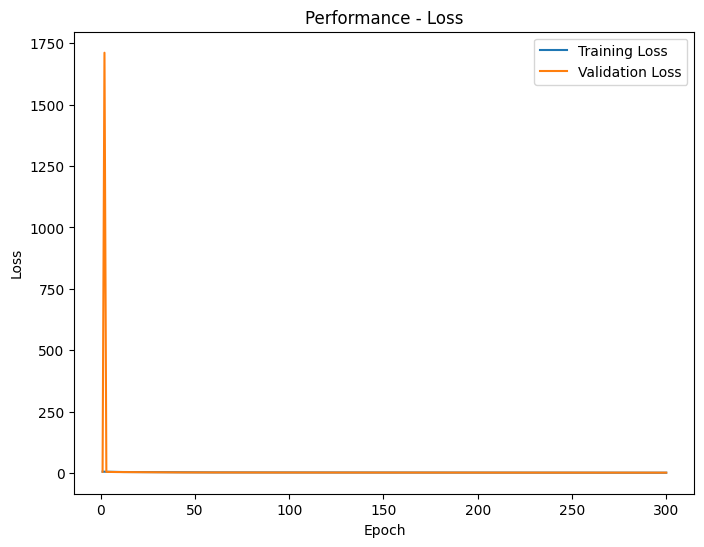

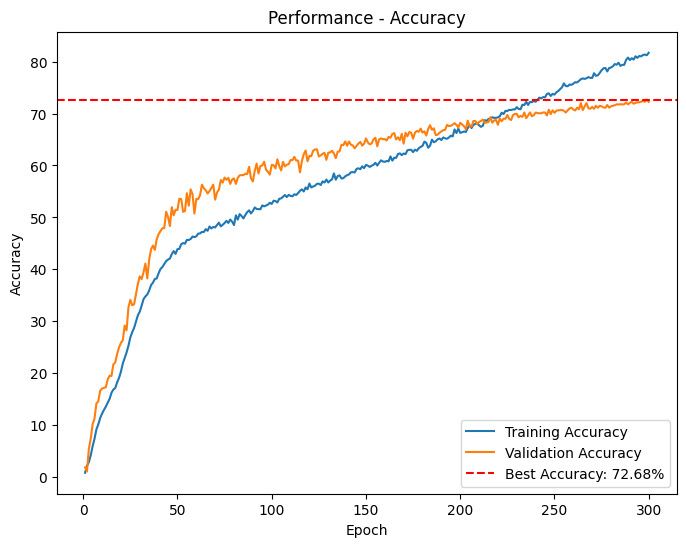

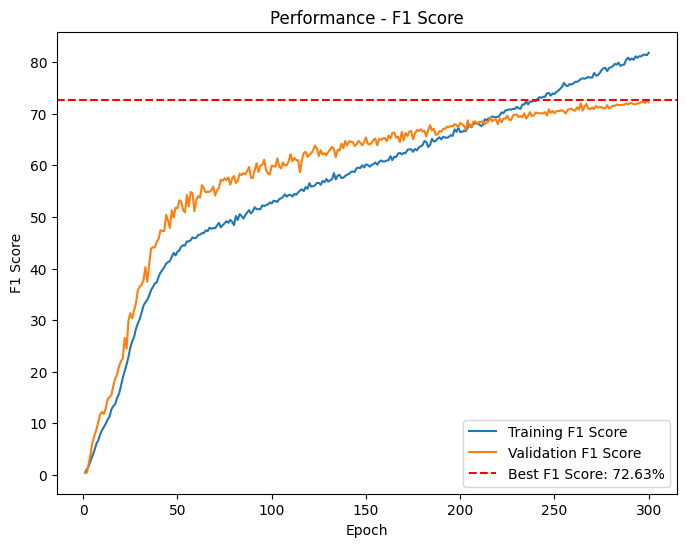

--------------------------------------------------------------------------------

Evaluation...

Validation...


  0%|          | 0/133 [00:00<?, ?it/s]

[INFO] Validation Loss: 2.1351 | Acc: 72.2366% | Weighted F1: 72.2227
Accuracy on Validation set using accuracy_score from sklearn: 72.23662502946028%


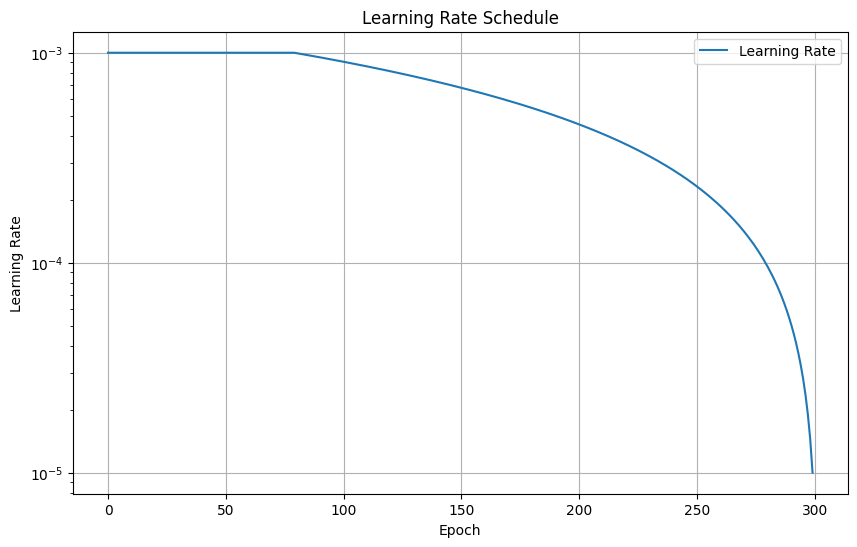

--------------------------------------------------------------------------------
All models have been trained.


In [22]:
results = train.train_valid_evaluate()

In [23]:
print('Done')

Done


## Ploting

# Load Saved Model

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

model = Resnet50(num_classes=num_classes, pretrained=True, fine_tune=False)

model.load_state_dict(torch.load(f'{target_dir}/best_model.pth'))
model.eval()


### USE MODEL OR NEW_MODEL 
# Create a new model and adjust its final layer
new_model = models.resnet50(pretrained=True)
new_model.fc = nn.Sequential(
    nn.Linear(new_model.fc.in_features, num_classes),
    nn.Sigmoid()
)
# Correctly copy the weights and biases from the loaded model to the new model
#new_model.fc[0].weight.data = model.fc[0].weight.data.clone()
#new_model.fc[0].bias.data = model.fc[0].bias.data.clone()

## Clasification on unseen Image

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# Load and preprocess the unseen image
image_path = 'img/boeing_img000019_34_0.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [ ]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)
# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.text(1 , 1 ,f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='green')
plt.show()

In [ ]:
with open("Datasets/brands.txt", "r") as file:
    lines = file.readlines()

lines_upper = [line.upper() for line in lines]

unique_lines = set()
duplicate_lines = []

for line in lines_upper:
    if line in unique_lines:
        duplicate_lines.append(line)
    else:
        unique_lines.add(line)
print(f'{len(unique_lines)} Brands')